Connected to BCIEnvironment (Python 3.10.8)

In [ ]:
# Some standard pythonic imports
import warnings
warnings.filterwarnings('ignore')
import logging
import os,numpy as np,pandas as pd
from collections import OrderedDict
import seaborn as sns
from matplotlib import pyplot as plt
import itertools
from tqdm import tqdm
import json

# MNE library for EEG data analysis
import mne
from mne import Epochs,find_events
from mne.decoding import Vectorizer
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP

# XDF file format support in MNE
import pyxdf
from mne_import_xdf import *

# Scikit-learn and Pyriemann for feature extraction and machine learning functionalities
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.svm import SVC  # Support Vector Classifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import ShuffleSplit, cross_val_score,train_test_split
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit, train_test_split
from pyriemann.estimation import ERPCovariances, XdawnCovariances, Xdawn, Covariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import MDM

#import moab to get the filterbank implementation: 
from moabb.pipelines.utils import FilterBank

# For  GUI elements
from easygui import *

# For path manipulation
import pathlib
from os import listdir
from os.path import isfile, join

# For interactive plots
import PyQt5
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'qt')

#imports for precision_recall_curve related plot: 
from sklearn.preprocessing import label_binarize
from sklearn.metrics import average_precision_score, precision_recall_curve,PrecisionRecallDisplay
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt
import pickle

import copy

To use the get_shape_from_baseconcar, InputShapeSetterEEG, BraindecodeDatasetLoaderyou need to install `braindecode`.`pip install braindecode` or Please refer to `https://braindecode.org`.


c:\Users\CensorLab\anaconda3\envs\BCIEnvironment\lib\site-packages\moabb\pipelines\__init__.py:26: ModuleNotFoundError: Tensorflow is not installed. You won't be able to use these MOABB pipelines if you attempt to do so.
  warn(


In [ ]:
# Define paths for data storage and processing
current_path = pathlib.Path().absolute()  
recording_path = current_path / 'Recordings'
figure_outputs_path=current_path / 'Figures'
hyper_param_search_output=current_path / 'hyper_param_search_outputs'
#extract all recorded files and subject names
recording_files = [f for f in listdir(recording_path) if isfile(join(recording_path, f)) and ('.xdf' in f)]
if not(figure_outputs_path.exists()):
    print('the output folder does not exists:  ',figure_outputs_path)

if not(hyper_param_search_output.exists()):
    print('the output folder does not exists:  ',hyper_param_search_output)


print('all available recording files',recording_files)
subject_names=[r.split('_')[0] for r in recording_files]
print('only subjects IDS:',subject_names)

# Initial definitions: 

print('filenames:\n',recording_files)
print('names:\n',subject_names)

Use_test_grid=False #change to False when you want to use the real grid_search and not a toy one: 

#define the electrode groups: the key can be anything, the values should be a list of electrodes
#define the electrode groups: the key can be anything, the values should be a list of electrodes
Electorde_Groups = {'FP': ['Fp1', 'Fp2'],
                   'AF': ['AF7', 'AF3', 'AFz', 'AF4', 'AF8'],
                   'F' : ['F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8'],
                   'FC': ['FC5', 'FC3', 'FC1', 'FC2', 'FC4', 'FC6'],
                   'C' : ['C5', 'C3', 'C1', 'Cz', 'C2', 'C4' ,'C6'],
                   'CP': ['CP5', 'CP3', 'CP1','CPz', 'CP2', 'CP4', 'CP6'],
                   'P' : ['P7', 'P5','P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8'],
                   'PO': ['PO7', 'PO3', 'POz', 'PO4', 'PO8'],
                   'O' : ['Oz', 'O2', 'O1', 'Iz']
                  } 

#define the grid search (dont go all at once because some params are not relevant to other params and might just increase running time: 
# i.e if using fbcsp, the n_components_grid paramater is not used, so if it has more than 1 value, it will run the fbcsp twice while changing a paramter that does not effect the calculation)
grid_search_dict=OrderedDict()
grid_search_dict={'filter_methods':['iir'], #['irr' or 'fir']
                'run_csd':[True, False],
                'pipeline_name':['csp+lda','ts+lda','fbcsp+lda'], #these classifiers pipelines are defined in "run_windowed_classification_on_fold"
                #things to do: filter bank csp + lda, csp+ts+lda
                'bandpass_borders_grid':[[7,32]], #each list defines the low and high cutoffs
                'Electorde_Groups_names_grid':['C','PO'], #each "name" refers to an elec group defined above
                'n_components_grid':[4], #the n component options for the csp classifier
                'n_components_fbcsp_grid':[2,3], # the n components options to use in the fbcsp classifier (n * filter_bank_bands)\
                'filters_bands':[[[8, 12], [12, 20], [20, 32]]],
                'epoch_tmins_and_maxes_grid':[[-3,5]], #times (sec: pre,post) for initial epoching (this should be the longest epoch as the windowed prediction will be tested on it)
                'classifier_training_windows_grid':[[1 , 2],[1,3]], #what times(sec: start,end) to use for the classifer training (data augmentation is also using this window)
                'augmentation_windows_grid':[[0,0],[0.5,0.5]], #referes to proportions (win_len,win_step) of sfreq, [1,1] means taking the classification epochs, and creating 1 second long epochs with 1 second long steps
                'windowed_prediction_params':[[0.5,0.1],[0.75,0.1],[1,0.1]]} #refers to prportions (win_len,win_step) of sfreq to try and predict i.e. 0.5 = half a second window, with a 100ms steps  

#here you can define a test grid (make it small so it wont take long, and use it to check that everything is working) 
test_grid_search_dict={'filter_methods':['fir'], #['irr' or 'fir']
                'run_csd':[True],
                'pipeline_name':['csp+lda'], #these classifiers pipelines are defined in "run_windowed_classification_on_fold
                #things to do: filter bank csp + lda, csp+ts+lda
                'bandpass_borders_grid':[[8,32]], #each list defines the low and high cutoffs
                'Electorde_Groups_names_grid':['C','PO'], #each "name" refers to an elec group defined above
                'n_components_grid':[4], #the n component options for the csp classifier
                'n_components_fbcsp_grid':[3], # the n components options to use in the fbcsp classifier (n * filter_bank_bands)
                'filters_bands':[[[8, 12], [12, 20], [20, 32]]],
                'epoch_tmins_and_maxes_grid':[[-3,5]], #times (sec: pre,post) for initial epoching (this should be the longest epoch as the windowed prediction will be tested on it)
                'classifier_training_windows_grid':[[0,2]], #what times(sec: start,end) to use for the classifer training (data augmentation is also using this window)
                'augmentation_windows_grid':[[1,0.1]], #referes to proportions (win_len,win_step) of sfreq, [1,1] means taking the classification epochs, and creating 1 second long epochs with 1 second long steps
                'windowed_prediction_params':[[1,0.1]]} #refers to prportions (win_len,win_step) of sfreq to try and predict i.e. 0.5 = half a second window, with a 100ms steps  

if Use_test_grid: 
   print('\n######\nusing a test grid search\n######\n')
   grid_search_dict=test_grid_search_dict

all_options=[list(range(len(val))) for key,val in grid_search_dict.items()]
print(f'grid options {all_options}')
# Get all possible grid_search combinations: 
all_grid_combinations = list(itertools.product(*all_options))
print(f'number of grid search iterations: {len(all_grid_combinations)}')
print('Grid info:',grid_search_dict)
#save the hyper_grid_search: 
with open(hyper_param_search_output/'grid_search_info.json', 'w') as file:
    json.dump(grid_search_dict, file)
    
# Define what electrodes should be excluded 
def get_subject_bad_electrodes(subject):
    elecs_to_drop={}
    #define here the subject specific electdodes to make sure are removed from the data: 
    bad_elecs_dict={'Dekel':{'FT10', 'TP10', 'FT9'},
                    'Gilad':{'FT10', 'TP10', 'FT9', 'TP9'},
                    'Neta':{'TP9'},
                    'Ron-Block':{'PO7'},
                    'sub-Roei': {'TP9'}}
    if subject in bad_elecs_dict.keys():
        subject_bad_electrodes=bad_elecs_dict[subject]
    else: 
        subject_bad_electrodes={}
        print('note that no bad electrodes were defined for the current subject:',subject)
    return subject_bad_electrodes   
    
def set_up_params_for_current_grid_iteration(all_grid_combinations,iteration_ind,grid_search_dict):
    curr_grid_comb=all_grid_combinations[iteration_ind]
    print(f'setting up current params: iteration {iteration_ind} - grid settings: {curr_grid_comb}')
    #create a dictionary from the current grid combination (note that the dictionary is ordered): 
    iteration_dictionary={key:val[inner_ind] for ((key,val),inner_ind) in zip(grid_search_dict.items(),curr_grid_comb)}
   
    #extract the paramaters for the current iteration: 
    LowPass=iteration_dictionary['bandpass_borders_grid'][0]
    HighPass=iteration_dictionary['bandpass_borders_grid'][1]
    PerformCsd=iteration_dictionary['run_csd']
    filter_method=iteration_dictionary['filter_methods']

    #extract current electrodes (allow for combination of electrode groups i.e 'C+AF+F')
    Electorde_Group_name=iteration_dictionary['Electorde_Groups_names_grid'] #['FP', 'AF', 'F', 'FC', 'C', 'CP', 'P', 'PO', 'O']
    Electorde_Group=[]
    for cur_elec_group_name in Electorde_Group_name.split('+'):
        Electorde_Group=Electorde_Group+Electorde_Groups[cur_elec_group_name]
    classifier_window_s=iteration_dictionary['classifier_training_windows_grid'][0]
    classifier_window_e=iteration_dictionary['classifier_training_windows_grid'][1]
    epoch_tmin=iteration_dictionary['epoch_tmins_and_maxes_grid'][0]
    epoch_tmax=iteration_dictionary['epoch_tmins_and_maxes_grid'][1]
    n_components=iteration_dictionary['n_components_grid']
    n_components_fbcsp=iteration_dictionary['n_components_fbcsp_grid']
    #define the current augmentation paramaters to test: note that they are defined by samples
    augmentation_params={'win_len':iteration_dictionary['augmentation_windows_grid'][0],
                        'win_step':iteration_dictionary['augmentation_windows_grid'][1]}
    #define the windowed prediction paramaters: #here they are defined as proportions of the sampling frequency
    windowed_prediction_params={'win_len':iteration_dictionary['windowed_prediction_params'][0],
                                'win_step':iteration_dictionary['windowed_prediction_params'][1]}
    #get the current pipeline name: 
    pipeline_name=iteration_dictionary['pipeline_name']
    filters_bands=iteration_dictionary['filters_bands']                          
    #set paramaters dict for current run: 
    params_dict={'LowPass': LowPass,
                'HighPass': HighPass,
                'PerformCsd':PerformCsd,
                'filter_method':filter_method,
                'n_components':n_components,
                'n_components_fbcsp':n_components_fbcsp,
                'filters_bands':filters_bands,
                'Electorde_Group':Electorde_Group,
                'Electorde_Group_name':Electorde_Group_name,
                'epoch_tmin':epoch_tmin,
                'epoch_tmax':epoch_tmax,
                'classifier_window_s':classifier_window_s,
                'classifier_window_e':classifier_window_e,
                'augmentation_params':augmentation_params,
                'windowed_prediction_params':windowed_prediction_params,
                'pipeline_name':pipeline_name}

    return params_dict

# Need to define a preprocessing function that can accept several participant files and add them to a single structure
def run_pre_processing_extract_validation_set(recording_path,current_path,params_dict):

    #extract the current run paramaters: 
    Subject=params_dict['subject']
    PerformCsd=params_dict['PerformCsd']
    LowPass, HighPass, filter_method = params_dict['LowPass'],params_dict['HighPass'],params_dict['filter_method']
    tmin=params_dict['epoch_tmin']
    tmax=params_dict['epoch_tmax']

    #read the file:
    Raw=read_raw_xdf(recording_path / params_dict['recording_file'])
    #remove non existent channels: 
    if 'ACC_X' in Raw.ch_names:
        Raw.drop_channels(['ACC_X','ACC_Y','ACC_Z']) ## Drop non eeg channels
    #set the correct (Brainvision Montage) montage:
    montage = mne.channels.read_custom_montage((f"{current_path}\Montages\CACS-64_REF.bvef"), head_size=0.095, coord_frame=None) 
    #rename channels for consistency (no longer required for future recordings): 
    #mne.rename_channels(Raw.info, {'F9' : 'FT9','P9' : 'TP9','P10' : 'TP10','F10' : 'FT10','AF1' : 'AF7' }, allow_duplicates=False, verbose=None)
    Raw.set_montage(montage, match_case=True, match_alias=False, on_missing='raise', verbose=None)

    print('\n###########################################################')
    print('removing subject specific bad electrodes from the raw data')
    #drop bad electrodes according to the current subject name: 
    print('\n###########################################################')
    print('removing bad channels from epochs:')
    curr_elecs_in_epochs_set=set(Raw.info['ch_names'])
    elecs_to_remove=get_subject_bad_electrodes(Subject)
    elecs_to_drop=curr_elecs_in_epochs_set.intersection(elecs_to_remove)

    if len(elecs_to_drop)>0: 
        Raw.drop_channels(list(elecs_to_drop))
    Raw.drop_channels(Raw.info['bads'])

    # Do csd: 
    if (PerformCsd):
        print('\n###########################################################')
        print('running csd')
        Raw_CSD = mne.preprocessing.compute_current_source_density(Raw) ## Compute CSD
    else :
        print('\n###########################################################')
        print('not using csd')
        mne.set_eeg_reference(Raw, copy=False)
        Raw_CSD =Raw
    print('\n###########################################################')
    print('filtering the data')  
   # Raw_CSD.pick= (params_dict['Electorde_Group'])
    unfiltered_Raw_CSD=Raw_CSD.copy()
    Raw_CSD_Filtered = unfiltered_Raw_CSD.filter(LowPass, HighPass, method=filter_method)

    #extract filterbank feequencies:
    filters_bands=tuple(params_dict['filters_bands'])
    filtered_data_band_passed=[]
    for i,(LowPass,HighPass) in enumerate(filters_bands):
        unfiltered_Raw_CSD=Raw_CSD.copy()
        Raw_CSD_Filtered_band= mne.filter.filter_data(unfiltered_Raw_CSD.get_data(),sfreq=500, l_freq=LowPass, h_freq=HighPass, method='fir',copy = True)
        filtered_data_band_passed.append(Raw_CSD_Filtered_band)

    events_from_annot,event_dict = mne.events_from_annotations(Raw_CSD_Filtered)
    print('\n###########################################################')
    print('extracting event info:',event_dict)
    # Select relevant events for epoching
    desired_events = ['Rest','ClosePalm','OpenPalm'] 
    events_trigger_dict = {key: event_dict[key] for key in event_dict.keys() if key in desired_events}
    print('\n###########################################################')
    selected_elecs=params_dict['Electorde_Group']

    #filter bank related: 
    filter_bank_epochs=[]
    for filtered_data_band in filtered_data_band_passed:
        filtered_data_band_raw = mne.io.RawArray(filtered_data_band,unfiltered_Raw_CSD.info)
        epochs = mne.Epochs(filtered_data_band_raw, events_from_annot, picks = params_dict['Electorde_Group'], preload = True,baseline= None, tmin=tmin, tmax=tmax, event_id=events_trigger_dict,detrend=0)
        filter_bank_epochs.append(epochs)

    print(f'epoching + selecting current electodes set for analysis:\n{selected_elecs}')
    epochs = mne.Epochs(Raw_CSD_Filtered, events_from_annot,picks = params_dict['Electorde_Group'], preload = True,baseline= None, tmin=tmin, tmax=tmax, event_id=events_trigger_dict,detrend=0)
    
    ## Centering the data

    centered_data_list = []
    events_list = []
    mean_across_epochs = epochs.get_data().mean(axis=0)
    # Loop through each event ID
    for idx,event_id in enumerate(desired_events):
        print (event_id)
        # Extract epochs for the current event
        event_epochs = epochs[event_id]
        event_data = event_epochs.get_data()
        
        # Calculate the mean across epochs for the current event
        mean_across_event_epochs = event_data.mean(axis=0)
        
        # Subtract the mean from each epoch of the current event
        centered_event_data = event_data - mean_across_event_epochs
        
        # Store the centered data
        centered_data_list.append(centered_event_data)
        
        # Prepare the events list and event_id_map for the combined EpochsArray
        events_list.append(event_epochs.events)

    # Concatenate all centered data and events
    centered_data = np.concatenate(centered_data_list, axis=0)
    combined_events = np.concatenate(events_list, axis=0)

    # Sort the combined events based on their original occurrence time to preserve the temporal sequence
    sort_indices = np.argsort(combined_events[:, 0])
    combined_events = combined_events[sort_indices]
    centered_data = centered_data[sort_indices]

    # Create a new EpochsArray with the centered data
    centered_epochs = mne.EpochsArray(centered_data, epochs.info, events=combined_events, event_id=epochs.event_id, tmin=epochs.tmin)
    epochs = centered_epochs



    #this section drops electrodes after epoching: but currently we drop all bad electrodes from the raw data
    print('\n###########################################################')
    print('removing bad channels from epochs:')
    curr_elecs_in_epochs_set=set(epochs.info['ch_names'])
    elecs_to_remove=get_subject_bad_electrodes(Subject)
    elecs_to_drop=curr_elecs_in_epochs_set.intersection(elecs_to_remove)

    if len(elecs_to_drop)>0:
        epochs.info['bads']=elecs_to_drop
        epochs.drop_channels(epochs.info['bads'])
        print('\n###########################################################')
        print(f'Removed: {elecs_to_drop} from the current selected electrodes: {curr_elecs_in_epochs_set} from the overall set of bad electrodes {elecs_to_remove}')
        print('#############################################################')
    
        #filter bank related: 
        filter_bank_epochs_after_elec_drops=[]
        for curr_epochs in filter_bank_epochs:
            curr_epochs.info['bads']=elecs_to_drop
            curr_epochs.drop_channels(epochs.info['bads'])
            filter_bank_epochs_after_elec_drops.append(curr_epochs)    
    else: 
        #filter bank related: 
        filter_bank_epochs_after_elec_drops=[]
        for curr_epochs in filter_bank_epochs:
            filter_bank_epochs_after_elec_drops.append(curr_epochs)  

        print('\n###########################################################')
        print(f'the current selected electrodes: {curr_elecs_in_epochs_set} allready exclude the requested electrodes to remove {elecs_to_remove}')
        print('#############################################################')

    #extract the validation set: we will use it only after selecting all hyper paramaters to get a better representation of out-of-sample performence: 
    #using a very small test size as we currently mostly look at the CV scores: 
    data_df=pd.DataFrame(data=epochs.events[:, -1], columns=['label'] ,index=range(len(epochs.events[:, -1])))
    data_df['original_trial_ind']=range(len(epochs.events[:, -1]))
    train,validation=train_test_split(data_df,shuffle=True,random_state=42,stratify=data_df['label'],test_size=0.2)
 
    train_inds=train['original_trial_ind'].values
    validation_inds=validation['original_trial_ind'].values
    print(f'putting aside 20% of the data: trial numbers are:\n {validation_inds}\n')
    print(f'remaining 80% of the trials go into training for cv:\n {train_inds}\n')

    return_dict={'train_inds':train_inds,
                'validation_inds':validation,
                'epochs':epochs,
                'filter_bank_epochs':filter_bank_epochs_after_elec_drops,
                'events_triggers_dict':events_trigger_dict}
    return train_inds,validation_inds,return_dict,mean_across_epochs

def crop_the_data(epochs,train_inds,validation_inds,full_epoch_tmin=0,full_epoch_tmax=5,tmin=1,tmax=2):
    #returns a dictionary containing the cropped and uncropped versions of the validation and training epochs.
    tmin=float(tmin)
    tmax=float(tmax)
    #save uncropped versions of the data: 
    #save the training data:
    train_set_data_uncroped=epochs.get_data()[train_inds]
    train_set_labels_uncroped=epochs.events[train_inds,-1]

    #save the validation data: 
    validation_set_data_uncroped=epochs.get_data()[validation_inds]
    validation_Set_labels_uncroped=epochs.events[validation_inds,-1]

    #crop the epochs (use the epochs structure)
    epochs_cropped = epochs.copy().crop(tmin=full_epoch_tmin, tmax=full_epoch_tmax)

    #from here on - we extract the data as matrices (not epoch object anymore):

    #save the training data:
    train_set_data=epochs_cropped.get_data()[train_inds]
    train_set_labels=epochs_cropped.events[train_inds,-1]

    #save the validation data: 
    validation_set_data=epochs_cropped.get_data()[validation_inds]
    validation_set_labels=epochs_cropped.events[validation_inds,-1]

    return_dict={'train_set_data_uncroped':train_set_data_uncroped,
                'train_set_labels_uncroped':train_set_labels_uncroped,
                'validation_set_data_uncroped':validation_set_data_uncroped,
                'validation_Set_labels_uncroped':validation_Set_labels_uncroped,
                'epochs_cropped':epochs_cropped,
                'train_set_data':train_set_data,
                'train_set_labels':train_set_labels,
                'validation_set_data':validation_set_data,
                'validation_set_labels':validation_set_labels}
    return return_dict

def plot_accuracy_over_time(scores_windows,w_times,params_dict,axes_handle):
    #this function accepts the scores windows (a list of n folds - each giving a score on a time window)
    #it converts it to a long dataframe with the following columns: fold_id,Time,Accuracy
    #then it uses the long format to plot using seaborn lineplot and get a confidence interval
    times_col_names=[np.round(w_times[s],2) for s in range(len(w_times))]
    scores_windows_array=np.squeeze(np.array(scores_windows))
    scores_windows_df=pd.DataFrame(columns=times_col_names,data=scores_windows_array)
    scores_windows_df['fold_id']=range(len(scores_windows_df))
    longform_scores_windows_df=pd.melt(scores_windows_df, id_vars='fold_id', value_vars=scores_windows_df.columns)
    longform_scores_windows_df.rename(columns={'variable':'Time','value':'Accuracy'},inplace=True)
    sns.lineplot(data=longform_scores_windows_df,x='Time',y='Accuracy',ax=axes_handle)

    if any(w_times>0):
        onset_location=np.round(w_times[w_times>=0][0],2) ## find the onest (assuming 0 in epoch time)
        axes_handle.axvline(onset_location, linestyle='--', color='k', label='Onset') 
    axes_handle.axhline(0.5, linestyle='-', color='k', label='Chance') #Need to adjust to multiple classes cases
    axes_handle.set_xlabel('time (s)')
    axes_handle.set_ylabel('classification accuracy')
    axes_handle.set_title('Classification score over time')
    axes_handle.set_ylim([0.25, 1])
    
def run_windowed_classification_on_fold(fold_train_data_x,fold_train_data_y,fold_test_data_x_uncroped,fold_test_data_y,params_dict,w_start,w_length, BinaryClassification = False):
    #note that this is currently the  function that really does the classification and extracts the performence measure (the previous calls to run_lda.... for example, are just tests)
    curr_classifier_name=params_dict['pipeline_name']
    if curr_classifier_name=='csp+lda':  
        #define the classifier components:  
        lda = LinearDiscriminantAnalysis()
        csp = CSP(n_components=params_dict['n_components'], reg=None, log=True, norm_trace=False)
        #define the pipeline: 
        clf = Pipeline([('csp',csp),('classifier_LDA',lda)])
    elif curr_classifier_name=='csp+svm':
        #define the classifier components:  
        csp = CSP(n_components=params_dict['n_components'], reg=None, log=True, norm_trace=False)
        #define the pipeline: 
        clf = Pipeline([('csp',csp), ('ovo_svm', OneVsOneClassifier(SVC(kernel='linear', random_state=42)))])
    elif curr_classifier_name=='ts+lda':
        #define the classifier components:  
        covest = Covariances()
        ts = TangentSpace()
        lda = LinearDiscriminantAnalysis()
        #define the pipeline: 
        clf = Pipeline([('conv',covest),('ts', ts), ('LDA', lda)])
    elif curr_classifier_name=='fbcsp+lda':
        #define the classifier components: 
        lda = LinearDiscriminantAnalysis()
        csp = CSP(n_components=params_dict['n_components_fbcsp'], reg=None, log=True, norm_trace=False)
        fb=FilterBank(csp)
        #define the pipeline: 
        clf = Pipeline([('fbcsp',fb),('classifier_LDA',lda)])
    else: 
        raise Exception(f'the requested classifier is not defined in "run_windowed_classification_on_fold": {curr_classifier_name}')
    
    #get string labels instead of numeric (so the classifier will have an informative clf.classes_ )
    triggers_label_dict={val:key for key,val in params_dict['preprocessing_dict']['events_triggers_dict'].items()} 
    fold_train_data_y_labels=np.array([triggers_label_dict[cur_y] for cur_y in fold_train_data_y])  
    A, B  = 'OpenPalm', 'ClosedPalm'  # Replace with actual trigger names/values
    combined_labels_train = np.array(['motor_imagery' if label in [A, B] else 'rest' for label in fold_train_data_y_labels])
    #fit the selected classifier: 
    
    

    if BinaryClassification:
        clf.fit(fold_train_data_x, combined_labels_train)
    else:
        clf.fit(fold_train_data_x, fold_train_data_y_labels)
    # running classifier: test classifier on sliding window

    #get string labels instead of numeric for the test
    fold_test_data_y_labels=np.array([triggers_label_dict[cur_y] for cur_y in fold_test_data_y])
    if BinaryClassification:
        combined_labels_test = np.array(['motor_imagery' if label in [A, B] else 'rest' for label in fold_test_data_y_labels])

        fold_windowed_scores,confusion_metrices_per_window=run_windowed_pretrained_classifier(clf,fold_test_data_x_uncroped,combined_labels_test,w_start,w_length)
    else:
        fold_windowed_scores,confusion_metrices_per_window=run_windowed_pretrained_classifier(clf,fold_test_data_x_uncroped,fold_test_data_y_labels,w_start,w_length)
    return fold_windowed_scores,confusion_metrices_per_window,clf

def run_windowed_pretrained_classifier(clf,x_uncropped,y,w_start,w_length):
    scores_per_time_window = []
    confusion_metrices_per_window=[]
    if len(x_uncropped.shape)==3: #reshape it as if it was a 4d matrix (assuming the 4th dimention is the filterbank)
        x_uncropped=x_uncropped.reshape(list(x_uncropped.shape)+[1])
    for n in w_start:
        fold_data=np.squeeze(x_uncropped[:, :, n:(n + w_length),:]) #using squeeze here so that if the 4th dimention size is 1 it will reduce it to a 3d vector
        #if the classifier uses a filterbank its input should be 4d (trials,channels,timesteps,filter_bands) and if it doesnt its 3d (trials,channels,timesteps)
        fold_score_on_time_window=clf.score(fold_data, y)
        #append the score for the LDA, using this csp to predict the relevant test scores: 
        scores_per_time_window.append(fold_score_on_time_window)
        confusion_mat=confusion_matrix(y,clf.predict(fold_data),labels=clf.classes_)
        confusion_metrices_per_window.append(confusion_mat)
    return scores_per_time_window,confusion_metrices_per_window

def augment_data(augmentation_params,data_x_to_augment,y,sfreq):
    #do augmentation: 
    if (augmentation_params['win_step']==0 or augmentation_params['win_len']==0): #check if augmentation is not requested/invalid:
        augmented_x=data_x_to_augment
        augmented_y=y
    else: #augmentation requested
        #set up the augmentation window boundaries based on the augmentation paramaters:                      
        aug_epochs_s=np.arange(0,data_x_to_augment.shape[2],augmentation_params['win_step']*sfreq)
        aug_epochs_e=np.array([a+augmentation_params['win_len']*sfreq for a in aug_epochs_s])
        #remove start and ends that exceeds the relevant epoch lengths: 
        aug_epochs_s=aug_epochs_s[aug_epochs_e<data_x_to_augment.shape[2]]
        aug_epochs_e=aug_epochs_e[aug_epochs_e<data_x_to_augment.shape[2]]

        #pile all augmented (sub windows) to have the regular structure of epochs (>original due to augmentation,channels,samples)
        data_fold_x_augmented=[]
        data_fold_y_augmented=[]
        for aug_s,aug_e in zip(aug_epochs_s,aug_epochs_e):
            if len(data_x_to_augment.shape)==3:
                data_x_in_cur_window=data_x_to_augment[:,:,int(aug_s):int(aug_e)]
            elif len(data_x_to_augment.shape)==4: #with filterbank: 
                data_x_in_cur_window=data_x_to_augment[:,:,int(aug_s):int(aug_e),:]
            data_y_in_cur_window=y
            data_fold_x_augmented.append(data_x_in_cur_window)
            data_fold_y_augmented.append(data_y_in_cur_window)

        augmented_x=np.concatenate(data_fold_x_augmented,axis=0)
        augmented_y=np.concatenate(data_fold_y_augmented)
    return augmented_x,augmented_y

def run_windowed_classification_aug_cv(epochs_cropped,cv_split,train_set_data,train_set_labels,train_set_data_uncroped,params_dict, BinaryClassification):
    augmentation_params=params_dict['augmentation_params']
    windowed_prediction_params=params_dict['windowed_prediction_params']
    win_len=windowed_prediction_params['win_len']
    win_step=windowed_prediction_params['win_step']
    
    sfreq = epochs_cropped.info['sfreq']
    w_length = int(sfreq * win_len)   # running classifier: window length
    w_step = int(sfreq * win_step)  # running classifier: window step size
    w_start = np.arange(0, train_set_data_uncroped.shape[2] - w_length, w_step)
    print('uncroped train set length = ',train_set_data_uncroped.shape[2])

    scores_windows = []
    folds_confusion_metrices_per_window=[]
    #this section first extracts each CV fold, only then it augments it (to avoid data leakage)
    for train_idx, test_idx in cv_split:
        #seperate the cv fold for labels - train-test:
        y_train, y_test = train_set_labels[train_idx], train_set_labels[test_idx] 
        #seperate the cv fold for features information: 
        if len(train_set_data.shape)==3:
            data_fold_x_train_to_augment = train_set_data[train_idx,:,:]
        elif len(train_set_data.shape)==4: #there are filter bank info in the data: 
            data_fold_x_train_to_augment = train_set_data[train_idx,:,:,:] 
        #do augmentation: 
        augmented_x,augmented_y=augment_data(augmentation_params,data_fold_x_train_to_augment,y_train,sfreq)
        #run classifier on the data fold
        curr_scores_windows,confusion_metrices_per_window,_=run_windowed_classification_on_fold(augmented_x,augmented_y,train_set_data_uncroped[test_idx],y_test,params_dict,w_start,w_length, BinaryClassification)         
        scores_windows.append(curr_scores_windows)
        folds_confusion_metrices_per_window.append(confusion_metrices_per_window)
    w_times = (w_start + w_length / 2.) / sfreq + params_dict['epoch_tmin']
    return scores_windows,folds_confusion_metrices_per_window,w_times

def run_windowed_classification_aug(epochs_cropped,train_set_data,train_set_labels,train_set_data_uncroped,test_y,params_dict,BinaryClassification):
    augmentation_params=params_dict['augmentation_params']
    windowed_prediction_params=params_dict['windowed_prediction_params']
    win_len=windowed_prediction_params['win_len']
    win_step=windowed_prediction_params['win_step']
    sfreq = epochs_cropped.info['sfreq']
    w_length = int(sfreq * win_len)   # running classifier: window length
    w_step = int(sfreq * win_step)  # running classifier: window step size
    w_start = np.arange(0, train_set_data_uncroped.shape[2] - w_length, w_step)
    w_times = (w_start + w_length / 2.) / sfreq + params_dict['epoch_tmin']

    augmented_x,augmented_y=augment_data(augmentation_params,train_set_data,train_set_labels,sfreq)
    scores_windows,confusion_metrices_per_window,trained_clf=run_windowed_classification_on_fold(augmented_x,augmented_y,train_set_data_uncroped,test_y,params_dict,w_start,w_length, BinaryClassification)         

    return scores_windows,confusion_metrices_per_window,w_times,trained_clf

def run_training_and_classification_on_selected_params(params_dict,preprocessing_dict, BinaryClassification = False ,to_plot=False,figure_outputs_path='',fig_name='temp'):
    epochs_copy=preprocessing_dict['epochs']
    train_inds=preprocessing_dict['train_inds']
    validation_inds=preprocessing_dict['validation_inds']['original_trial_ind'].values

    #crop the data according to the training window: 
    returned_dict=crop_the_data(epochs_copy,train_inds,validation_inds,params_dict['classifier_window_s'],params_dict['classifier_window_e']) #two more paramters here are tmin and tmax which are not used apparently. 
    train_set_data_uncropped=returned_dict['train_set_data_uncroped']
    epochs_cropped=returned_dict['epochs_cropped']
    train_set_data=returned_dict['train_set_data']
    train_set_labels=returned_dict['train_set_labels']

    validation_set_labels=returned_dict['validation_set_labels']
    validation_set_data_uncropped=returned_dict['validation_set_data_uncroped']
    #define cv on the data: 
    cv = StratifiedShuffleSplit(10, test_size=0.2, random_state=42)
    cv_split = cv.split(train_set_data,train_set_labels)

    #filter bank related:
    if params_dict['pipeline_name']=='fbcsp+lda': 
        train_set_data_fb=[]
        train_set_data_uncropped_fb=[]
        validation_set_data_fb=[]
        validation_set_data_uncropped_fb=[]
        for filtered_data_band_epoch in preprocessing_dict['filter_bank_epochs']:
            returned_dict_temp=crop_the_data(filtered_data_band_epoch,train_inds,validation_inds, params_dict['classifier_window_s'],params_dict['classifier_window_e'])
            #extract the train set data: 
            train_set_data_uncroped_temp=returned_dict_temp['train_set_data_uncroped']
            train_set_data_temp=returned_dict_temp['train_set_data']
            train_set_data_fb.append(train_set_data_temp)
            train_set_data_uncropped_fb.append(train_set_data_uncroped_temp)
            #extract the validation set data: 
            validation_set_data_uncroped_temp=returned_dict_temp['validation_set_data_uncroped']
            validation_set_data_temp=returned_dict_temp['validation_set_data']
            validation_set_data_fb.append(validation_set_data_temp)
            validation_set_data_uncropped_fb.append(validation_set_data_uncroped_temp)
        #create a 4d matrix of train data:     
        train_set_data_4d_array= np.transpose(np.array(train_set_data_fb),(1,2,3,0))
        train_set_data_uncropped_4d_array=np.transpose(np.array(train_set_data_uncropped_fb),(1,2,3,0)) 
        train_set_data=train_set_data_4d_array
        train_set_data_uncropped=train_set_data_uncropped_4d_array
        #create a 4d matrix of validation data: 
        validation_set_data_4d_array= np.transpose(np.array(validation_set_data_fb),(1,2,3,0))
        validation_set_data_uncropped_4d_array=np.transpose(np.array(validation_set_data_uncropped_fb),(1,2,3,0)) 
        validation_set_data_uncropped=validation_set_data_uncropped_4d_array

    #get scores over time using CV: 
    scores_windows,folds_confusion_metrices_per_window,w_times=run_windowed_classification_aug_cv(epochs_cropped,cv_split,train_set_data,train_set_labels,train_set_data_uncropped,params_dict, BinaryClassification)
    
    #train the classifier based on ALL training data, and test its prediction on the unseen validation set: 
    validaiton_scores,validation_confusion_metrices_per_window,_,trained_clf=run_windowed_classification_aug(epochs_cropped,train_set_data,train_set_labels,validation_set_data_uncropped,validation_set_labels,params_dict, BinaryClassification)
    if to_plot:
        fig,axes=plt.subplots(nrows=1,ncols=2)
        plot_accuracy_over_time(scores_windows,w_times,params_dict,axes_handle=axes[0])
        epochs_copy.plot_sensors(show_names=True,axes=axes[1])
        figname=fig_name + '.svg'
        fig.savefig(figure_outputs_path / figname)
    else:
        fig=[]
    return fig,w_times,scores_windows,folds_confusion_metrices_per_window,validaiton_scores,validation_confusion_metrices_per_window,trained_clf

def run_grid_search_on_single_participant(grid_search_dict,recording_file,Subject,save_every_n_iter,save_location_path,to_plot=True):
    all_options=[list(range(len(val))) for key,val in grid_search_dict.items()]
    #get all possible grid_search combinations: 
    all_grid_combinations = list(itertools.product(*all_options))
    print(f'number of grid search iterations: {len(all_grid_combinations)}')

    grid_search_data_frame_info=pd.DataFrame()
    print('running grid search on:',recording_file)
    #put all in a single params_dictionary for the current run: 
    #run all grid_search iterations: 
    for iteration_ind in tqdm(range(len(all_grid_combinations))):
        #extract current iteration paramaters:
        params_dict=set_up_params_for_current_grid_iteration(all_grid_combinations,iteration_ind,grid_search_dict)
        
        #add subject specific information: 
        params_dict['recording_file']=recording_file
        params_dict['subject']=Subject
        print(f'test iteration: dictionary paramaters: {params_dict}')
        #run preprocessing:
        train_inds,validation_inds,preprocessing_dict,mean_across_epochs=run_pre_processing_extract_validation_set(recording_path,current_path,params_dict)
        #run prediction on cross validation:
        fig,w_times,scores_windows,validation_scores=run_training_and_classification_on_selected_params(params_dict,preprocessing_dict,to_plot=to_plot,figure_outputs_path=figure_outputs_path,fig_name='test')
        #train the model on all the training data: 
        #   tbd
        #run prediction on the validation set(?)
        #   tbd
        #add scores related information: 
        curr_params_df=pd.DataFrame([params_dict],index=[iteration_ind])
        curr_params_df['mean_scores']=np.nan
        curr_params_df['std_scores']=np.nan
        curr_params_df['mean_scores']=curr_params_df['mean_scores'].astype(object)
        curr_params_df['std_scores']=curr_params_df['mean_scores'].astype(object)
        curr_params_df['mean_scores']=[np.mean(scores_windows,axis=1)]
        curr_params_df['std_scores']=[np.std(scores_windows,axis=1)]
        grid_search_data_frame_info=pd.concat([grid_search_data_frame_info,curr_params_df],axis=0)
        df_name='hypter_param_search_' + recording_file.split('.')[0] + '.csv'
        if np.mod(iteration_ind,save_every_n_iter)==0:
            print('saving')
            grid_search_data_frame_info.to_csv(hyper_param_search_output / df_name)

    #save all grid_search results: 
    grid_search_data_frame_info.to_csv(hyper_param_search_output / df_name)
    return grid_search_data_frame_info

def plot_precision_recall_curves_from_trained_classifier(preprocessing_dict,params_dict,precision_recall_curve_timerange,trained_clf,predict_validation=True):
    #to learn on precision recall curves see :https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html 
    #the code is adapated for our usage: 
    #prepreocessing_dict - dictionary that contains the {original epoched data, and the training/validation indexes}
    #params_dict - dictionary that contains the prediction paramaters
    #precision_Revall_curve_timerange - list #in seconds relative to epoch (so if epoch is -3 to +4, 3-4 will take the last second in the epoch )
    #trained_clf - the classifier that was previously trained on all the data: (note that this means that the report here is biased (better than really is))
    #predict_validation - true - will use only validation indexes, false - will use only training indexes (much more biased ofcourse) 
    
    #define what time_range you want to extract the recall/precision for: 
    print(f'chosen window prediction range is {precision_recall_curve_timerange}\nnote that the prediction paramaters (that the classifier is trained on) are: {params_dict["windowed_prediction_params"]}\nconsider if you want the preciction range to match the prediction_param')
    
    #decide if we use the training or the validation set to plot: 
    if predict_validation: 
    #get the relevant data for the validation set: 
        inds=preprocessing_dict['validation_inds']['original_trial_ind'].values
    else:
        inds=preprocessing_dict['train_inds']


    #extract the labels: 
    labels=preprocessing_dict['epochs'].events[inds, -1]
    #extract the decision function: 

    #fbcsp
    if params_dict['pipeline_name']=='fbcsp+lda':
        data_set_fb = []
        for filtered_data_band_epoch in preprocessing_dict['filter_bank_epochs']:
            temp_data = filtered_data_band_epoch.copy().crop(tmin=precision_recall_curve_timerange[0],tmax=precision_recall_curve_timerange[1]).get_data()[:]
            data_set_fb.append(temp_data)
        data_set_fb_4d_array= np.transpose(np.array(data_set_fb),(1,2,3,0))
        decision_function=trained_clf.decision_function((data_set_fb_4d_array)[inds,:])
    else:
            decision_function=trained_clf.decision_function(preprocessing_dict['epochs'].copy().crop(tmin=precision_recall_curve_timerange[0],tmax=precision_recall_curve_timerange[1]).get_data()[inds,:])
    y_score=decision_function
    # Use label_binarize to be multi-label like settings (basicly the current label position is 1 and rest are 0): 
    #so the label list of say, 0 2 4 4 will output = [1,0,0],[0,1,0],[0,0,1],[0,0,1]
    classes_numeric_list=list(preprocessing_dict['events_triggers_dict'].values())
    classes_names_list=list(preprocessing_dict['events_triggers_dict'].keys())
    #take the classes from the preprocessing dict:
    # Combine classes 3 and 5 into a single class, e.g., class 1
    binarized_labels = np.where(np.isin(labels, [3, 5]), 1, 0)
    Y = label_binarize(labels, classes=classes_numeric_list)
    n_classes = Y.shape[1]

    #calculate precision and recall for each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    thresholds=dict()
    if n_classes==1: #in a binary setting where the score is only relates to being in group "1" (or maybe 0, worth checking)
        precision[0], recall[0], thresholds[0]  = precision_recall_curve(Y, y_score)
        average_precision[0] = average_precision_score(Y, y_score)
    else: 
        for i in range(n_classes):
            precision[i], recall[i], thresholds[i] = precision_recall_curve(Y[:, i], y_score[:, i])
            average_precision[i] = average_precision_score(Y[:, i], y_score[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(Y.ravel(), y_score.ravel())
    average_precision["micro"] = average_precision_score(Y, y_score, average="micro")

    # setup plot details
    colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal"])

    _, ax = plt.subplots(figsize=(7, 8))

    f_scores = np.linspace(0.2, 0.8, num=4)
    lines, labels = [], []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
        plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

    display = PrecisionRecallDisplay(
        recall=recall["micro"],
        precision=precision["micro"],
        average_precision=average_precision["micro"],
    )
    display.plot(ax=ax, name="micro-average precision-recall", color="gold")

    for i, color in zip(range(n_classes), colors):
        display = PrecisionRecallDisplay(
            recall=recall[i],
            precision=precision[i],
            average_precision=average_precision[i],
        )
        display.plot(ax=ax, name=f"Precision-recall for class {classes_names_list[i]}", color=color)

    # add the legend for the iso-f1 curves
    handles, labels = display.ax_.get_legend_handles_labels()
    handles.extend([l])
    labels.extend(["iso-f1 curves"])
    # set the legend and the axes
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.legend(handles=handles, labels=labels, loc="best")
    ax.set_title(f"multi-class Precision-Recall curve\npredicted time range: {precision_recall_curve_timerange}")

    plt.show()
    #create a dataframe with all information relevant to the plot. 
    precision.pop('micro')
    precision_df=pd.DataFrame(precision)
    precision_df.columns=['precision_'+str(colname) for colname in precision_df.columns] 
    recall.pop('micro')
    recall_df=pd.DataFrame(recall)
    recall_df.columns=['recall_'+str(colname) for colname in recall_df.columns]
    thresholds_df=pd.DataFrame(thresholds)
    thresholds_df.columns=['thresholds'+str(colname) for colname in thresholds_df.columns]

    return_df=pd.concat([precision_df,recall_df,thresholds_df],axis=1)


    return return_df

all available recording files ['Fudge_MI3_1.xdf', 'Fudge_MI3_2.xdf', 'Fudge_MI3_3.xdf', 'Fudge_MI3_4.xdf', 'Gilad_3_AO.xdf', 'Gilad_MI3_1.xdf', 'Gilad_MI3_2.xdf', 'Gi_Block_1.xdf', 'Gi_Block_3.xdf', 'Gi_Block_4.xdf', 'NH37_Block_1.xdf', 'NH37_Block_2.xdf', 'NH37_Block_3.xdf', 'NH_3_AO.xdf', 'NH_3_MI1.xdf', 'NH_3_MI2.xdf', 'NH_3_MI3.xdf', 'NH_3_MI4.xdf', 'NH_Block_3.xdf', 'Realtime_annotations.xdf', 'Ron_MI_3_1.xdf', 'Ron_MI_3_2.xdf', 'Ron_MI_3_3.xdf', 'Ron_MI_3_4.xdf']
only subjects IDS: ['Fudge', 'Fudge', 'Fudge', 'Fudge', 'Gilad', 'Gilad', 'Gilad', 'Gi', 'Gi', 'Gi', 'NH37', 'NH37', 'NH37', 'NH', 'NH', 'NH', 'NH', 'NH', 'NH', 'Realtime', 'Ron', 'Ron', 'Ron', 'Ron']
filenames:
 ['Fudge_MI3_1.xdf', 'Fudge_MI3_2.xdf', 'Fudge_MI3_3.xdf', 'Fudge_MI3_4.xdf', 'Gilad_3_AO.xdf', 'Gilad_MI3_1.xdf', 'Gilad_MI3_2.xdf', 'Gi_Block_1.xdf', 'Gi_Block_3.xdf', 'Gi_Block_4.xdf', 'NH37_Block_1.xdf', 'NH37_Block_2.xdf', 'NH37_Block_3.xdf', 'NH_3_AO.xdf', 'NH_3_MI1.xdf', 'NH_3_MI2.xdf', 'NH_3_MI3.xdf', 'NH

In [ ]:
# After everything is set up, train and test the classifier 
# We load the defined datafiles and run the same preprocessing pipeline, then concatinate it into a single "combined_preprocessing_dict"
# From here, everything works with the same functions that run on single participants

# Define which subject to currently check: 
for recording_file,Subject in zip(recording_files[0:3],subject_names[0:3]):
    print(recording_file,Subject)

#this code is custom to aggregate all 3 of roi recordings into a single processing_dict structure. 

#####################################################
#define manually paramaters that we wish to change: 
#get all possible grid_search combinations: 
iteration_ind=0 #select some grid search combination - you can manualy change the params after getting the "params_dict" below
grid_search_dict_copy=grid_search_dict.copy()
all_grid_combinations = list(itertools.product(*all_options))
#here i can change manually the current iteration params: 
grid_search_dict_copy['Electorde_Groups_names_grid']=['F+C+CP+P+PO']
grid_search_dict_copy['filters_bands']=[[[7, 12], [12, 20], [20, 28], [28, 35]]]#[[[8,12], [12, 16],[16,20],[20,24],[24,28],[28,32]]]
#this cell allow to test specific iterations
params_dict=set_up_params_for_current_grid_iteration(all_grid_combinations,iteration_ind,grid_search_dict_copy)
params_dict['subject']=Subject
params_dict['recording_file']=recording_file
params_dict['PerformCsd']=True
params_dict['filter_method']='fir'
params_dict['epoch_tmins_and_maxes_grid'] = [-3,5]
params_dict['n_components']= 8
params_dict['LowPass']=5
params_dict['HighPass']=35
params_dict['augmentation_params']={'win_len': 2, 'win_step': 0.1}
params_dict['classifier_window_s']=0.5
params_dict['classifier_window_e']=3.5
params_dict['windowed_prediction_params']={'win_len': 2, 'win_step': 0.1}
params_dict['pipeline_name']='csp+lda'
params_dict['n_components_fbcsp']=4

BinaryClassification = False

##########################preprocess each of the recording seperately#########################
preprocessing_dicts=[]

for recording_file,subject in zip(recording_files[0:3],subject_names[0:3]):
    print(recording_file,subject)
    params_dict['recording_file']=recording_file
    train_inds,validation_inds,preprocessing_dict,mean_across_epochs=run_pre_processing_extract_validation_set(recording_path,current_path,params_dict)
    preprocessing_dicts.append(preprocessing_dict)
##############################################################################################

#combine all preprocessing structures: 
#combine each file preprocessing_dict into a single dictionary:
#take the first roi file and modify its triggers to be consistent with the later two: 

combined_preprocessing_dict=copy.deepcopy(preprocessing_dicts[0]) #the deep copy is important here as we have a dictionary that contains lists/dictionaries

#change the epochs structures triggers information to be consistent with the next 2 files: (roi first file had triggers of 2,5 and 6) 
#combined_preprocessing_dict['epochs'].event_id={'left': 3, 'rest': 6, 'right': 7} #change the event ids to be the same as his other 2 files
#combined_preprocessing_dict['epochs'].events[:,2]=combined_preprocessing_dict['epochs'].events[:,2]+1 #change the event numeric data within the epoch structure
#for fb_num in range(len(combined_preprocessing_dict['filter_bank_epochs'])): #do the same on the filter bank epochs (should be able to handle arbitraty number of bands)
#    combined_preprocessing_dict['filter_bank_epochs'][fb_num].events[:,2]=combined_preprocessing_dict['filter_bank_epochs'][fb_num].events[:,2]+1
#    combined_preprocessing_dict['filter_bank_epochs'][fb_num].event_id={'left': 3, 'rest': 6, 'right': 7}

#now that the first recording file is set as standard - read the other two files and add their information to the combined dictionary: 
add_to_inds=combined_preprocessing_dict['epochs'].events.shape[0] 
for i,cur_preprocessing_dict in enumerate(preprocessing_dicts[1:]): 
    #aggregate all training_indexes: 
    combined_preprocessing_dict['train_inds'] = np.concatenate([combined_preprocessing_dict['train_inds'],cur_preprocessing_dict['train_inds']+add_to_inds])
    #aggregate all validation indexes
    validation_inds_df=cur_preprocessing_dict['validation_inds']
    validation_inds_df.index=validation_inds_df.index+add_to_inds
    validation_inds_df['original_trial_ind']=validation_inds_df['original_trial_ind']+add_to_inds
    combined_preprocessing_dict['validation_inds'] = pd.concat([combined_preprocessing_dict['validation_inds'],validation_inds_df],axis=0)
    #increase the number to add to keep indexes consistent (i.e. first was 0-60, next file should have them at the range of 60-120 and so on)
    add_to_inds+=cur_preprocessing_dict['epochs'].events.shape[0] #this should allow for files with different number of epochs. 

    for fb_filter_num in range(len(combined_preprocessing_dict['filter_bank_epochs'])):
        combined_preprocessing_dict['filter_bank_epochs'][fb_filter_num]=mne.concatenate_epochs([combined_preprocessing_dict['filter_bank_epochs'][fb_filter_num],cur_preprocessing_dict['filter_bank_epochs'][fb_filter_num]], on_mismatch='warn' , verbose=None)
    combined_preprocessing_dict['epochs']=mne.concatenate_epochs([combined_preprocessing_dict['epochs'],cur_preprocessing_dict['epochs']], on_mismatch='warn' , verbose=None)
    
combined_preprocessing_dict['events_triggers_dict']=preprocessing_dict['events_triggers_dict']
params_dict['preprocessing_dict']=preprocessing_dict


#test it: 
fig,w_times,scores_windows,folds_confusion_metrices_per_window,validation_scores,validation_confusion_metrices_per_window,trained_clf=run_training_and_classification_on_selected_params(params_dict,combined_preprocessing_dict,BinaryClassification,to_plot=True,figure_outputs_path=figure_outputs_path,fig_name='test')

Fudge_MI3_1.xdf Fudge
Fudge_MI3_2.xdf Fudge
Fudge_MI3_3.xdf Fudge
setting up current params: iteration 0 - grid settings: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
Fudge_MI3_1.xdf Fudge
Creating RawArray with float64 data, n_channels=67, n_times=330327
    Range : 0 ... 330326 =      0.000 ...   660.652 secs
Ready.

###########################################################
removing subject specific bad electrodes from the raw data

###########################################################
removing bad channels from epochs:
note that no bad electrodes were defined for the current subject: Fudge

###########################################################
running csd
Fitted sphere radius:         95.0 mm
Origin head coordinates:      0.0 -0.0 0.0 mm
Origin device coordinates:    0.0 -0.0 0.0 mm

###########################################################
filtering the data
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
--------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 7 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 825 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 12 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 551 samples (1.102 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 20 - 28 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 20.00
- Lower transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 17.50 Hz)
- Upper passband edge: 28.00 Hz
- Upper transition bandwidth: 7.00 Hz (-6 dB cutoff frequency: 31.50 Hz)
- Filter length: 331 samples (0.662 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 28 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 28.00
- Lower transition bandwidth: 7.00 Hz (-6 dB cutoff frequency: 24.50 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 237 samples (0.474 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Used Annotations descriptions: ['ActiveRest', 'Beep', 'ClosePalm', 'Long Break', 'OpenPalm', 'Rest']

###########################################################
extracting event info: {'ActiveRest': 1, 'Beep': 2, 'ClosePalm': 3, 'Long Break': 4, 'OpenPalm': 5, 'Rest': 6}

###########################################################
Creating RawArray with float64 data, n_channels=64, n_times=330327
    Range : 0 ... 330326 =      0.000 ...   660.652 secs
Ready.
Not setting metadata
84 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 84 events and 4001 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=64, n_times=330327
    Range : 0 ... 330326 =      0.000 ...   660.652 secs
Ready.
Not setting metadata
84 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 84 events and 4001 original time points ...
0 bad epochs dr

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Setting up band-pass filter from 7 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 825 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Setting up band-pass filter from 12 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 551 samples (1.102 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Setting up band-pass filter from 20 - 28 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 20.00
- Lower transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 17.50 Hz)
- Upper passband edge: 28.00 Hz
- Upper transition bandwidth: 7.00 Hz (-6 dB cutoff frequency: 31.50 Hz)
- Filter length: 331 samples (0.662 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Setting up band-pass filter from 28 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 28.00
- Lower transition bandwidth: 7.00 Hz (-6 dB cutoff frequency: 24.50 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 237 samples (0.474 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Used Annotations descriptions: ['ActiveRest', 'Beep', 'ClosePalm', 'Long Break', 'OpenPalm', 'Rest']

###########################################################
extracting event info: {'ActiveRest': 1, 'Beep': 2, 'ClosePalm': 3, 'Long Break': 4, 'OpenPalm': 5, 'Rest': 6}

###########################################################
Creating RawArray with float64 data, n_channels=64, n_times=454252
    Range : 0 ... 454251 =      0.000 ...   908.502 secs
Ready.
Not setting metadata
101 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 101 events and 4001 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=64, n_times=454252
    Range : 0 ... 454251 =      0.000 ...   908.502 secs
Ready.
Not setting metadata
101 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 101 events and 4001 original time points ...
0 bad epoch

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 7 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 825 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 12 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 551 samples (1.102 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Setting up band-pass filter from 20 - 28 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 20.00
- Lower transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 17.50 Hz)
- Upper passband edge: 28.00 Hz
- Upper transition bandwidth: 7.00 Hz (-6 dB cutoff frequency: 31.50 Hz)
- Filter length: 331 samples (0.662 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Setting up band-pass filter from 28 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 28.00
- Lower transition bandwidth: 7.00 Hz (-6 dB cutoff frequency: 24.50 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 237 samples (0.474 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Used Annotations descriptions: ['ActiveRest', 'Beep', 'ClosePalm', 'Long Break', 'OpenPalm', 'Rest']

###########################################################
extracting event info: {'ActiveRest': 1, 'Beep': 2, 'ClosePalm': 3, 'Long Break': 4, 'OpenPalm': 5, 'Rest': 6}

###########################################################
Creating RawArray with float64 data, n_channels=64, n_times=413262
    Range : 0 ... 413261 =      0.000 ...   826.522 secs
Ready.
Not setting metadata
101 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 101 events and 4001 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=64, n_times=413262
    Range : 0 ... 413261 =      0.000 ...   826.522 secs
Ready.
Not setting metadata
101 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 101 events and 4001 original time points ...
0 bad epoch

In [ ]:
# Plot the precision recall curve, and extract the relevant decision information into a dataframe

return_df=plot_precision_recall_curves_from_trained_classifier(combined_preprocessing_dict,params_dict,precision_recall_curve_timerange=[1.45,3.45],trained_clf=trained_clf,predict_validation=True)
print(return_df)

if True: 
    #get the relevant data for the validation set: 
    inds=combined_preprocessing_dict['validation_inds']['original_trial_ind'].values
else:
    inds=combined_preprocessing_dict['train_inds']
data_set_fb = []
for filtered_data_band_epoch in combined_preprocessing_dict['filter_bank_epochs']:
     temp_data = filtered_data_band_epoch.copy().crop(tmin=2.45,tmax=3.45).get_data()[:]
     data_set_fb.append(temp_data)
data_set_fb_4d_array= np.transpose(np.array(data_set_fb),(1,2,3,0))
#data_to_predict=(data_set_fb_4d_array[inds,:])
data_to_predict=combined_preprocessing_dict['epochs'].copy().crop(tmin=1,tmax=3).get_data()[inds,:]
thresholded_prediction=trained_clf.decision_function(data_to_predict)
prediction=trained_clf.predict(data_to_predict)

#note that here you can decide on which thresholds to use to better optimize your "real" usecase
#thresholded_prediction
yhat=trained_clf.predict(data_to_predict)
lr_probs = trained_clf.predict_proba(data_to_predict)

chosen window prediction range is [1.45, 3.45]
note that the prediction paramaters (that the classifier is trained on) are: {'win_len': 2, 'win_step': 0.1}
consider if you want the preciction range to match the prediction_param
    precision_0  precision_1  precision_2  recall_0  recall_1  recall_2  \
0      0.203390     0.186441     0.610169  1.000000  1.000000  1.000000   
1      0.206897     0.189655     0.620690  1.000000  1.000000  1.000000   
2      0.210526     0.192982     0.631579  1.000000  1.000000  1.000000   
3      0.214286     0.196429     0.625000  1.000000  1.000000  0.972222   
4      0.218182     0.200000     0.636364  1.000000  1.000000  0.972222   
5      0.222222     0.203704     0.648148  1.000000  1.000000  0.972222   
6      0.226415     0.207547     0.660377  1.000000  1.000000  0.972222   
7      0.230769     0.211538     0.673077  1.000000  1.000000  0.972222   
8      0.235294     0.215686     0.686275  1.000000  1.000000  0.972222   
9      0.240000     0.

In [ ]:
# Define paths for data storage and processing
current_path = pathlib.Path().absolute()  
recording_path = current_path / 'Recordings'
figure_outputs_path=current_path / 'Figures'
hyper_param_search_output=current_path / 'hyper_param_search_outputs'
#extract all recorded files and subject names
recording_files = [f for f in listdir(recording_path) if isfile(join(recording_path, f)) and ('.xdf' in f)]
if not(figure_outputs_path.exists()):
    print('the output folder does not exists:  ',figure_outputs_path)

if not(hyper_param_search_output.exists()):
    print('the output folder does not exists:  ',hyper_param_search_output)


print('all available recording files',recording_files)
subject_names=[r.split('_')[0] for r in recording_files]
print('only subjects IDS:',subject_names)

# Initial definitions: 

print('filenames:\n',recording_files)
print('names:\n',subject_names)

Use_test_grid=False #change to False when you want to use the real grid_search and not a toy one: 

#define the electrode groups: the key can be anything, the values should be a list of electrodes
#define the electrode groups: the key can be anything, the values should be a list of electrodes
Electorde_Groups = {'FP': ['Fp1', 'Fp2'],
                   'AF': ['AF7', 'AF3', 'AFz', 'AF4', 'AF8'],
                   'F' : ['F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8'],
                   'FC': ['FC5', 'FC3', 'FC1', 'FC2', 'FC4', 'FC6'],
                   'C' : ['C5', 'C3', 'C1', 'Cz', 'C2', 'C4' ,'C6'],
                   'CP': ['CP5', 'CP3', 'CP1','CPz', 'CP2', 'CP4', 'CP6'],
                   'P' : ['P7', 'P5','P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8'],
                   'PO': ['PO7', 'PO3', 'POz', 'PO4', 'PO8'],
                   'O' : ['Oz', 'O2', 'O1', 'Iz']
                  } 

#define the grid search (dont go all at once because some params are not relevant to other params and might just increase running time: 
# i.e if using fbcsp, the n_components_grid paramater is not used, so if it has more than 1 value, it will run the fbcsp twice while changing a paramter that does not effect the calculation)
grid_search_dict=OrderedDict()
grid_search_dict={'filter_methods':['iir'], #['irr' or 'fir']
                'run_csd':[True, False],
                'pipeline_name':['csp+lda','ts+lda','fbcsp+lda'], #these classifiers pipelines are defined in "run_windowed_classification_on_fold"
                #things to do: filter bank csp + lda, csp+ts+lda
                'bandpass_borders_grid':[[7,32]], #each list defines the low and high cutoffs
                'Electorde_Groups_names_grid':['C','PO'], #each "name" refers to an elec group defined above
                'n_components_grid':[4], #the n component options for the csp classifier
                'n_components_fbcsp_grid':[2,3], # the n components options to use in the fbcsp classifier (n * filter_bank_bands)\
                'filters_bands':[[[8, 12], [12, 20], [20, 32]]],
                'epoch_tmins_and_maxes_grid':[[-3,5]], #times (sec: pre,post) for initial epoching (this should be the longest epoch as the windowed prediction will be tested on it)
                'classifier_training_windows_grid':[[1 , 2],[1,3]], #what times(sec: start,end) to use for the classifer training (data augmentation is also using this window)
                'augmentation_windows_grid':[[0,0],[0.5,0.5]], #referes to proportions (win_len,win_step) of sfreq, [1,1] means taking the classification epochs, and creating 1 second long epochs with 1 second long steps
                'windowed_prediction_params':[[0.5,0.1],[0.75,0.1],[1,0.1]]} #refers to prportions (win_len,win_step) of sfreq to try and predict i.e. 0.5 = half a second window, with a 100ms steps  

#here you can define a test grid (make it small so it wont take long, and use it to check that everything is working) 
test_grid_search_dict={'filter_methods':['fir'], #['irr' or 'fir']
                'run_csd':[True],
                'pipeline_name':['csp+lda'], #these classifiers pipelines are defined in "run_windowed_classification_on_fold
                #things to do: filter bank csp + lda, csp+ts+lda
                'bandpass_borders_grid':[[8,32]], #each list defines the low and high cutoffs
                'Electorde_Groups_names_grid':['C','PO'], #each "name" refers to an elec group defined above
                'n_components_grid':[4], #the n component options for the csp classifier
                'n_components_fbcsp_grid':[3], # the n components options to use in the fbcsp classifier (n * filter_bank_bands)
                'filters_bands':[[[8, 12], [12, 20], [20, 32]]],
                'epoch_tmins_and_maxes_grid':[[-3,5]], #times (sec: pre,post) for initial epoching (this should be the longest epoch as the windowed prediction will be tested on it)
                'classifier_training_windows_grid':[[0,2]], #what times(sec: start,end) to use for the classifer training (data augmentation is also using this window)
                'augmentation_windows_grid':[[1,0.1]], #referes to proportions (win_len,win_step) of sfreq, [1,1] means taking the classification epochs, and creating 1 second long epochs with 1 second long steps
                'windowed_prediction_params':[[1,0.1]]} #refers to prportions (win_len,win_step) of sfreq to try and predict i.e. 0.5 = half a second window, with a 100ms steps  

if Use_test_grid: 
   print('\n######\nusing a test grid search\n######\n')
   grid_search_dict=test_grid_search_dict

all_options=[list(range(len(val))) for key,val in grid_search_dict.items()]
print(f'grid options {all_options}')
# Get all possible grid_search combinations: 
all_grid_combinations = list(itertools.product(*all_options))
print(f'number of grid search iterations: {len(all_grid_combinations)}')
print('Grid info:',grid_search_dict)
#save the hyper_grid_search: 
with open(hyper_param_search_output/'grid_search_info.json', 'w') as file:
    json.dump(grid_search_dict, file)
    
# Define what electrodes should be excluded 
def get_subject_bad_electrodes(subject):
    elecs_to_drop={}
    #define here the subject specific electdodes to make sure are removed from the data: 
    bad_elecs_dict={'Dekel':{'FT10', 'TP10', 'FT9'},
                    'Gilad':{'FT10', 'TP10', 'FT9', 'TP9'},
                    'Neta':{'TP9'},
                    'Ron-Block':{'PO7'},
                    'sub-Roei': {'TP9'}}
    if subject in bad_elecs_dict.keys():
        subject_bad_electrodes=bad_elecs_dict[subject]
    else: 
        subject_bad_electrodes={}
        print('note that no bad electrodes were defined for the current subject:',subject)
    return subject_bad_electrodes   
    
def set_up_params_for_current_grid_iteration(all_grid_combinations,iteration_ind,grid_search_dict):
    curr_grid_comb=all_grid_combinations[iteration_ind]
    print(f'setting up current params: iteration {iteration_ind} - grid settings: {curr_grid_comb}')
    #create a dictionary from the current grid combination (note that the dictionary is ordered): 
    iteration_dictionary={key:val[inner_ind] for ((key,val),inner_ind) in zip(grid_search_dict.items(),curr_grid_comb)}
   
    #extract the paramaters for the current iteration: 
    LowPass=iteration_dictionary['bandpass_borders_grid'][0]
    HighPass=iteration_dictionary['bandpass_borders_grid'][1]
    PerformCsd=iteration_dictionary['run_csd']
    filter_method=iteration_dictionary['filter_methods']

    #extract current electrodes (allow for combination of electrode groups i.e 'C+AF+F')
    Electorde_Group_name=iteration_dictionary['Electorde_Groups_names_grid'] #['FP', 'AF', 'F', 'FC', 'C', 'CP', 'P', 'PO', 'O']
    Electorde_Group=[]
    for cur_elec_group_name in Electorde_Group_name.split('+'):
        Electorde_Group=Electorde_Group+Electorde_Groups[cur_elec_group_name]
    classifier_window_s=iteration_dictionary['classifier_training_windows_grid'][0]
    classifier_window_e=iteration_dictionary['classifier_training_windows_grid'][1]
    epoch_tmin=iteration_dictionary['epoch_tmins_and_maxes_grid'][0]
    epoch_tmax=iteration_dictionary['epoch_tmins_and_maxes_grid'][1]
    n_components=iteration_dictionary['n_components_grid']
    n_components_fbcsp=iteration_dictionary['n_components_fbcsp_grid']
    #define the current augmentation paramaters to test: note that they are defined by samples
    augmentation_params={'win_len':iteration_dictionary['augmentation_windows_grid'][0],
                        'win_step':iteration_dictionary['augmentation_windows_grid'][1]}
    #define the windowed prediction paramaters: #here they are defined as proportions of the sampling frequency
    windowed_prediction_params={'win_len':iteration_dictionary['windowed_prediction_params'][0],
                                'win_step':iteration_dictionary['windowed_prediction_params'][1]}
    #get the current pipeline name: 
    pipeline_name=iteration_dictionary['pipeline_name']
    filters_bands=iteration_dictionary['filters_bands']                          
    #set paramaters dict for current run: 
    params_dict={'LowPass': LowPass,
                'HighPass': HighPass,
                'PerformCsd':PerformCsd,
                'filter_method':filter_method,
                'n_components':n_components,
                'n_components_fbcsp':n_components_fbcsp,
                'filters_bands':filters_bands,
                'Electorde_Group':Electorde_Group,
                'Electorde_Group_name':Electorde_Group_name,
                'epoch_tmin':epoch_tmin,
                'epoch_tmax':epoch_tmax,
                'classifier_window_s':classifier_window_s,
                'classifier_window_e':classifier_window_e,
                'augmentation_params':augmentation_params,
                'windowed_prediction_params':windowed_prediction_params,
                'pipeline_name':pipeline_name}

    return params_dict

# Need to define a preprocessing function that can accept several participant files and add them to a single structure
def run_pre_processing_extract_validation_set(recording_path,current_path,params_dict):

    #extract the current run paramaters: 
    Subject=params_dict['subject']
    PerformCsd=params_dict['PerformCsd']
    LowPass, HighPass, filter_method = params_dict['LowPass'],params_dict['HighPass'],params_dict['filter_method']
    tmin=params_dict['epoch_tmin']
    tmax=params_dict['epoch_tmax']

    #read the file:
    Raw=read_raw_xdf(recording_path / params_dict['recording_file'])
    #remove non existent channels: 
    if 'ACC_X' in Raw.ch_names:
        Raw.drop_channels(['ACC_X','ACC_Y','ACC_Z']) ## Drop non eeg channels
    #set the correct (Brainvision Montage) montage:
    montage = mne.channels.read_custom_montage((f"{current_path}\Montages\CACS-64_REF.bvef"), head_size=0.095, coord_frame=None) 
    #rename channels for consistency (no longer required for future recordings): 
    #mne.rename_channels(Raw.info, {'F9' : 'FT9','P9' : 'TP9','P10' : 'TP10','F10' : 'FT10','AF1' : 'AF7' }, allow_duplicates=False, verbose=None)
    Raw.set_montage(montage, match_case=True, match_alias=False, on_missing='raise', verbose=None)

    print('\n###########################################################')
    print('removing subject specific bad electrodes from the raw data')
    #drop bad electrodes according to the current subject name: 
    print('\n###########################################################')
    print('removing bad channels from epochs:')
    curr_elecs_in_epochs_set=set(Raw.info['ch_names'])
    elecs_to_remove=get_subject_bad_electrodes(Subject)
    elecs_to_drop=curr_elecs_in_epochs_set.intersection(elecs_to_remove)

    if len(elecs_to_drop)>0: 
        Raw.drop_channels(list(elecs_to_drop))
    Raw.drop_channels(Raw.info['bads'])

    # Do csd: 
    if (PerformCsd):
        print('\n###########################################################')
        print('running csd')
        Raw_CSD = mne.preprocessing.compute_current_source_density(Raw) ## Compute CSD
    else :
        print('\n###########################################################')
        print('not using csd')
        mne.set_eeg_reference(Raw, copy=False)
        Raw_CSD =Raw
    print('\n###########################################################')
    print('filtering the data')  
   # Raw_CSD.pick= (params_dict['Electorde_Group'])
    unfiltered_Raw_CSD=Raw_CSD.copy()
    Raw_CSD_Filtered = unfiltered_Raw_CSD.filter(LowPass, HighPass, method=filter_method)

    #extract filterbank feequencies:
    filters_bands=tuple(params_dict['filters_bands'])
    filtered_data_band_passed=[]
    for i,(LowPass,HighPass) in enumerate(filters_bands):
        unfiltered_Raw_CSD=Raw_CSD.copy()
        Raw_CSD_Filtered_band= mne.filter.filter_data(unfiltered_Raw_CSD.get_data(),sfreq=500, l_freq=LowPass, h_freq=HighPass, method='fir',copy = True)
        filtered_data_band_passed.append(Raw_CSD_Filtered_band)

    events_from_annot,event_dict = mne.events_from_annotations(Raw_CSD_Filtered)
    print('\n###########################################################')
    print('extracting event info:',event_dict)
    # Select relevant events for epoching
    desired_events = ['Rest','ClosePalm','OpenPalm'] 
    events_trigger_dict = {key: event_dict[key] for key in event_dict.keys() if key in desired_events}
    print('\n###########################################################')
    selected_elecs=params_dict['Electorde_Group']

    #filter bank related: 
    filter_bank_epochs=[]
    for filtered_data_band in filtered_data_band_passed:
        filtered_data_band_raw = mne.io.RawArray(filtered_data_band,unfiltered_Raw_CSD.info)
        epochs = mne.Epochs(filtered_data_band_raw, events_from_annot, picks = params_dict['Electorde_Group'], preload = True,baseline= None, tmin=tmin, tmax=tmax, event_id=events_trigger_dict,detrend=0)
        filter_bank_epochs.append(epochs)

    print(f'epoching + selecting current electodes set for analysis:\n{selected_elecs}')
    epochs = mne.Epochs(Raw_CSD_Filtered, events_from_annot,picks = params_dict['Electorde_Group'], preload = True,baseline= None, tmin=tmin, tmax=tmax, event_id=events_trigger_dict,detrend=0)
    
    ## Centering the data

    centered_data_list = []
    events_list = []
    mean_across_epochs = epochs.get_data().mean(axis=0)
    # Loop through each event ID
    for idx,event_id in enumerate(desired_events):
        print (event_id)
        # Extract epochs for the current event
        event_epochs = epochs[event_id]
        event_data = event_epochs.get_data()
        
        # Calculate the mean across epochs for the current event
        mean_across_event_epochs = event_data.mean(axis=0)
        
        # Subtract the mean from each epoch of the current event
        centered_event_data = event_data - mean_across_event_epochs
        
        # Store the centered data
        centered_data_list.append(centered_event_data)
        
        # Prepare the events list and event_id_map for the combined EpochsArray
        events_list.append(event_epochs.events)

    # Concatenate all centered data and events
    centered_data = np.concatenate(centered_data_list, axis=0)
    combined_events = np.concatenate(events_list, axis=0)

    # Sort the combined events based on their original occurrence time to preserve the temporal sequence
    sort_indices = np.argsort(combined_events[:, 0])
    combined_events = combined_events[sort_indices]
    centered_data = centered_data[sort_indices]

    # Create a new EpochsArray with the centered data
    centered_epochs = mne.EpochsArray(centered_data, epochs.info, events=combined_events, event_id=epochs.event_id, tmin=epochs.tmin)
    epochs = centered_epochs



    #this section drops electrodes after epoching: but currently we drop all bad electrodes from the raw data
    print('\n###########################################################')
    print('removing bad channels from epochs:')
    curr_elecs_in_epochs_set=set(epochs.info['ch_names'])
    elecs_to_remove=get_subject_bad_electrodes(Subject)
    elecs_to_drop=curr_elecs_in_epochs_set.intersection(elecs_to_remove)

    if len(elecs_to_drop)>0:
        epochs.info['bads']=elecs_to_drop
        epochs.drop_channels(epochs.info['bads'])
        print('\n###########################################################')
        print(f'Removed: {elecs_to_drop} from the current selected electrodes: {curr_elecs_in_epochs_set} from the overall set of bad electrodes {elecs_to_remove}')
        print('#############################################################')
    
        #filter bank related: 
        filter_bank_epochs_after_elec_drops=[]
        for curr_epochs in filter_bank_epochs:
            curr_epochs.info['bads']=elecs_to_drop
            curr_epochs.drop_channels(epochs.info['bads'])
            filter_bank_epochs_after_elec_drops.append(curr_epochs)    
    else: 
        #filter bank related: 
        filter_bank_epochs_after_elec_drops=[]
        for curr_epochs in filter_bank_epochs:
            filter_bank_epochs_after_elec_drops.append(curr_epochs)  

        print('\n###########################################################')
        print(f'the current selected electrodes: {curr_elecs_in_epochs_set} allready exclude the requested electrodes to remove {elecs_to_remove}')
        print('#############################################################')

    #extract the validation set: we will use it only after selecting all hyper paramaters to get a better representation of out-of-sample performence: 
    #using a very small test size as we currently mostly look at the CV scores: 
    data_df=pd.DataFrame(data=epochs.events[:, -1], columns=['label'] ,index=range(len(epochs.events[:, -1])))
    data_df['original_trial_ind']=range(len(epochs.events[:, -1]))
    train,validation=train_test_split(data_df,shuffle=True,random_state=42,stratify=data_df['label'],test_size=0.2)
 
    train_inds=train['original_trial_ind'].values
    validation_inds=validation['original_trial_ind'].values
    print(f'putting aside 20% of the data: trial numbers are:\n {validation_inds}\n')
    print(f'remaining 80% of the trials go into training for cv:\n {train_inds}\n')

    return_dict={'train_inds':train_inds,
                'validation_inds':validation,
                'epochs':epochs,
                'filter_bank_epochs':filter_bank_epochs_after_elec_drops,
                'events_triggers_dict':events_trigger_dict}
    return train_inds,validation_inds,return_dict,mean_across_epochs

def crop_the_data(epochs,train_inds,validation_inds,full_epoch_tmin=0,full_epoch_tmax=5,tmin=1,tmax=2):
    #returns a dictionary containing the cropped and uncropped versions of the validation and training epochs.
    tmin=float(tmin)
    tmax=float(tmax)
    #save uncropped versions of the data: 
    #save the training data:
    train_set_data_uncroped=epochs.get_data()[train_inds]
    train_set_labels_uncroped=epochs.events[train_inds,-1]

    #save the validation data: 
    validation_set_data_uncroped=epochs.get_data()[validation_inds]
    validation_Set_labels_uncroped=epochs.events[validation_inds,-1]

    #crop the epochs (use the epochs structure)
    epochs_cropped = epochs.copy().crop(tmin=full_epoch_tmin, tmax=full_epoch_tmax)

    #from here on - we extract the data as matrices (not epoch object anymore):

    #save the training data:
    train_set_data=epochs_cropped.get_data()[train_inds]
    train_set_labels=epochs_cropped.events[train_inds,-1]

    #save the validation data: 
    validation_set_data=epochs_cropped.get_data()[validation_inds]
    validation_set_labels=epochs_cropped.events[validation_inds,-1]

    return_dict={'train_set_data_uncroped':train_set_data_uncroped,
                'train_set_labels_uncroped':train_set_labels_uncroped,
                'validation_set_data_uncroped':validation_set_data_uncroped,
                'validation_Set_labels_uncroped':validation_Set_labels_uncroped,
                'epochs_cropped':epochs_cropped,
                'train_set_data':train_set_data,
                'train_set_labels':train_set_labels,
                'validation_set_data':validation_set_data,
                'validation_set_labels':validation_set_labels}
    return return_dict

def plot_accuracy_over_time(scores_windows,w_times,params_dict,axes_handle):
    #this function accepts the scores windows (a list of n folds - each giving a score on a time window)
    #it converts it to a long dataframe with the following columns: fold_id,Time,Accuracy
    #then it uses the long format to plot using seaborn lineplot and get a confidence interval
    times_col_names=[np.round(w_times[s],2) for s in range(len(w_times))]
    scores_windows_array=np.squeeze(np.array(scores_windows))
    scores_windows_df=pd.DataFrame(columns=times_col_names,data=scores_windows_array)
    scores_windows_df['fold_id']=range(len(scores_windows_df))
    longform_scores_windows_df=pd.melt(scores_windows_df, id_vars='fold_id', value_vars=scores_windows_df.columns)
    longform_scores_windows_df.rename(columns={'variable':'Time','value':'Accuracy'},inplace=True)
    sns.lineplot(data=longform_scores_windows_df,x='Time',y='Accuracy',ax=axes_handle)

    if any(w_times>0):
        onset_location=np.round(w_times[w_times>=0][0],2) ## find the onest (assuming 0 in epoch time)
        axes_handle.axvline(onset_location, linestyle='--', color='k', label='Onset') 
    axes_handle.axhline(0.5, linestyle='-', color='k', label='Chance') #Need to adjust to multiple classes cases
    axes_handle.set_xlabel('time (s)')
    axes_handle.set_ylabel('classification accuracy')
    axes_handle.set_title('Classification score over time')
    axes_handle.set_ylim([0.25, 1])
    
def run_windowed_classification_on_fold(fold_train_data_x,fold_train_data_y,fold_test_data_x_uncroped,fold_test_data_y,params_dict,w_start,w_length, BinaryClassification = False):
    #note that this is currently the  function that really does the classification and extracts the performence measure (the previous calls to run_lda.... for example, are just tests)
    curr_classifier_name=params_dict['pipeline_name']
    if curr_classifier_name=='csp+lda':  
        #define the classifier components:  
        lda = LinearDiscriminantAnalysis()
        csp = CSP(n_components=params_dict['n_components'], reg=None, log=True, norm_trace=False)
        #define the pipeline: 
        clf = Pipeline([('csp',csp),('classifier_LDA',lda)])
    elif curr_classifier_name=='csp+svm':
        #define the classifier components:  
        csp = CSP(n_components=params_dict['n_components'], reg=None, log=True, norm_trace=False)
        #define the pipeline: 
        clf = Pipeline([('csp',csp), ('ovo_svm', OneVsOneClassifier(SVC(kernel='linear', random_state=42)))])
    elif curr_classifier_name=='ts+lda':
        #define the classifier components:  
        covest = Covariances()
        ts = TangentSpace()
        lda = LinearDiscriminantAnalysis()
        #define the pipeline: 
        clf = Pipeline([('conv',covest),('ts', ts), ('LDA', lda)])
    elif curr_classifier_name=='fbcsp+lda':
        #define the classifier components: 
        lda = LinearDiscriminantAnalysis()
        csp = CSP(n_components=params_dict['n_components_fbcsp'], reg=None, log=True, norm_trace=False)
        fb=FilterBank(csp)
        #define the pipeline: 
        clf = Pipeline([('fbcsp',fb),('classifier_LDA',lda)])
    else: 
        raise Exception(f'the requested classifier is not defined in "run_windowed_classification_on_fold": {curr_classifier_name}')
    
    #get string labels instead of numeric (so the classifier will have an informative clf.classes_ )
    triggers_label_dict={val:key for key,val in params_dict['preprocessing_dict']['events_triggers_dict'].items()} 
    fold_train_data_y_labels=np.array([triggers_label_dict[cur_y] for cur_y in fold_train_data_y])  
    A, B  = 'OpenPalm', 'ClosedPalm'  # Replace with actual trigger names/values
    combined_labels_train = np.array(['motor_imagery' if label in [A, B] else 'rest' for label in fold_train_data_y_labels])
    #fit the selected classifier: 
    
    

    if BinaryClassification:
        clf.fit(fold_train_data_x, combined_labels_train)
    else:
        clf.fit(fold_train_data_x, fold_train_data_y_labels)
    # running classifier: test classifier on sliding window

    #get string labels instead of numeric for the test
    fold_test_data_y_labels=np.array([triggers_label_dict[cur_y] for cur_y in fold_test_data_y])
    if BinaryClassification:
        combined_labels_test = np.array(['motor_imagery' if label in [A, B] else 'rest' for label in fold_test_data_y_labels])

        fold_windowed_scores,confusion_metrices_per_window=run_windowed_pretrained_classifier(clf,fold_test_data_x_uncroped,combined_labels_test,w_start,w_length)
    else:
        fold_windowed_scores,confusion_metrices_per_window=run_windowed_pretrained_classifier(clf,fold_test_data_x_uncroped,fold_test_data_y_labels,w_start,w_length)
    return fold_windowed_scores,confusion_metrices_per_window,clf

def run_windowed_pretrained_classifier(clf,x_uncropped,y,w_start,w_length):
    scores_per_time_window = []
    confusion_metrices_per_window=[]
    if len(x_uncropped.shape)==3: #reshape it as if it was a 4d matrix (assuming the 4th dimention is the filterbank)
        x_uncropped=x_uncropped.reshape(list(x_uncropped.shape)+[1])
    for n in w_start:
        fold_data=np.squeeze(x_uncropped[:, :, n:(n + w_length),:]) #using squeeze here so that if the 4th dimention size is 1 it will reduce it to a 3d vector
        #if the classifier uses a filterbank its input should be 4d (trials,channels,timesteps,filter_bands) and if it doesnt its 3d (trials,channels,timesteps)
        fold_score_on_time_window=clf.score(fold_data, y)
        #append the score for the LDA, using this csp to predict the relevant test scores: 
        scores_per_time_window.append(fold_score_on_time_window)
        confusion_mat=confusion_matrix(y,clf.predict(fold_data),labels=clf.classes_)
        confusion_metrices_per_window.append(confusion_mat)
    return scores_per_time_window,confusion_metrices_per_window

def augment_data(augmentation_params,data_x_to_augment,y,sfreq):
    #do augmentation: 
    if (augmentation_params['win_step']==0 or augmentation_params['win_len']==0): #check if augmentation is not requested/invalid:
        augmented_x=data_x_to_augment
        augmented_y=y
    else: #augmentation requested
        #set up the augmentation window boundaries based on the augmentation paramaters:                      
        aug_epochs_s=np.arange(0,data_x_to_augment.shape[2],augmentation_params['win_step']*sfreq)
        aug_epochs_e=np.array([a+augmentation_params['win_len']*sfreq for a in aug_epochs_s])
        #remove start and ends that exceeds the relevant epoch lengths: 
        aug_epochs_s=aug_epochs_s[aug_epochs_e<data_x_to_augment.shape[2]]
        aug_epochs_e=aug_epochs_e[aug_epochs_e<data_x_to_augment.shape[2]]

        #pile all augmented (sub windows) to have the regular structure of epochs (>original due to augmentation,channels,samples)
        data_fold_x_augmented=[]
        data_fold_y_augmented=[]
        for aug_s,aug_e in zip(aug_epochs_s,aug_epochs_e):
            if len(data_x_to_augment.shape)==3:
                data_x_in_cur_window=data_x_to_augment[:,:,int(aug_s):int(aug_e)]
            elif len(data_x_to_augment.shape)==4: #with filterbank: 
                data_x_in_cur_window=data_x_to_augment[:,:,int(aug_s):int(aug_e),:]
            data_y_in_cur_window=y
            data_fold_x_augmented.append(data_x_in_cur_window)
            data_fold_y_augmented.append(data_y_in_cur_window)

        augmented_x=np.concatenate(data_fold_x_augmented,axis=0)
        augmented_y=np.concatenate(data_fold_y_augmented)
    return augmented_x,augmented_y

def run_windowed_classification_aug_cv(epochs_cropped,cv_split,train_set_data,train_set_labels,train_set_data_uncroped,params_dict, BinaryClassification):
    augmentation_params=params_dict['augmentation_params']
    windowed_prediction_params=params_dict['windowed_prediction_params']
    win_len=windowed_prediction_params['win_len']
    win_step=windowed_prediction_params['win_step']
    
    sfreq = epochs_cropped.info['sfreq']
    w_length = int(sfreq * win_len)   # running classifier: window length
    w_step = int(sfreq * win_step)  # running classifier: window step size
    w_start = np.arange(0, train_set_data_uncroped.shape[2] - w_length, w_step)
    print('uncroped train set length = ',train_set_data_uncroped.shape[2])

    scores_windows = []
    folds_confusion_metrices_per_window=[]
    #this section first extracts each CV fold, only then it augments it (to avoid data leakage)
    for train_idx, test_idx in cv_split:
        #seperate the cv fold for labels - train-test:
        y_train, y_test = train_set_labels[train_idx], train_set_labels[test_idx] 
        #seperate the cv fold for features information: 
        if len(train_set_data.shape)==3:
            data_fold_x_train_to_augment = train_set_data[train_idx,:,:]
        elif len(train_set_data.shape)==4: #there are filter bank info in the data: 
            data_fold_x_train_to_augment = train_set_data[train_idx,:,:,:] 
        #do augmentation: 
        augmented_x,augmented_y=augment_data(augmentation_params,data_fold_x_train_to_augment,y_train,sfreq)
        #run classifier on the data fold
        curr_scores_windows,confusion_metrices_per_window,_=run_windowed_classification_on_fold(augmented_x,augmented_y,train_set_data_uncroped[test_idx],y_test,params_dict,w_start,w_length, BinaryClassification)         
        scores_windows.append(curr_scores_windows)
        folds_confusion_metrices_per_window.append(confusion_metrices_per_window)
    w_times = (w_start + w_length / 2.) / sfreq + params_dict['epoch_tmin']
    return scores_windows,folds_confusion_metrices_per_window,w_times

def run_windowed_classification_aug(epochs_cropped,train_set_data,train_set_labels,train_set_data_uncroped,test_y,params_dict,BinaryClassification):
    augmentation_params=params_dict['augmentation_params']
    windowed_prediction_params=params_dict['windowed_prediction_params']
    win_len=windowed_prediction_params['win_len']
    win_step=windowed_prediction_params['win_step']
    sfreq = epochs_cropped.info['sfreq']
    w_length = int(sfreq * win_len)   # running classifier: window length
    w_step = int(sfreq * win_step)  # running classifier: window step size
    w_start = np.arange(0, train_set_data_uncroped.shape[2] - w_length, w_step)
    w_times = (w_start + w_length / 2.) / sfreq + params_dict['epoch_tmin']

    augmented_x,augmented_y=augment_data(augmentation_params,train_set_data,train_set_labels,sfreq)
    scores_windows,confusion_metrices_per_window,trained_clf=run_windowed_classification_on_fold(augmented_x,augmented_y,train_set_data_uncroped,test_y,params_dict,w_start,w_length, BinaryClassification)         

    return scores_windows,confusion_metrices_per_window,w_times,trained_clf

def run_training_and_classification_on_selected_params(params_dict,preprocessing_dict, BinaryClassification = False ,to_plot=False,figure_outputs_path='',fig_name='temp'):
    epochs_copy=preprocessing_dict['epochs']
    train_inds=preprocessing_dict['train_inds']
    validation_inds=preprocessing_dict['validation_inds']['original_trial_ind'].values

    #crop the data according to the training window: 
    returned_dict=crop_the_data(epochs_copy,train_inds,validation_inds,params_dict['classifier_window_s'],params_dict['classifier_window_e']) #two more paramters here are tmin and tmax which are not used apparently. 
    train_set_data_uncropped=returned_dict['train_set_data_uncroped']
    epochs_cropped=returned_dict['epochs_cropped']
    train_set_data=returned_dict['train_set_data']
    train_set_labels=returned_dict['train_set_labels']

    validation_set_labels=returned_dict['validation_set_labels']
    validation_set_data_uncropped=returned_dict['validation_set_data_uncroped']
    #define cv on the data: 
    cv = StratifiedShuffleSplit(10, test_size=0.2, random_state=42)
    cv_split = cv.split(train_set_data,train_set_labels)

    #filter bank related:
    if params_dict['pipeline_name']=='fbcsp+lda': 
        train_set_data_fb=[]
        train_set_data_uncropped_fb=[]
        validation_set_data_fb=[]
        validation_set_data_uncropped_fb=[]
        for filtered_data_band_epoch in preprocessing_dict['filter_bank_epochs']:
            returned_dict_temp=crop_the_data(filtered_data_band_epoch,train_inds,validation_inds, params_dict['classifier_window_s'],params_dict['classifier_window_e'])
            #extract the train set data: 
            train_set_data_uncroped_temp=returned_dict_temp['train_set_data_uncroped']
            train_set_data_temp=returned_dict_temp['train_set_data']
            train_set_data_fb.append(train_set_data_temp)
            train_set_data_uncropped_fb.append(train_set_data_uncroped_temp)
            #extract the validation set data: 
            validation_set_data_uncroped_temp=returned_dict_temp['validation_set_data_uncroped']
            validation_set_data_temp=returned_dict_temp['validation_set_data']
            validation_set_data_fb.append(validation_set_data_temp)
            validation_set_data_uncropped_fb.append(validation_set_data_uncroped_temp)
        #create a 4d matrix of train data:     
        train_set_data_4d_array= np.transpose(np.array(train_set_data_fb),(1,2,3,0))
        train_set_data_uncropped_4d_array=np.transpose(np.array(train_set_data_uncropped_fb),(1,2,3,0)) 
        train_set_data=train_set_data_4d_array
        train_set_data_uncropped=train_set_data_uncropped_4d_array
        #create a 4d matrix of validation data: 
        validation_set_data_4d_array= np.transpose(np.array(validation_set_data_fb),(1,2,3,0))
        validation_set_data_uncropped_4d_array=np.transpose(np.array(validation_set_data_uncropped_fb),(1,2,3,0)) 
        validation_set_data_uncropped=validation_set_data_uncropped_4d_array

    #get scores over time using CV: 
    scores_windows,folds_confusion_metrices_per_window,w_times=run_windowed_classification_aug_cv(epochs_cropped,cv_split,train_set_data,train_set_labels,train_set_data_uncropped,params_dict, BinaryClassification)
    
    #train the classifier based on ALL training data, and test its prediction on the unseen validation set: 
    validaiton_scores,validation_confusion_metrices_per_window,_,trained_clf=run_windowed_classification_aug(epochs_cropped,train_set_data,train_set_labels,validation_set_data_uncropped,validation_set_labels,params_dict, BinaryClassification)
    if to_plot:
        fig,axes=plt.subplots(nrows=1,ncols=2)
        plot_accuracy_over_time(scores_windows,w_times,params_dict,axes_handle=axes[0])
        epochs_copy.plot_sensors(show_names=True,axes=axes[1])
        figname=fig_name + '.svg'
        fig.savefig(figure_outputs_path / figname)
    else:
        fig=[]
    return fig,w_times,scores_windows,folds_confusion_metrices_per_window,validaiton_scores,validation_confusion_metrices_per_window,trained_clf

def run_grid_search_on_single_participant(grid_search_dict,recording_file,Subject,save_every_n_iter,save_location_path,to_plot=True):
    all_options=[list(range(len(val))) for key,val in grid_search_dict.items()]
    #get all possible grid_search combinations: 
    all_grid_combinations = list(itertools.product(*all_options))
    print(f'number of grid search iterations: {len(all_grid_combinations)}')

    grid_search_data_frame_info=pd.DataFrame()
    print('running grid search on:',recording_file)
    #put all in a single params_dictionary for the current run: 
    #run all grid_search iterations: 
    for iteration_ind in tqdm(range(len(all_grid_combinations))):
        #extract current iteration paramaters:
        params_dict=set_up_params_for_current_grid_iteration(all_grid_combinations,iteration_ind,grid_search_dict)
        
        #add subject specific information: 
        params_dict['recording_file']=recording_file
        params_dict['subject']=Subject
        print(f'test iteration: dictionary paramaters: {params_dict}')
        #run preprocessing:
        train_inds,validation_inds,preprocessing_dict,mean_across_epochs=run_pre_processing_extract_validation_set(recording_path,current_path,params_dict)
        #run prediction on cross validation:
        fig,w_times,scores_windows,validation_scores=run_training_and_classification_on_selected_params(params_dict,preprocessing_dict,to_plot=to_plot,figure_outputs_path=figure_outputs_path,fig_name='test')
        #train the model on all the training data: 
        #   tbd
        #run prediction on the validation set(?)
        #   tbd
        #add scores related information: 
        curr_params_df=pd.DataFrame([params_dict],index=[iteration_ind])
        curr_params_df['mean_scores']=np.nan
        curr_params_df['std_scores']=np.nan
        curr_params_df['mean_scores']=curr_params_df['mean_scores'].astype(object)
        curr_params_df['std_scores']=curr_params_df['mean_scores'].astype(object)
        curr_params_df['mean_scores']=[np.mean(scores_windows,axis=1)]
        curr_params_df['std_scores']=[np.std(scores_windows,axis=1)]
        grid_search_data_frame_info=pd.concat([grid_search_data_frame_info,curr_params_df],axis=0)
        df_name='hypter_param_search_' + recording_file.split('.')[0] + '.csv'
        if np.mod(iteration_ind,save_every_n_iter)==0:
            print('saving')
            grid_search_data_frame_info.to_csv(hyper_param_search_output / df_name)

    #save all grid_search results: 
    grid_search_data_frame_info.to_csv(hyper_param_search_output / df_name)
    return grid_search_data_frame_info

def plot_precision_recall_curves_from_trained_classifier(preprocessing_dict,params_dict,precision_recall_curve_timerange,trained_clf,predict_validation=True):
    #to learn on precision recall curves see :https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html 
    #the code is adapated for our usage: 
    #prepreocessing_dict - dictionary that contains the {original epoched data, and the training/validation indexes}
    #params_dict - dictionary that contains the prediction paramaters
    #precision_Revall_curve_timerange - list #in seconds relative to epoch (so if epoch is -3 to +4, 3-4 will take the last second in the epoch )
    #trained_clf - the classifier that was previously trained on all the data: (note that this means that the report here is biased (better than really is))
    #predict_validation - true - will use only validation indexes, false - will use only training indexes (much more biased ofcourse) 
    
    #define what time_range you want to extract the recall/precision for: 
    print(f'chosen window prediction range is {precision_recall_curve_timerange}\nnote that the prediction paramaters (that the classifier is trained on) are: {params_dict["windowed_prediction_params"]}\nconsider if you want the preciction range to match the prediction_param')
    
    #decide if we use the training or the validation set to plot: 
    if predict_validation: 
    #get the relevant data for the validation set: 
        inds=preprocessing_dict['validation_inds']['original_trial_ind'].values
    else:
        inds=preprocessing_dict['train_inds']


    #extract the labels: 
    labels=preprocessing_dict['epochs'].events[inds, -1]
    #extract the decision function: 

    #fbcsp
    if params_dict['pipeline_name']=='fbcsp+lda':
        data_set_fb = []
        for filtered_data_band_epoch in preprocessing_dict['filter_bank_epochs']:
            temp_data = filtered_data_band_epoch.copy().crop(tmin=precision_recall_curve_timerange[0],tmax=precision_recall_curve_timerange[1]).get_data()[:]
            data_set_fb.append(temp_data)
        data_set_fb_4d_array= np.transpose(np.array(data_set_fb),(1,2,3,0))
        decision_function=trained_clf.decision_function((data_set_fb_4d_array)[inds,:])
    else:
            decision_function=trained_clf.decision_function(preprocessing_dict['epochs'].copy().crop(tmin=precision_recall_curve_timerange[0],tmax=precision_recall_curve_timerange[1]).get_data()[inds,:])
    y_score=decision_function
    # Use label_binarize to be multi-label like settings (basicly the current label position is 1 and rest are 0): 
    #so the label list of say, 0 2 4 4 will output = [1,0,0],[0,1,0],[0,0,1],[0,0,1]
    classes_numeric_list=list(preprocessing_dict['events_triggers_dict'].values())
    classes_names_list=list(preprocessing_dict['events_triggers_dict'].keys())
    #take the classes from the preprocessing dict:
    # Combine classes 3 and 5 into a single class, e.g., class 1
    binarized_labels = np.where(np.isin(labels, [3, 5]), 1, 0)
    Y = label_binarize(labels, classes=classes_numeric_list)
    n_classes = Y.shape[1]

    #calculate precision and recall for each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    thresholds=dict()
    if n_classes==1: #in a binary setting where the score is only relates to being in group "1" (or maybe 0, worth checking)
        precision[0], recall[0], thresholds[0]  = precision_recall_curve(Y, y_score)
        average_precision[0] = average_precision_score(Y, y_score)
    else: 
        for i in range(n_classes):
            precision[i], recall[i], thresholds[i] = precision_recall_curve(Y[:, i], y_score[:, i])
            average_precision[i] = average_precision_score(Y[:, i], y_score[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(Y.ravel(), y_score.ravel())
    average_precision["micro"] = average_precision_score(Y, y_score, average="macro")

    # setup plot details
    colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal"])

    _, ax = plt.subplots(figsize=(7, 8))

    f_scores = np.linspace(0.2, 0.8, num=4)
    lines, labels = [], []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
        plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

    display = PrecisionRecallDisplay(
        recall=recall["micro"],
        precision=precision["micro"],
        average_precision=average_precision["micro"],
    )
    display.plot(ax=ax, name="micro-average precision-recall", color="gold")

    for i, color in zip(range(n_classes), colors):
        display = PrecisionRecallDisplay(
            recall=recall[i],
            precision=precision[i],
            average_precision=average_precision[i],
        )
        display.plot(ax=ax, name=f"Precision-recall for class {classes_names_list[i]}", color=color)

    # add the legend for the iso-f1 curves
    handles, labels = display.ax_.get_legend_handles_labels()
    handles.extend([l])
    labels.extend(["iso-f1 curves"])
    # set the legend and the axes
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.legend(handles=handles, labels=labels, loc="best")
    ax.set_title(f"multi-class Precision-Recall curve\npredicted time range: {precision_recall_curve_timerange}")

    plt.show()
    #create a dataframe with all information relevant to the plot. 
    precision.pop('micro')
    precision_df=pd.DataFrame(precision)
    precision_df.columns=['precision_'+str(colname) for colname in precision_df.columns] 
    recall.pop('micro')
    recall_df=pd.DataFrame(recall)
    recall_df.columns=['recall_'+str(colname) for colname in recall_df.columns]
    thresholds_df=pd.DataFrame(thresholds)
    thresholds_df.columns=['thresholds'+str(colname) for colname in thresholds_df.columns]

    return_df=pd.concat([precision_df,recall_df,thresholds_df],axis=1)


    return return_df

all available recording files ['Fudge_MI3_1.xdf', 'Fudge_MI3_2.xdf', 'Fudge_MI3_3.xdf', 'Fudge_MI3_4.xdf', 'Gilad_3_AO.xdf', 'Gilad_MI3_1.xdf', 'Gilad_MI3_2.xdf', 'Gi_Block_1.xdf', 'Gi_Block_3.xdf', 'Gi_Block_4.xdf', 'NH37_Block_1.xdf', 'NH37_Block_2.xdf', 'NH37_Block_3.xdf', 'NH_3_AO.xdf', 'NH_3_MI1.xdf', 'NH_3_MI2.xdf', 'NH_3_MI3.xdf', 'NH_3_MI4.xdf', 'NH_Block_3.xdf', 'Realtime_annotations.xdf', 'Ron_MI_3_1.xdf', 'Ron_MI_3_2.xdf', 'Ron_MI_3_3.xdf', 'Ron_MI_3_4.xdf']
only subjects IDS: ['Fudge', 'Fudge', 'Fudge', 'Fudge', 'Gilad', 'Gilad', 'Gilad', 'Gi', 'Gi', 'Gi', 'NH37', 'NH37', 'NH37', 'NH', 'NH', 'NH', 'NH', 'NH', 'NH', 'Realtime', 'Ron', 'Ron', 'Ron', 'Ron']
filenames:
 ['Fudge_MI3_1.xdf', 'Fudge_MI3_2.xdf', 'Fudge_MI3_3.xdf', 'Fudge_MI3_4.xdf', 'Gilad_3_AO.xdf', 'Gilad_MI3_1.xdf', 'Gilad_MI3_2.xdf', 'Gi_Block_1.xdf', 'Gi_Block_3.xdf', 'Gi_Block_4.xdf', 'NH37_Block_1.xdf', 'NH37_Block_2.xdf', 'NH37_Block_3.xdf', 'NH_3_AO.xdf', 'NH_3_MI1.xdf', 'NH_3_MI2.xdf', 'NH_3_MI3.xdf', 'NH

In [ ]:
# Plot the precision recall curve, and extract the relevant decision information into a dataframe

return_df=plot_precision_recall_curves_from_trained_classifier(combined_preprocessing_dict,params_dict,precision_recall_curve_timerange=[1.45,3.45],trained_clf=trained_clf,predict_validation=True)
print(return_df)

if True: 
    #get the relevant data for the validation set: 
    inds=combined_preprocessing_dict['validation_inds']['original_trial_ind'].values
else:
    inds=combined_preprocessing_dict['train_inds']
data_set_fb = []
for filtered_data_band_epoch in combined_preprocessing_dict['filter_bank_epochs']:
     temp_data = filtered_data_band_epoch.copy().crop(tmin=2.45,tmax=3.45).get_data()[:]
     data_set_fb.append(temp_data)
data_set_fb_4d_array= np.transpose(np.array(data_set_fb),(1,2,3,0))
#data_to_predict=(data_set_fb_4d_array[inds,:])
data_to_predict=combined_preprocessing_dict['epochs'].copy().crop(tmin=1,tmax=3).get_data()[inds,:]
thresholded_prediction=trained_clf.decision_function(data_to_predict)
prediction=trained_clf.predict(data_to_predict)

#note that here you can decide on which thresholds to use to better optimize your "real" usecase
#thresholded_prediction
yhat=trained_clf.predict(data_to_predict)
lr_probs = trained_clf.predict_proba(data_to_predict)

chosen window prediction range is [1.45, 3.45]
note that the prediction paramaters (that the classifier is trained on) are: {'win_len': 2, 'win_step': 0.1}
consider if you want the preciction range to match the prediction_param
    precision_0  precision_1  precision_2  recall_0  recall_1  recall_2  \
0      0.203390     0.186441     0.610169  1.000000  1.000000  1.000000   
1      0.206897     0.189655     0.620690  1.000000  1.000000  1.000000   
2      0.210526     0.192982     0.631579  1.000000  1.000000  1.000000   
3      0.214286     0.196429     0.625000  1.000000  1.000000  0.972222   
4      0.218182     0.200000     0.636364  1.000000  1.000000  0.972222   
5      0.222222     0.203704     0.648148  1.000000  1.000000  0.972222   
6      0.226415     0.207547     0.660377  1.000000  1.000000  0.972222   
7      0.230769     0.211538     0.673077  1.000000  1.000000  0.972222   
8      0.235294     0.215686     0.686275  1.000000  1.000000  0.972222   
9      0.240000     0.

In [ ]:
prediction

array(['Rest', 'Rest', 'Rest', 'Rest', 'OpenPalm', 'OpenPalm',
       'ClosePalm', 'Rest', 'ClosePalm', 'ClosePalm', 'Rest', 'ClosePalm',
       'Rest', 'Rest', 'Rest', 'ClosePalm', 'Rest', 'Rest', 'Rest',
       'Rest', 'ClosePalm', 'Rest', 'Rest', 'OpenPalm', 'Rest',
       'ClosePalm', 'ClosePalm', 'ClosePalm', 'ClosePalm', 'OpenPalm',
       'Rest', 'ClosePalm', 'Rest', 'Rest', 'Rest', 'Rest', 'Rest',
       'Rest', 'OpenPalm', 'OpenPalm', 'Rest', 'ClosePalm', 'Rest',
       'Rest', 'OpenPalm', 'Rest', 'Rest', 'OpenPalm', 'ClosePalm',
       'ClosePalm', 'Rest', 'Rest', 'ClosePalm', 'Rest', 'Rest', 'Rest',
       'Rest', 'Rest', 'Rest'], dtype='<U9')

In [ ]:
# Sanity check on unhandled recording: 
current_path = pathlib.Path().absolute()  
recording_path = current_path / 'Recordings'

OriginalRaw=read_raw_xdf(recording_path / 'Fudge_MI3_4.xdf')
OriginalRaw.drop_channels(['ACC_X','ACC_Y','ACC_Z']) ## Drop non eeg channels
#mne.rename_channels(OriginalRaw.info, {'F9' : 'FT9','P9' : 'TP9','P10' : 'TP10','F10' : 'FT10','AF1' : 'AF7' }, allow_duplicates=False, verbose=None)
unfiltered_OriginalRaw = OriginalRaw.copy()
montage = mne.channels.read_custom_montage((f"{current_path}\Montages\CACS-64_REF.bvef"), head_size=0.095, coord_frame=None) 
unfiltered_OriginalRaw.set_montage(montage, match_case=True, match_alias=False, on_missing='raise', verbose=None)
Original_Raw_CSD = mne.preprocessing.compute_current_source_density(unfiltered_OriginalRaw) ## Compute CSD
OriginalRaw_Filtered = Original_Raw_CSD.filter(5, 35, method='fir')
events_from_annot,event_dict = mne.events_from_annotations(unfiltered_OriginalRaw)
desired_events = ['ActiveRest','Rest','ClosePalm','OpenPalm'] 
events_trigger_dict = {key: event_dict[key] for key in event_dict.keys() if key in desired_events}

epochs = mne.Epochs(OriginalRaw_Filtered, events_from_annot,picks=params_dict['Electorde_Group'], preload = True,baseline= None, tmin=-3, tmax=5, event_id=events_trigger_dict,detrend=0)

Creating RawArray with float64 data, n_channels=67, n_times=404519
    Range : 0 ... 404518 =      0.000 ...   809.036 secs
Ready.
Fitted sphere radius:         95.0 mm
Origin head coordinates:      0.0 -0.0 0.0 mm
Origin device coordinates:    0.0 -0.0 0.0 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 825 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Used Annotations descriptions: ['ActiveRest', 'Beep', 'ClosePalm', 'Long Break', 'OpenPalm', 'Rest']
Not setting metadata
114 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 114 events and 4001 original time points ...
1 bad epochs dropped


In [ ]:
# Sanity check on unhandled recording: 
current_path = pathlib.Path().absolute()  
recording_path = current_path / 'Recordings'

OriginalRaw=read_raw_xdf(recording_path / 'Fudge_MI3_4.xdf')
OriginalRaw.drop_channels(['ACC_X','ACC_Y','ACC_Z']) ## Drop non eeg channels
#mne.rename_channels(OriginalRaw.info, {'F9' : 'FT9','P9' : 'TP9','P10' : 'TP10','F10' : 'FT10','AF1' : 'AF7' }, allow_duplicates=False, verbose=None)
unfiltered_OriginalRaw = OriginalRaw.copy()
montage = mne.channels.read_custom_montage((f"{current_path}\Montages\CACS-64_REF.bvef"), head_size=0.095, coord_frame=None) 
unfiltered_OriginalRaw.set_montage(montage, match_case=True, match_alias=False, on_missing='raise', verbose=None)
Original_Raw_CSD = mne.preprocessing.compute_current_source_density(unfiltered_OriginalRaw) ## Compute CSD
OriginalRaw_Filtered = Original_Raw_CSD.filter(5, 35, method='fir')
events_from_annot,event_dict = mne.events_from_annotations(unfiltered_OriginalRaw)
desired_events = ['Rest','ClosePalm','OpenPalm'] 
events_trigger_dict = {key: event_dict[key] for key in event_dict.keys() if key in desired_events}

epochs = mne.Epochs(OriginalRaw_Filtered, events_from_annot,picks=params_dict['Electorde_Group'], preload = True,baseline= None, tmin=-3, tmax=5, event_id=events_trigger_dict,detrend=0)

Creating RawArray with float64 data, n_channels=67, n_times=404519
    Range : 0 ... 404518 =      0.000 ...   809.036 secs
Ready.
Fitted sphere radius:         95.0 mm
Origin head coordinates:      0.0 -0.0 0.0 mm
Origin device coordinates:    0.0 -0.0 0.0 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 825 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Used Annotations descriptions: ['ActiveRest', 'Beep', 'ClosePalm', 'Long Break', 'OpenPalm', 'Rest']
Not setting metadata
95 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 95 events and 4001 original time points ...
1 bad epochs dropped


In [ ]:
data_to_predict=epochs.copy().crop(tmin=1,tmax=3).get_data()[inds,:]
thresholded_prediction=trained_clf.decision_function(data_to_predict)
prediction=trained_clf.predict(data_to_predict)

IndexError: index 113 is out of bounds for axis 0 with size 94

In [ ]:
data_to_predict=epochs.copy().crop(tmin=1,tmax=3).get_data()[:,:]
thresholded_prediction=trained_clf.decision_function(data_to_predict)
prediction=trained_clf.predict(data_to_predict)

In [ ]:
prediction

array(['Rest', 'Rest', 'OpenPalm', 'Rest', 'Rest', 'OpenPalm', 'Rest',
       'Rest', 'ClosePalm', 'Rest', 'Rest', 'OpenPalm', 'Rest',
       'ClosePalm', 'Rest', 'ClosePalm', 'Rest', 'ClosePalm', 'Rest',
       'OpenPalm', 'Rest', 'ClosePalm', 'Rest', 'OpenPalm', 'Rest',
       'Rest', 'Rest', 'ClosePalm', 'OpenPalm', 'ClosePalm', 'Rest',
       'OpenPalm', 'Rest', 'Rest', 'ClosePalm', 'Rest', 'ClosePalm',
       'Rest', 'ClosePalm', 'Rest', 'ClosePalm', 'Rest', 'Rest',
       'ClosePalm', 'Rest', 'ClosePalm', 'Rest', 'OpenPalm', 'OpenPalm',
       'Rest', 'ClosePalm', 'Rest', 'OpenPalm', 'Rest', 'OpenPalm',
       'Rest', 'OpenPalm', 'OpenPalm', 'OpenPalm', 'Rest', 'Rest',
       'ClosePalm', 'Rest', 'Rest', 'ClosePalm', 'Rest', 'Rest',
       'OpenPalm', 'Rest', 'OpenPalm', 'Rest', 'ClosePalm', 'Rest',
       'Rest', 'Rest', 'Rest', 'ClosePalm', 'OpenPalm', 'Rest', 'Rest',
       'Rest', 'ClosePalm', 'Rest', 'ClosePalm', 'Rest', 'OpenPalm',
       'Rest', 'ClosePalm', 'Rest', 'Close

In [ ]:
# Function to get the list of event names for each epoch
def get_epoch_events(epochs):
    events = epochs.events  # Get the array of events
    event_ids = epochs.event_id  # Get the mapping from event name to event code
    epoch_event_names = []

    for event in events:
        event_code = event[-1]  # Extract the event ID
        # Get the event name using the event code
        event_name = [key for key, val in event_ids.items() if val == event_code][0]
        epoch_event_names.append(event_name)

    return np.array(epoch_event_names)

# Function to compare actual event names with predicted event names
def compare_events(actual_events, predicted_events):
    comparison = actual_events == predicted_events  # Element-wise comparison
    accuracy = np.mean(comparison)  # Calculate accuracy
    mismatches = np.where(comparison == False)[0]  # Get indices where predictions don't match

    return {
        'accuracy': accuracy,
        'mismatches': mismatches
    }

# Example usage:
# Assume `epochs` is your mne.Epochs object, and `predictions` is the model output

actual_events = get_epoch_events(epochs)  # Actual events from the epochs
predicted_events = np.array(prediction)  # Replace with your model predictions

# Compare actual events to predicted events
result = compare_events(actual_events, predicted_events)

# Output the comparison result
print(f"Accuracy: {result['accuracy']}")
if len(result['mismatches']) > 0:
    print(f"Mismatched epochs: {result['mismatches']}")
else:
    print("No mismatches!")

Accuracy: 0.7446808510638298
Mismatched epochs: [ 2  3  5  8 27 28 31 36 45 47 48 50 54 56 57 58 73 76 77 79 81 87 89 92]


In [ ]:
# Function to get the list of event names for each epoch
def get_epoch_events(epochs):
    events = epochs.events  # Get the array of events
    event_ids = epochs.event_id  # Get the mapping from event name to event code
    epoch_event_names = []

    for event in events:
        event_code = event[-1]  # Extract the event ID
        # Get the event name using the event code
        event_name = [key for key, val in event_ids.items() if val == event_code][0]
        epoch_event_names.append(event_name)

    return np.array(epoch_event_names)

# Function to compare actual event names with predicted event names
def compare_events(actual_events, predicted_events):
    comparison = actual_events == predicted_events  # Element-wise comparison
    accuracy = np.mean(comparison)  # Calculate accuracy
    mismatches = np.where(comparison == False)[0]  # Get indices where predictions don't match
    
    # Collect mismatched epochs with actual and predicted event names
    mismatch_details = []
    for idx in mismatches:
        mismatch_details.append(f"{idx + 1} - {actual_events[idx]} (actual), {predicted_events[idx]} (predicted)")

    return {
        'accuracy': accuracy,
        'mismatches': mismatch_details
    }

# Example usage:
# Assume `epochs` is your mne.Epochs object, and `predictions` is the model output

actual_events = get_epoch_events(epochs)  # Actual events from the epochs
predicted_events = np.array(prediction)  # Replace with your model predictions

# Compare actual events to predicted events
result = compare_events(actual_events, predicted_events)

# Output the comparison result
print(f"Accuracy: {result['accuracy']:.2f}")
if len(result['mismatches']) > 0:
    print("Mismatched epochs:")
    for mismatch in result['mismatches']:
        print(mismatch)
else:
    print("No mismatches!")

Accuracy: 0.74
Mismatched epochs:
3 - Rest (actual), OpenPalm (predicted)
4 - OpenPalm (actual), Rest (predicted)
6 - ClosePalm (actual), OpenPalm (predicted)
9 - OpenPalm (actual), ClosePalm (predicted)
28 - OpenPalm (actual), ClosePalm (predicted)
29 - Rest (actual), OpenPalm (predicted)
32 - ClosePalm (actual), OpenPalm (predicted)
37 - OpenPalm (actual), ClosePalm (predicted)
46 - OpenPalm (actual), ClosePalm (predicted)
48 - Rest (actual), OpenPalm (predicted)
49 - ClosePalm (actual), OpenPalm (predicted)
51 - OpenPalm (actual), ClosePalm (predicted)
55 - ClosePalm (actual), OpenPalm (predicted)
57 - Rest (actual), OpenPalm (predicted)
58 - ClosePalm (actual), OpenPalm (predicted)
59 - Rest (actual), OpenPalm (predicted)
74 - OpenPalm (actual), Rest (predicted)
77 - Rest (actual), ClosePalm (predicted)
78 - Rest (actual), OpenPalm (predicted)
80 - OpenPalm (actual), Rest (predicted)
82 - OpenPalm (actual), ClosePalm (predicted)
88 - OpenPalm (actual), ClosePalm (predicted)
90 - Op

Rest
ClosePalm
OpenPalm
Not setting metadata
94 matching events found
No baseline correction applied
0 projection items activated
Using matplotlib as 2D backend.


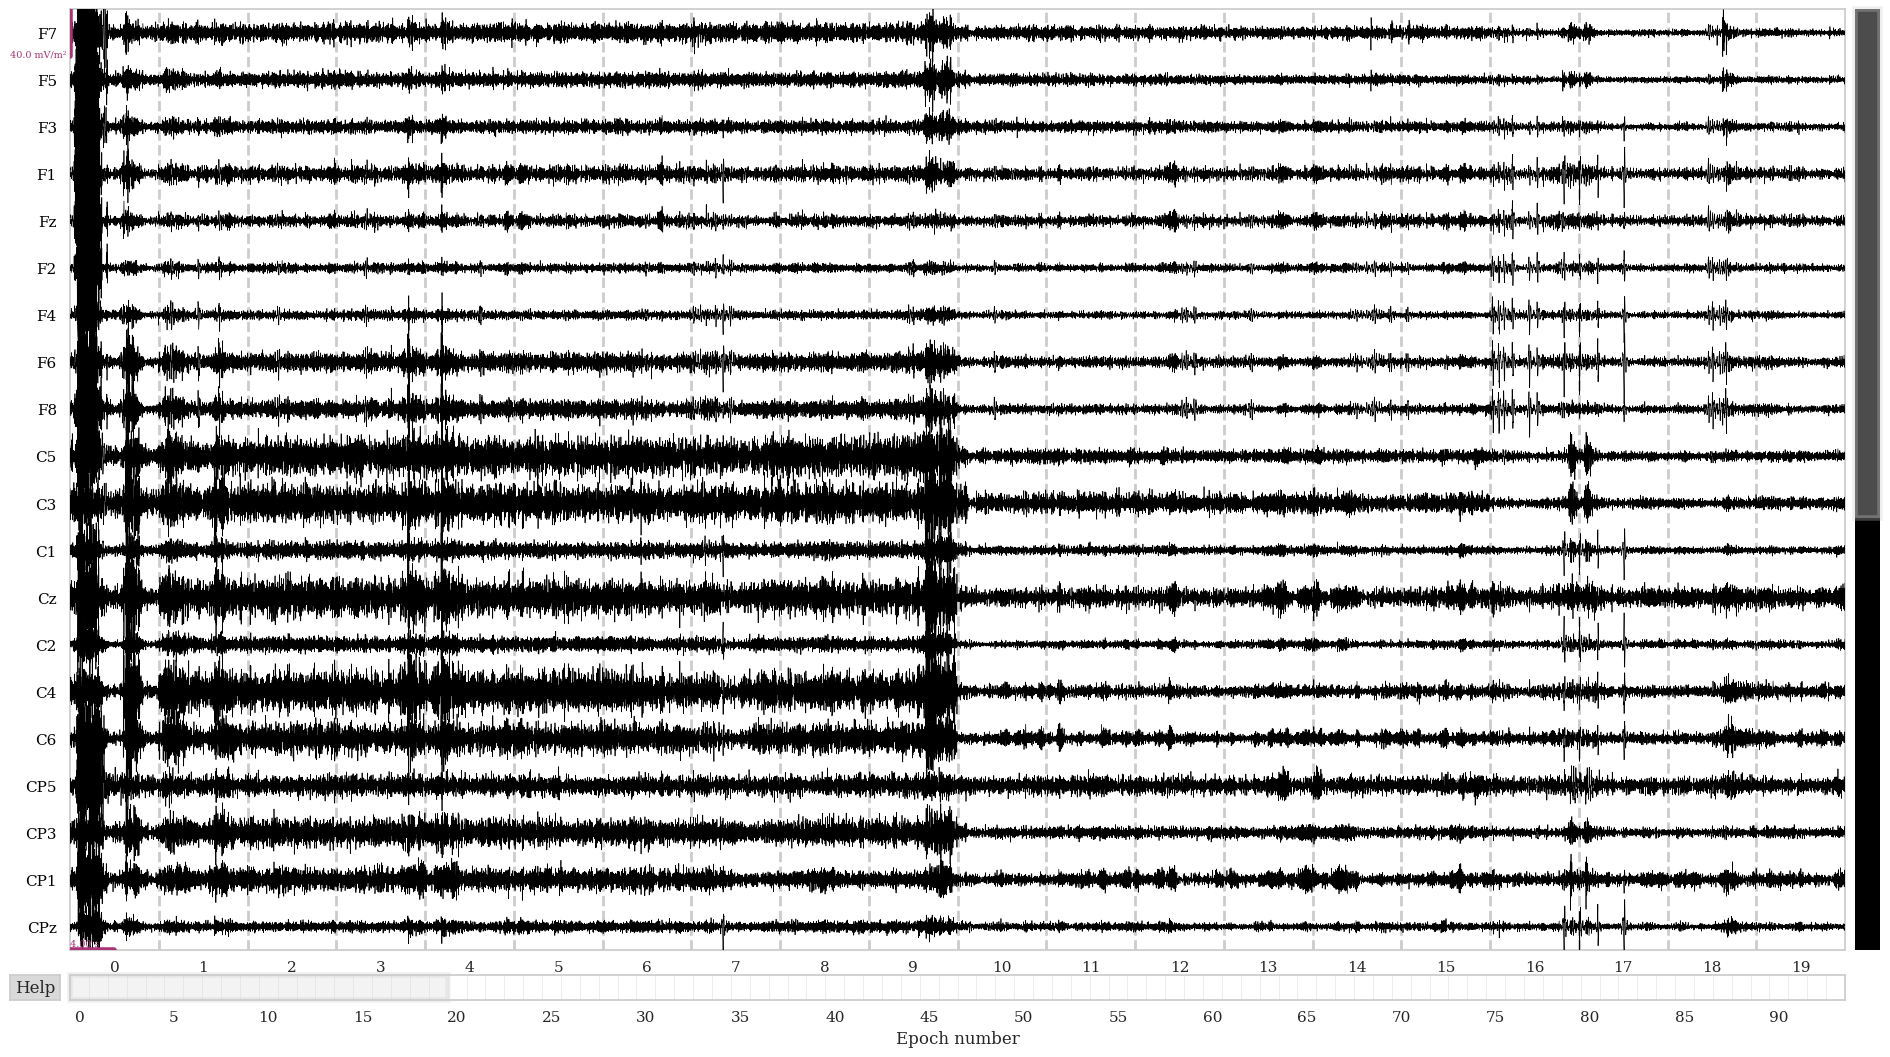

In [ ]:
# Assuming 'epochs' is your MNE Epochs object and it contains events named 'Left', 'Resting', 'Right'

centered_data_list = []
events_list = []

# Loop through each event ID
for idx, event_id in enumerate(desired_events):
    print (event_id)
    # Extract epochs for the current event
    event_epochs = epochs[event_id]
    event_data = event_epochs.get_data()
    
    # Calculate the mean across epochs for the current event
    mean_across_event_epochs = event_data.mean(axis=0)
    
    # Subtract the mean from each epoch of the current event
    centered_event_data = event_data - mean_across_event_epochs
    
    # Store the centered data
    centered_data_list.append(centered_event_data)
    
    # Prepare the events list and event_id_map for the combined EpochsArray
    events_list.append(event_epochs.events)

# Concatenate all centered data and events
centered_data = np.concatenate(centered_data_list, axis=0)
combined_events = np.concatenate(events_list, axis=0)

# Sort the combined events based on their original occurrence time to preserve the temporal sequence
sort_indices = np.argsort(combined_events[:, 0])
combined_events = combined_events[sort_indices]
centered_data = centered_data[sort_indices]

# Create a new EpochsArray with the centered data
centered_epochs = mne.EpochsArray(centered_data, epochs.info, events=combined_events, event_id=epochs.event_id, tmin=epochs.tmin)
centered_epochs.plot()
# Note: This code assumes event_ids are correctly listed and exist within the original epochs.
# You might need to adjust event_id_map or event IDs based on your specific dataset and requirements.

In [ ]:
data_to_predict=centered_epochs.copy().crop(tmin=1,tmax=3).get_data()[inds,:]
thresholded_prediction=trained_clf.decision_function(data_to_predict)
prediction=trained_clf.predict(data_to_predict)

IndexError: index 113 is out of bounds for axis 0 with size 94

In [ ]:
data_to_predict=centered_epochs.copy().crop(tmin=1,tmax=3).get_data()[:,:]
thresholded_prediction=trained_clf.decision_function(data_to_predict)
prediction=trained_clf.predict(data_to_predict)

In [ ]:
actual_events = get_epoch_events(epochs)  # Actual events from the epochs
predicted_events = np.array(prediction)  # Replace with your model predictions

# Compare actual events to predicted events
result = compare_events(actual_events, predicted_events)

# Output the comparison result
print(f"Accuracy: {result['accuracy']:.2f}")
if len(result['mismatches']) > 0:
    print("Mismatched epochs:")
    for mismatch in result['mismatches']:
        print(mismatch)
else:
    print("No mismatches!")

Accuracy: 0.77
Mismatched epochs:
3 - Rest (actual), OpenPalm (predicted)
4 - OpenPalm (actual), Rest (predicted)
6 - ClosePalm (actual), OpenPalm (predicted)
9 - OpenPalm (actual), ClosePalm (predicted)
18 - ClosePalm (actual), Rest (predicted)
28 - OpenPalm (actual), ClosePalm (predicted)
29 - Rest (actual), OpenPalm (predicted)
32 - ClosePalm (actual), OpenPalm (predicted)
37 - OpenPalm (actual), ClosePalm (predicted)
46 - OpenPalm (actual), ClosePalm (predicted)
48 - Rest (actual), OpenPalm (predicted)
49 - ClosePalm (actual), OpenPalm (predicted)
51 - OpenPalm (actual), ClosePalm (predicted)
55 - ClosePalm (actual), OpenPalm (predicted)
57 - Rest (actual), OpenPalm (predicted)
58 - ClosePalm (actual), OpenPalm (predicted)
78 - Rest (actual), OpenPalm (predicted)
80 - OpenPalm (actual), Rest (predicted)
82 - OpenPalm (actual), ClosePalm (predicted)
88 - OpenPalm (actual), ClosePalm (predicted)
90 - OpenPalm (actual), ClosePalm (predicted)
93 - OpenPalm (actual), ClosePalm (predicte

In [ ]:
# Define paths for data storage and processing
current_path = pathlib.Path().absolute()  
recording_path = current_path / 'Recordings'
figure_outputs_path=current_path / 'Figures'
hyper_param_search_output=current_path / 'hyper_param_search_outputs'
#extract all recorded files and subject names
recording_files = [f for f in listdir(recording_path) if isfile(join(recording_path, f)) and ('.xdf' in f)]
if not(figure_outputs_path.exists()):
    print('the output folder does not exists:  ',figure_outputs_path)

if not(hyper_param_search_output.exists()):
    print('the output folder does not exists:  ',hyper_param_search_output)


print('all available recording files',recording_files)
subject_names=[r.split('_')[0] for r in recording_files]
print('only subjects IDS:',subject_names)

# Initial definitions: 

print('filenames:\n',recording_files)
print('names:\n',subject_names)

Use_test_grid=False #change to False when you want to use the real grid_search and not a toy one: 

#define the electrode groups: the key can be anything, the values should be a list of electrodes
#define the electrode groups: the key can be anything, the values should be a list of electrodes
Electorde_Groups = {'FP': ['Fp1', 'Fp2'],
                   'AF': ['AF7', 'AF3', 'AFz', 'AF4', 'AF8'],
                   'F' : ['F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8'],
                   'FC': ['FC5', 'FC3', 'FC1', 'FC2', 'FC4', 'FC6'],
                   'C' : ['C5', 'C3', 'C1', 'Cz', 'C2', 'C4' ,'C6'],
                   'CP': ['CP5', 'CP3', 'CP1','CPz', 'CP2', 'CP4', 'CP6'],
                   'P' : ['P7', 'P5','P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8'],
                   'PO': ['PO7', 'PO3', 'POz', 'PO4', 'PO8'],
                   'O' : ['Oz', 'O2', 'O1', 'Iz']
                  } 

#define the grid search (dont go all at once because some params are not relevant to other params and might just increase running time: 
# i.e if using fbcsp, the n_components_grid paramater is not used, so if it has more than 1 value, it will run the fbcsp twice while changing a paramter that does not effect the calculation)
grid_search_dict=OrderedDict()
grid_search_dict={'filter_methods':['iir'], #['irr' or 'fir']
                'run_csd':[True, False],
                'pipeline_name':['csp+lda','ts+lda','fbcsp+lda'], #these classifiers pipelines are defined in "run_windowed_classification_on_fold"
                #things to do: filter bank csp + lda, csp+ts+lda
                'bandpass_borders_grid':[[7,32]], #each list defines the low and high cutoffs
                'Electorde_Groups_names_grid':['C','PO'], #each "name" refers to an elec group defined above
                'n_components_grid':[4], #the n component options for the csp classifier
                'n_components_fbcsp_grid':[2,3], # the n components options to use in the fbcsp classifier (n * filter_bank_bands)\
                'filters_bands':[[[8, 12], [12, 20], [20, 32]]],
                'epoch_tmins_and_maxes_grid':[[-3,5]], #times (sec: pre,post) for initial epoching (this should be the longest epoch as the windowed prediction will be tested on it)
                'classifier_training_windows_grid':[[1 , 2],[1,3]], #what times(sec: start,end) to use for the classifer training (data augmentation is also using this window)
                'augmentation_windows_grid':[[0,0],[0.5,0.5]], #referes to proportions (win_len,win_step) of sfreq, [1,1] means taking the classification epochs, and creating 1 second long epochs with 1 second long steps
                'windowed_prediction_params':[[0.5,0.1],[0.75,0.1],[1,0.1]]} #refers to prportions (win_len,win_step) of sfreq to try and predict i.e. 0.5 = half a second window, with a 100ms steps  

#here you can define a test grid (make it small so it wont take long, and use it to check that everything is working) 
test_grid_search_dict={'filter_methods':['fir'], #['irr' or 'fir']
                'run_csd':[True],
                'pipeline_name':['csp+lda'], #these classifiers pipelines are defined in "run_windowed_classification_on_fold
                #things to do: filter bank csp + lda, csp+ts+lda
                'bandpass_borders_grid':[[8,32]], #each list defines the low and high cutoffs
                'Electorde_Groups_names_grid':['C','PO'], #each "name" refers to an elec group defined above
                'n_components_grid':[4], #the n component options for the csp classifier
                'n_components_fbcsp_grid':[3], # the n components options to use in the fbcsp classifier (n * filter_bank_bands)
                'filters_bands':[[[8, 12], [12, 20], [20, 32]]],
                'epoch_tmins_and_maxes_grid':[[-3,5]], #times (sec: pre,post) for initial epoching (this should be the longest epoch as the windowed prediction will be tested on it)
                'classifier_training_windows_grid':[[0,2]], #what times(sec: start,end) to use for the classifer training (data augmentation is also using this window)
                'augmentation_windows_grid':[[1,0.1]], #referes to proportions (win_len,win_step) of sfreq, [1,1] means taking the classification epochs, and creating 1 second long epochs with 1 second long steps
                'windowed_prediction_params':[[1,0.1]]} #refers to prportions (win_len,win_step) of sfreq to try and predict i.e. 0.5 = half a second window, with a 100ms steps  

if Use_test_grid: 
   print('\n######\nusing a test grid search\n######\n')
   grid_search_dict=test_grid_search_dict

all_options=[list(range(len(val))) for key,val in grid_search_dict.items()]
print(f'grid options {all_options}')
# Get all possible grid_search combinations: 
all_grid_combinations = list(itertools.product(*all_options))
print(f'number of grid search iterations: {len(all_grid_combinations)}')
print('Grid info:',grid_search_dict)
#save the hyper_grid_search: 
with open(hyper_param_search_output/'grid_search_info.json', 'w') as file:
    json.dump(grid_search_dict, file)
    
# Define what electrodes should be excluded 
def get_subject_bad_electrodes(subject):
    elecs_to_drop={}
    #define here the subject specific electdodes to make sure are removed from the data: 
    bad_elecs_dict={'Dekel':{'FT10', 'TP10', 'FT9'},
                    'Gilad':{'FT10', 'TP10', 'FT9', 'TP9'},
                    'Neta':{'TP9'},
                    'Ron-Block':{'PO7'},
                    'sub-Roei': {'TP9'}}
    if subject in bad_elecs_dict.keys():
        subject_bad_electrodes=bad_elecs_dict[subject]
    else: 
        subject_bad_electrodes={}
        print('note that no bad electrodes were defined for the current subject:',subject)
    return subject_bad_electrodes   
    
def set_up_params_for_current_grid_iteration(all_grid_combinations,iteration_ind,grid_search_dict):
    curr_grid_comb=all_grid_combinations[iteration_ind]
    print(f'setting up current params: iteration {iteration_ind} - grid settings: {curr_grid_comb}')
    #create a dictionary from the current grid combination (note that the dictionary is ordered): 
    iteration_dictionary={key:val[inner_ind] for ((key,val),inner_ind) in zip(grid_search_dict.items(),curr_grid_comb)}
   
    #extract the paramaters for the current iteration: 
    LowPass=iteration_dictionary['bandpass_borders_grid'][0]
    HighPass=iteration_dictionary['bandpass_borders_grid'][1]
    PerformCsd=iteration_dictionary['run_csd']
    filter_method=iteration_dictionary['filter_methods']

    #extract current electrodes (allow for combination of electrode groups i.e 'C+AF+F')
    Electorde_Group_name=iteration_dictionary['Electorde_Groups_names_grid'] #['FP', 'AF', 'F', 'FC', 'C', 'CP', 'P', 'PO', 'O']
    Electorde_Group=[]
    for cur_elec_group_name in Electorde_Group_name.split('+'):
        Electorde_Group=Electorde_Group+Electorde_Groups[cur_elec_group_name]
    classifier_window_s=iteration_dictionary['classifier_training_windows_grid'][0]
    classifier_window_e=iteration_dictionary['classifier_training_windows_grid'][1]
    epoch_tmin=iteration_dictionary['epoch_tmins_and_maxes_grid'][0]
    epoch_tmax=iteration_dictionary['epoch_tmins_and_maxes_grid'][1]
    n_components=iteration_dictionary['n_components_grid']
    n_components_fbcsp=iteration_dictionary['n_components_fbcsp_grid']
    #define the current augmentation paramaters to test: note that they are defined by samples
    augmentation_params={'win_len':iteration_dictionary['augmentation_windows_grid'][0],
                        'win_step':iteration_dictionary['augmentation_windows_grid'][1]}
    #define the windowed prediction paramaters: #here they are defined as proportions of the sampling frequency
    windowed_prediction_params={'win_len':iteration_dictionary['windowed_prediction_params'][0],
                                'win_step':iteration_dictionary['windowed_prediction_params'][1]}
    #get the current pipeline name: 
    pipeline_name=iteration_dictionary['pipeline_name']
    filters_bands=iteration_dictionary['filters_bands']                          
    #set paramaters dict for current run: 
    params_dict={'LowPass': LowPass,
                'HighPass': HighPass,
                'PerformCsd':PerformCsd,
                'filter_method':filter_method,
                'n_components':n_components,
                'n_components_fbcsp':n_components_fbcsp,
                'filters_bands':filters_bands,
                'Electorde_Group':Electorde_Group,
                'Electorde_Group_name':Electorde_Group_name,
                'epoch_tmin':epoch_tmin,
                'epoch_tmax':epoch_tmax,
                'classifier_window_s':classifier_window_s,
                'classifier_window_e':classifier_window_e,
                'augmentation_params':augmentation_params,
                'windowed_prediction_params':windowed_prediction_params,
                'pipeline_name':pipeline_name}

    return params_dict

# Need to define a preprocessing function that can accept several participant files and add them to a single structure
def run_pre_processing_extract_validation_set(recording_path,current_path,params_dict):

    #extract the current run paramaters: 
    Subject=params_dict['subject']
    PerformCsd=params_dict['PerformCsd']
    LowPass, HighPass, filter_method = params_dict['LowPass'],params_dict['HighPass'],params_dict['filter_method']
    tmin=params_dict['epoch_tmin']
    tmax=params_dict['epoch_tmax']

    #read the file:
    Raw=read_raw_xdf(recording_path / params_dict['recording_file'])
    #remove non existent channels: 
    if 'ACC_X' in Raw.ch_names:
        Raw.drop_channels(['ACC_X','ACC_Y','ACC_Z']) ## Drop non eeg channels
    #set the correct (Brainvision Montage) montage:
    montage = mne.channels.read_custom_montage((f"{current_path}\Montages\CACS-64_REF.bvef"), head_size=0.095, coord_frame=None) 
    #rename channels for consistency (no longer required for future recordings): 
    #mne.rename_channels(Raw.info, {'F9' : 'FT9','P9' : 'TP9','P10' : 'TP10','F10' : 'FT10','AF1' : 'AF7' }, allow_duplicates=False, verbose=None)
    Raw.set_montage(montage, match_case=True, match_alias=False, on_missing='raise', verbose=None)

    print('\n###########################################################')
    print('removing subject specific bad electrodes from the raw data')
    #drop bad electrodes according to the current subject name: 
    print('\n###########################################################')
    print('removing bad channels from epochs:')
    curr_elecs_in_epochs_set=set(Raw.info['ch_names'])
    elecs_to_remove=get_subject_bad_electrodes(Subject)
    elecs_to_drop=curr_elecs_in_epochs_set.intersection(elecs_to_remove)

    if len(elecs_to_drop)>0: 
        Raw.drop_channels(list(elecs_to_drop))
    Raw.drop_channels(Raw.info['bads'])

    # Do csd: 
    if (PerformCsd):
        print('\n###########################################################')
        print('running csd')
        Raw_CSD = mne.preprocessing.compute_current_source_density(Raw) ## Compute CSD
    else :
        print('\n###########################################################')
        print('not using csd')
        mne.set_eeg_reference(Raw, copy=False)
        Raw_CSD =Raw
    print('\n###########################################################')
    print('filtering the data')  
   # Raw_CSD.pick= (params_dict['Electorde_Group'])
    unfiltered_Raw_CSD=Raw_CSD.copy()
    Raw_CSD_Filtered = unfiltered_Raw_CSD.filter(LowPass, HighPass, method=filter_method)

    #extract filterbank feequencies:
    filters_bands=tuple(params_dict['filters_bands'])
    filtered_data_band_passed=[]
    for i,(LowPass,HighPass) in enumerate(filters_bands):
        unfiltered_Raw_CSD=Raw_CSD.copy()
        Raw_CSD_Filtered_band= mne.filter.filter_data(unfiltered_Raw_CSD.get_data(),sfreq=500, l_freq=LowPass, h_freq=HighPass, method='fir',copy = True)
        filtered_data_band_passed.append(Raw_CSD_Filtered_band)

    events_from_annot,event_dict = mne.events_from_annotations(Raw_CSD_Filtered)
    print('\n###########################################################')
    print('extracting event info:',event_dict)
    # Select relevant events for epoching
    desired_events = ['ActiveRest','Rest','ClosePalm','OpenPalm'] 
    events_trigger_dict = {key: event_dict[key] for key in event_dict.keys() if key in desired_events}
    print('\n###########################################################')
    selected_elecs=params_dict['Electorde_Group']

    #filter bank related: 
    filter_bank_epochs=[]
    for filtered_data_band in filtered_data_band_passed:
        filtered_data_band_raw = mne.io.RawArray(filtered_data_band,unfiltered_Raw_CSD.info)
        epochs = mne.Epochs(filtered_data_band_raw, events_from_annot, picks = params_dict['Electorde_Group'], preload = True,baseline= None, tmin=tmin, tmax=tmax, event_id=events_trigger_dict,detrend=0)
        filter_bank_epochs.append(epochs)

    print(f'epoching + selecting current electodes set for analysis:\n{selected_elecs}')
    epochs = mne.Epochs(Raw_CSD_Filtered, events_from_annot,picks = params_dict['Electorde_Group'], preload = True,baseline= None, tmin=tmin, tmax=tmax, event_id=events_trigger_dict,detrend=0)
    
    ## Centering the data

    centered_data_list = []
    events_list = []
    mean_across_epochs = epochs.get_data().mean(axis=0)
    # Loop through each event ID
    for idx,event_id in enumerate(desired_events):
        print (event_id)
        # Extract epochs for the current event
        event_epochs = epochs[event_id]
        event_data = event_epochs.get_data()
        
        # Calculate the mean across epochs for the current event
        mean_across_event_epochs = event_data.mean(axis=0)
        
        # Subtract the mean from each epoch of the current event
        centered_event_data = event_data - mean_across_event_epochs
        
        # Store the centered data
        centered_data_list.append(centered_event_data)
        
        # Prepare the events list and event_id_map for the combined EpochsArray
        events_list.append(event_epochs.events)

    # Concatenate all centered data and events
    centered_data = np.concatenate(centered_data_list, axis=0)
    combined_events = np.concatenate(events_list, axis=0)

    # Sort the combined events based on their original occurrence time to preserve the temporal sequence
    sort_indices = np.argsort(combined_events[:, 0])
    combined_events = combined_events[sort_indices]
    centered_data = centered_data[sort_indices]

    # Create a new EpochsArray with the centered data
    centered_epochs = mne.EpochsArray(centered_data, epochs.info, events=combined_events, event_id=epochs.event_id, tmin=epochs.tmin)
    epochs = centered_epochs



    #this section drops electrodes after epoching: but currently we drop all bad electrodes from the raw data
    print('\n###########################################################')
    print('removing bad channels from epochs:')
    curr_elecs_in_epochs_set=set(epochs.info['ch_names'])
    elecs_to_remove=get_subject_bad_electrodes(Subject)
    elecs_to_drop=curr_elecs_in_epochs_set.intersection(elecs_to_remove)

    if len(elecs_to_drop)>0:
        epochs.info['bads']=elecs_to_drop
        epochs.drop_channels(epochs.info['bads'])
        print('\n###########################################################')
        print(f'Removed: {elecs_to_drop} from the current selected electrodes: {curr_elecs_in_epochs_set} from the overall set of bad electrodes {elecs_to_remove}')
        print('#############################################################')
    
        #filter bank related: 
        filter_bank_epochs_after_elec_drops=[]
        for curr_epochs in filter_bank_epochs:
            curr_epochs.info['bads']=elecs_to_drop
            curr_epochs.drop_channels(epochs.info['bads'])
            filter_bank_epochs_after_elec_drops.append(curr_epochs)    
    else: 
        #filter bank related: 
        filter_bank_epochs_after_elec_drops=[]
        for curr_epochs in filter_bank_epochs:
            filter_bank_epochs_after_elec_drops.append(curr_epochs)  

        print('\n###########################################################')
        print(f'the current selected electrodes: {curr_elecs_in_epochs_set} allready exclude the requested electrodes to remove {elecs_to_remove}')
        print('#############################################################')

    #extract the validation set: we will use it only after selecting all hyper paramaters to get a better representation of out-of-sample performence: 
    #using a very small test size as we currently mostly look at the CV scores: 
    data_df=pd.DataFrame(data=epochs.events[:, -1], columns=['label'] ,index=range(len(epochs.events[:, -1])))
    data_df['original_trial_ind']=range(len(epochs.events[:, -1]))
    train,validation=train_test_split(data_df,shuffle=True,random_state=42,stratify=data_df['label'],test_size=0.2)
 
    train_inds=train['original_trial_ind'].values
    validation_inds=validation['original_trial_ind'].values
    print(f'putting aside 20% of the data: trial numbers are:\n {validation_inds}\n')
    print(f'remaining 80% of the trials go into training for cv:\n {train_inds}\n')

    return_dict={'train_inds':train_inds,
                'validation_inds':validation,
                'epochs':epochs,
                'filter_bank_epochs':filter_bank_epochs_after_elec_drops,
                'events_triggers_dict':events_trigger_dict}
    return train_inds,validation_inds,return_dict,mean_across_epochs

def crop_the_data(epochs,train_inds,validation_inds,full_epoch_tmin=0,full_epoch_tmax=5,tmin=1,tmax=2):
    #returns a dictionary containing the cropped and uncropped versions of the validation and training epochs.
    tmin=float(tmin)
    tmax=float(tmax)
    #save uncropped versions of the data: 
    #save the training data:
    train_set_data_uncroped=epochs.get_data()[train_inds]
    train_set_labels_uncroped=epochs.events[train_inds,-1]

    #save the validation data: 
    validation_set_data_uncroped=epochs.get_data()[validation_inds]
    validation_Set_labels_uncroped=epochs.events[validation_inds,-1]

    #crop the epochs (use the epochs structure)
    epochs_cropped = epochs.copy().crop(tmin=full_epoch_tmin, tmax=full_epoch_tmax)

    #from here on - we extract the data as matrices (not epoch object anymore):

    #save the training data:
    train_set_data=epochs_cropped.get_data()[train_inds]
    train_set_labels=epochs_cropped.events[train_inds,-1]

    #save the validation data: 
    validation_set_data=epochs_cropped.get_data()[validation_inds]
    validation_set_labels=epochs_cropped.events[validation_inds,-1]

    return_dict={'train_set_data_uncroped':train_set_data_uncroped,
                'train_set_labels_uncroped':train_set_labels_uncroped,
                'validation_set_data_uncroped':validation_set_data_uncroped,
                'validation_Set_labels_uncroped':validation_Set_labels_uncroped,
                'epochs_cropped':epochs_cropped,
                'train_set_data':train_set_data,
                'train_set_labels':train_set_labels,
                'validation_set_data':validation_set_data,
                'validation_set_labels':validation_set_labels}
    return return_dict

def plot_accuracy_over_time(scores_windows,w_times,params_dict,axes_handle):
    #this function accepts the scores windows (a list of n folds - each giving a score on a time window)
    #it converts it to a long dataframe with the following columns: fold_id,Time,Accuracy
    #then it uses the long format to plot using seaborn lineplot and get a confidence interval
    times_col_names=[np.round(w_times[s],2) for s in range(len(w_times))]
    scores_windows_array=np.squeeze(np.array(scores_windows))
    scores_windows_df=pd.DataFrame(columns=times_col_names,data=scores_windows_array)
    scores_windows_df['fold_id']=range(len(scores_windows_df))
    longform_scores_windows_df=pd.melt(scores_windows_df, id_vars='fold_id', value_vars=scores_windows_df.columns)
    longform_scores_windows_df.rename(columns={'variable':'Time','value':'Accuracy'},inplace=True)
    sns.lineplot(data=longform_scores_windows_df,x='Time',y='Accuracy',ax=axes_handle)

    if any(w_times>0):
        onset_location=np.round(w_times[w_times>=0][0],2) ## find the onest (assuming 0 in epoch time)
        axes_handle.axvline(onset_location, linestyle='--', color='k', label='Onset') 
    axes_handle.axhline(0.5, linestyle='-', color='k', label='Chance') #Need to adjust to multiple classes cases
    axes_handle.set_xlabel('time (s)')
    axes_handle.set_ylabel('classification accuracy')
    axes_handle.set_title('Classification score over time')
    axes_handle.set_ylim([0.25, 1])
    
def run_windowed_classification_on_fold(fold_train_data_x,fold_train_data_y,fold_test_data_x_uncroped,fold_test_data_y,params_dict,w_start,w_length, BinaryClassification = False):
    #note that this is currently the  function that really does the classification and extracts the performence measure (the previous calls to run_lda.... for example, are just tests)
    curr_classifier_name=params_dict['pipeline_name']
    if curr_classifier_name=='csp+lda':  
        #define the classifier components:  
        lda = LinearDiscriminantAnalysis()
        csp = CSP(n_components=params_dict['n_components'], reg=None, log=True, norm_trace=False)
        #define the pipeline: 
        clf = Pipeline([('csp',csp),('classifier_LDA',lda)])
    elif curr_classifier_name=='csp+svm':
        #define the classifier components:  
        csp = CSP(n_components=params_dict['n_components'], reg=None, log=True, norm_trace=False)
        #define the pipeline: 
        clf = Pipeline([('csp',csp), ('ovo_svm', OneVsOneClassifier(SVC(kernel='linear', random_state=42)))])
    elif curr_classifier_name=='ts+lda':
        #define the classifier components:  
        covest = Covariances()
        ts = TangentSpace()
        lda = LinearDiscriminantAnalysis()
        #define the pipeline: 
        clf = Pipeline([('conv',covest),('ts', ts), ('LDA', lda)])
    elif curr_classifier_name=='fbcsp+lda':
        #define the classifier components: 
        lda = LinearDiscriminantAnalysis()
        csp = CSP(n_components=params_dict['n_components_fbcsp'], reg=None, log=True, norm_trace=False)
        fb=FilterBank(csp)
        #define the pipeline: 
        clf = Pipeline([('fbcsp',fb),('classifier_LDA',lda)])
    else: 
        raise Exception(f'the requested classifier is not defined in "run_windowed_classification_on_fold": {curr_classifier_name}')
    
    #get string labels instead of numeric (so the classifier will have an informative clf.classes_ )
    triggers_label_dict={val:key for key,val in params_dict['preprocessing_dict']['events_triggers_dict'].items()} 
    fold_train_data_y_labels=np.array([triggers_label_dict[cur_y] for cur_y in fold_train_data_y])  
    A, B  = 'OpenPalm', 'ClosedPalm'  # Replace with actual trigger names/values
    combined_labels_train = np.array(['motor_imagery' if label in [A, B] else 'rest' for label in fold_train_data_y_labels])
    #fit the selected classifier: 
    
    

    if BinaryClassification:
        clf.fit(fold_train_data_x, combined_labels_train)
    else:
        clf.fit(fold_train_data_x, fold_train_data_y_labels)
    # running classifier: test classifier on sliding window

    #get string labels instead of numeric for the test
    fold_test_data_y_labels=np.array([triggers_label_dict[cur_y] for cur_y in fold_test_data_y])
    if BinaryClassification:
        combined_labels_test = np.array(['motor_imagery' if label in [A, B] else 'rest' for label in fold_test_data_y_labels])

        fold_windowed_scores,confusion_metrices_per_window=run_windowed_pretrained_classifier(clf,fold_test_data_x_uncroped,combined_labels_test,w_start,w_length)
    else:
        fold_windowed_scores,confusion_metrices_per_window=run_windowed_pretrained_classifier(clf,fold_test_data_x_uncroped,fold_test_data_y_labels,w_start,w_length)
    return fold_windowed_scores,confusion_metrices_per_window,clf

def run_windowed_pretrained_classifier(clf,x_uncropped,y,w_start,w_length):
    scores_per_time_window = []
    confusion_metrices_per_window=[]
    if len(x_uncropped.shape)==3: #reshape it as if it was a 4d matrix (assuming the 4th dimention is the filterbank)
        x_uncropped=x_uncropped.reshape(list(x_uncropped.shape)+[1])
    for n in w_start:
        fold_data=np.squeeze(x_uncropped[:, :, n:(n + w_length),:]) #using squeeze here so that if the 4th dimention size is 1 it will reduce it to a 3d vector
        #if the classifier uses a filterbank its input should be 4d (trials,channels,timesteps,filter_bands) and if it doesnt its 3d (trials,channels,timesteps)
        fold_score_on_time_window=clf.score(fold_data, y)
        #append the score for the LDA, using this csp to predict the relevant test scores: 
        scores_per_time_window.append(fold_score_on_time_window)
        confusion_mat=confusion_matrix(y,clf.predict(fold_data),labels=clf.classes_)
        confusion_metrices_per_window.append(confusion_mat)
    return scores_per_time_window,confusion_metrices_per_window

def augment_data(augmentation_params,data_x_to_augment,y,sfreq):
    #do augmentation: 
    if (augmentation_params['win_step']==0 or augmentation_params['win_len']==0): #check if augmentation is not requested/invalid:
        augmented_x=data_x_to_augment
        augmented_y=y
    else: #augmentation requested
        #set up the augmentation window boundaries based on the augmentation paramaters:                      
        aug_epochs_s=np.arange(0,data_x_to_augment.shape[2],augmentation_params['win_step']*sfreq)
        aug_epochs_e=np.array([a+augmentation_params['win_len']*sfreq for a in aug_epochs_s])
        #remove start and ends that exceeds the relevant epoch lengths: 
        aug_epochs_s=aug_epochs_s[aug_epochs_e<data_x_to_augment.shape[2]]
        aug_epochs_e=aug_epochs_e[aug_epochs_e<data_x_to_augment.shape[2]]

        #pile all augmented (sub windows) to have the regular structure of epochs (>original due to augmentation,channels,samples)
        data_fold_x_augmented=[]
        data_fold_y_augmented=[]
        for aug_s,aug_e in zip(aug_epochs_s,aug_epochs_e):
            if len(data_x_to_augment.shape)==3:
                data_x_in_cur_window=data_x_to_augment[:,:,int(aug_s):int(aug_e)]
            elif len(data_x_to_augment.shape)==4: #with filterbank: 
                data_x_in_cur_window=data_x_to_augment[:,:,int(aug_s):int(aug_e),:]
            data_y_in_cur_window=y
            data_fold_x_augmented.append(data_x_in_cur_window)
            data_fold_y_augmented.append(data_y_in_cur_window)

        augmented_x=np.concatenate(data_fold_x_augmented,axis=0)
        augmented_y=np.concatenate(data_fold_y_augmented)
    return augmented_x,augmented_y

def run_windowed_classification_aug_cv(epochs_cropped,cv_split,train_set_data,train_set_labels,train_set_data_uncroped,params_dict, BinaryClassification):
    augmentation_params=params_dict['augmentation_params']
    windowed_prediction_params=params_dict['windowed_prediction_params']
    win_len=windowed_prediction_params['win_len']
    win_step=windowed_prediction_params['win_step']
    
    sfreq = epochs_cropped.info['sfreq']
    w_length = int(sfreq * win_len)   # running classifier: window length
    w_step = int(sfreq * win_step)  # running classifier: window step size
    w_start = np.arange(0, train_set_data_uncroped.shape[2] - w_length, w_step)
    print('uncroped train set length = ',train_set_data_uncroped.shape[2])

    scores_windows = []
    folds_confusion_metrices_per_window=[]
    #this section first extracts each CV fold, only then it augments it (to avoid data leakage)
    for train_idx, test_idx in cv_split:
        #seperate the cv fold for labels - train-test:
        y_train, y_test = train_set_labels[train_idx], train_set_labels[test_idx] 
        #seperate the cv fold for features information: 
        if len(train_set_data.shape)==3:
            data_fold_x_train_to_augment = train_set_data[train_idx,:,:]
        elif len(train_set_data.shape)==4: #there are filter bank info in the data: 
            data_fold_x_train_to_augment = train_set_data[train_idx,:,:,:] 
        #do augmentation: 
        augmented_x,augmented_y=augment_data(augmentation_params,data_fold_x_train_to_augment,y_train,sfreq)
        #run classifier on the data fold
        curr_scores_windows,confusion_metrices_per_window,_=run_windowed_classification_on_fold(augmented_x,augmented_y,train_set_data_uncroped[test_idx],y_test,params_dict,w_start,w_length, BinaryClassification)         
        scores_windows.append(curr_scores_windows)
        folds_confusion_metrices_per_window.append(confusion_metrices_per_window)
    w_times = (w_start + w_length / 2.) / sfreq + params_dict['epoch_tmin']
    return scores_windows,folds_confusion_metrices_per_window,w_times

def run_windowed_classification_aug(epochs_cropped,train_set_data,train_set_labels,train_set_data_uncroped,test_y,params_dict,BinaryClassification):
    augmentation_params=params_dict['augmentation_params']
    windowed_prediction_params=params_dict['windowed_prediction_params']
    win_len=windowed_prediction_params['win_len']
    win_step=windowed_prediction_params['win_step']
    sfreq = epochs_cropped.info['sfreq']
    w_length = int(sfreq * win_len)   # running classifier: window length
    w_step = int(sfreq * win_step)  # running classifier: window step size
    w_start = np.arange(0, train_set_data_uncroped.shape[2] - w_length, w_step)
    w_times = (w_start + w_length / 2.) / sfreq + params_dict['epoch_tmin']

    augmented_x,augmented_y=augment_data(augmentation_params,train_set_data,train_set_labels,sfreq)
    scores_windows,confusion_metrices_per_window,trained_clf=run_windowed_classification_on_fold(augmented_x,augmented_y,train_set_data_uncroped,test_y,params_dict,w_start,w_length, BinaryClassification)         

    return scores_windows,confusion_metrices_per_window,w_times,trained_clf

def run_training_and_classification_on_selected_params(params_dict,preprocessing_dict, BinaryClassification = False ,to_plot=False,figure_outputs_path='',fig_name='temp'):
    epochs_copy=preprocessing_dict['epochs']
    train_inds=preprocessing_dict['train_inds']
    validation_inds=preprocessing_dict['validation_inds']['original_trial_ind'].values

    #crop the data according to the training window: 
    returned_dict=crop_the_data(epochs_copy,train_inds,validation_inds,params_dict['classifier_window_s'],params_dict['classifier_window_e']) #two more paramters here are tmin and tmax which are not used apparently. 
    train_set_data_uncropped=returned_dict['train_set_data_uncroped']
    epochs_cropped=returned_dict['epochs_cropped']
    train_set_data=returned_dict['train_set_data']
    train_set_labels=returned_dict['train_set_labels']

    validation_set_labels=returned_dict['validation_set_labels']
    validation_set_data_uncropped=returned_dict['validation_set_data_uncroped']
    #define cv on the data: 
    cv = StratifiedShuffleSplit(10, test_size=0.2, random_state=42)
    cv_split = cv.split(train_set_data,train_set_labels)

    #filter bank related:
    if params_dict['pipeline_name']=='fbcsp+lda': 
        train_set_data_fb=[]
        train_set_data_uncropped_fb=[]
        validation_set_data_fb=[]
        validation_set_data_uncropped_fb=[]
        for filtered_data_band_epoch in preprocessing_dict['filter_bank_epochs']:
            returned_dict_temp=crop_the_data(filtered_data_band_epoch,train_inds,validation_inds, params_dict['classifier_window_s'],params_dict['classifier_window_e'])
            #extract the train set data: 
            train_set_data_uncroped_temp=returned_dict_temp['train_set_data_uncroped']
            train_set_data_temp=returned_dict_temp['train_set_data']
            train_set_data_fb.append(train_set_data_temp)
            train_set_data_uncropped_fb.append(train_set_data_uncroped_temp)
            #extract the validation set data: 
            validation_set_data_uncroped_temp=returned_dict_temp['validation_set_data_uncroped']
            validation_set_data_temp=returned_dict_temp['validation_set_data']
            validation_set_data_fb.append(validation_set_data_temp)
            validation_set_data_uncropped_fb.append(validation_set_data_uncroped_temp)
        #create a 4d matrix of train data:     
        train_set_data_4d_array= np.transpose(np.array(train_set_data_fb),(1,2,3,0))
        train_set_data_uncropped_4d_array=np.transpose(np.array(train_set_data_uncropped_fb),(1,2,3,0)) 
        train_set_data=train_set_data_4d_array
        train_set_data_uncropped=train_set_data_uncropped_4d_array
        #create a 4d matrix of validation data: 
        validation_set_data_4d_array= np.transpose(np.array(validation_set_data_fb),(1,2,3,0))
        validation_set_data_uncropped_4d_array=np.transpose(np.array(validation_set_data_uncropped_fb),(1,2,3,0)) 
        validation_set_data_uncropped=validation_set_data_uncropped_4d_array

    #get scores over time using CV: 
    scores_windows,folds_confusion_metrices_per_window,w_times=run_windowed_classification_aug_cv(epochs_cropped,cv_split,train_set_data,train_set_labels,train_set_data_uncropped,params_dict, BinaryClassification)
    
    #train the classifier based on ALL training data, and test its prediction on the unseen validation set: 
    validaiton_scores,validation_confusion_metrices_per_window,_,trained_clf=run_windowed_classification_aug(epochs_cropped,train_set_data,train_set_labels,validation_set_data_uncropped,validation_set_labels,params_dict, BinaryClassification)
    if to_plot:
        fig,axes=plt.subplots(nrows=1,ncols=2)
        plot_accuracy_over_time(scores_windows,w_times,params_dict,axes_handle=axes[0])
        epochs_copy.plot_sensors(show_names=True,axes=axes[1])
        figname=fig_name + '.svg'
        fig.savefig(figure_outputs_path / figname)
    else:
        fig=[]
    return fig,w_times,scores_windows,folds_confusion_metrices_per_window,validaiton_scores,validation_confusion_metrices_per_window,trained_clf

def run_grid_search_on_single_participant(grid_search_dict,recording_file,Subject,save_every_n_iter,save_location_path,to_plot=True):
    all_options=[list(range(len(val))) for key,val in grid_search_dict.items()]
    #get all possible grid_search combinations: 
    all_grid_combinations = list(itertools.product(*all_options))
    print(f'number of grid search iterations: {len(all_grid_combinations)}')

    grid_search_data_frame_info=pd.DataFrame()
    print('running grid search on:',recording_file)
    #put all in a single params_dictionary for the current run: 
    #run all grid_search iterations: 
    for iteration_ind in tqdm(range(len(all_grid_combinations))):
        #extract current iteration paramaters:
        params_dict=set_up_params_for_current_grid_iteration(all_grid_combinations,iteration_ind,grid_search_dict)
        
        #add subject specific information: 
        params_dict['recording_file']=recording_file
        params_dict['subject']=Subject
        print(f'test iteration: dictionary paramaters: {params_dict}')
        #run preprocessing:
        train_inds,validation_inds,preprocessing_dict,mean_across_epochs=run_pre_processing_extract_validation_set(recording_path,current_path,params_dict)
        #run prediction on cross validation:
        fig,w_times,scores_windows,validation_scores=run_training_and_classification_on_selected_params(params_dict,preprocessing_dict,to_plot=to_plot,figure_outputs_path=figure_outputs_path,fig_name='test')
        #train the model on all the training data: 
        #   tbd
        #run prediction on the validation set(?)
        #   tbd
        #add scores related information: 
        curr_params_df=pd.DataFrame([params_dict],index=[iteration_ind])
        curr_params_df['mean_scores']=np.nan
        curr_params_df['std_scores']=np.nan
        curr_params_df['mean_scores']=curr_params_df['mean_scores'].astype(object)
        curr_params_df['std_scores']=curr_params_df['mean_scores'].astype(object)
        curr_params_df['mean_scores']=[np.mean(scores_windows,axis=1)]
        curr_params_df['std_scores']=[np.std(scores_windows,axis=1)]
        grid_search_data_frame_info=pd.concat([grid_search_data_frame_info,curr_params_df],axis=0)
        df_name='hypter_param_search_' + recording_file.split('.')[0] + '.csv'
        if np.mod(iteration_ind,save_every_n_iter)==0:
            print('saving')
            grid_search_data_frame_info.to_csv(hyper_param_search_output / df_name)

    #save all grid_search results: 
    grid_search_data_frame_info.to_csv(hyper_param_search_output / df_name)
    return grid_search_data_frame_info

def plot_precision_recall_curves_from_trained_classifier(preprocessing_dict,params_dict,precision_recall_curve_timerange,trained_clf,predict_validation=True):
    #to learn on precision recall curves see :https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html 
    #the code is adapated for our usage: 
    #prepreocessing_dict - dictionary that contains the {original epoched data, and the training/validation indexes}
    #params_dict - dictionary that contains the prediction paramaters
    #precision_Revall_curve_timerange - list #in seconds relative to epoch (so if epoch is -3 to +4, 3-4 will take the last second in the epoch )
    #trained_clf - the classifier that was previously trained on all the data: (note that this means that the report here is biased (better than really is))
    #predict_validation - true - will use only validation indexes, false - will use only training indexes (much more biased ofcourse) 
    
    #define what time_range you want to extract the recall/precision for: 
    print(f'chosen window prediction range is {precision_recall_curve_timerange}\nnote that the prediction paramaters (that the classifier is trained on) are: {params_dict["windowed_prediction_params"]}\nconsider if you want the preciction range to match the prediction_param')
    
    #decide if we use the training or the validation set to plot: 
    if predict_validation: 
    #get the relevant data for the validation set: 
        inds=preprocessing_dict['validation_inds']['original_trial_ind'].values
    else:
        inds=preprocessing_dict['train_inds']


    #extract the labels: 
    labels=preprocessing_dict['epochs'].events[inds, -1]
    #extract the decision function: 

    #fbcsp
    if params_dict['pipeline_name']=='fbcsp+lda':
        data_set_fb = []
        for filtered_data_band_epoch in preprocessing_dict['filter_bank_epochs']:
            temp_data = filtered_data_band_epoch.copy().crop(tmin=precision_recall_curve_timerange[0],tmax=precision_recall_curve_timerange[1]).get_data()[:]
            data_set_fb.append(temp_data)
        data_set_fb_4d_array= np.transpose(np.array(data_set_fb),(1,2,3,0))
        decision_function=trained_clf.decision_function((data_set_fb_4d_array)[inds,:])
    else:
            decision_function=trained_clf.decision_function(preprocessing_dict['epochs'].copy().crop(tmin=precision_recall_curve_timerange[0],tmax=precision_recall_curve_timerange[1]).get_data()[inds,:])
    y_score=decision_function
    # Use label_binarize to be multi-label like settings (basicly the current label position is 1 and rest are 0): 
    #so the label list of say, 0 2 4 4 will output = [1,0,0],[0,1,0],[0,0,1],[0,0,1]
    classes_numeric_list=list(preprocessing_dict['events_triggers_dict'].values())
    classes_names_list=list(preprocessing_dict['events_triggers_dict'].keys())
    #take the classes from the preprocessing dict:
    # Combine classes 3 and 5 into a single class, e.g., class 1
    binarized_labels = np.where(np.isin(labels, [3, 5]), 1, 0)
    Y = label_binarize(labels, classes=classes_numeric_list)
    n_classes = Y.shape[1]

    #calculate precision and recall for each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    thresholds=dict()
    if n_classes==1: #in a binary setting where the score is only relates to being in group "1" (or maybe 0, worth checking)
        precision[0], recall[0], thresholds[0]  = precision_recall_curve(Y, y_score)
        average_precision[0] = average_precision_score(Y, y_score)
    else: 
        for i in range(n_classes):
            precision[i], recall[i], thresholds[i] = precision_recall_curve(Y[:, i], y_score[:, i])
            average_precision[i] = average_precision_score(Y[:, i], y_score[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(Y.ravel(), y_score.ravel())
    average_precision["micro"] = average_precision_score(Y, y_score, average="macro")

    # setup plot details
    colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal"])

    _, ax = plt.subplots(figsize=(7, 8))

    f_scores = np.linspace(0.2, 0.8, num=4)
    lines, labels = [], []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
        plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

    display = PrecisionRecallDisplay(
        recall=recall["micro"],
        precision=precision["micro"],
        average_precision=average_precision["micro"],
    )
    display.plot(ax=ax, name="micro-average precision-recall", color="gold")

    for i, color in zip(range(n_classes), colors):
        display = PrecisionRecallDisplay(
            recall=recall[i],
            precision=precision[i],
            average_precision=average_precision[i],
        )
        display.plot(ax=ax, name=f"Precision-recall for class {classes_names_list[i]}", color=color)

    # add the legend for the iso-f1 curves
    handles, labels = display.ax_.get_legend_handles_labels()
    handles.extend([l])
    labels.extend(["iso-f1 curves"])
    # set the legend and the axes
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.legend(handles=handles, labels=labels, loc="best")
    ax.set_title(f"multi-class Precision-Recall curve\npredicted time range: {precision_recall_curve_timerange}")

    plt.show()
    #create a dataframe with all information relevant to the plot. 
    precision.pop('micro')
    precision_df=pd.DataFrame(precision)
    precision_df.columns=['precision_'+str(colname) for colname in precision_df.columns] 
    recall.pop('micro')
    recall_df=pd.DataFrame(recall)
    recall_df.columns=['recall_'+str(colname) for colname in recall_df.columns]
    thresholds_df=pd.DataFrame(thresholds)
    thresholds_df.columns=['thresholds'+str(colname) for colname in thresholds_df.columns]

    return_df=pd.concat([precision_df,recall_df,thresholds_df],axis=1)


    return return_df

all available recording files ['Fudge_MI3_1.xdf', 'Fudge_MI3_2.xdf', 'Fudge_MI3_3.xdf', 'Fudge_MI3_4.xdf', 'Gilad_3_AO.xdf', 'Gilad_MI3_1.xdf', 'Gilad_MI3_2.xdf', 'Gi_Block_1.xdf', 'Gi_Block_3.xdf', 'Gi_Block_4.xdf', 'NH37_Block_1.xdf', 'NH37_Block_2.xdf', 'NH37_Block_3.xdf', 'NH_3_AO.xdf', 'NH_3_MI1.xdf', 'NH_3_MI2.xdf', 'NH_3_MI3.xdf', 'NH_3_MI4.xdf', 'NH_Block_3.xdf', 'Realtime_annotations.xdf', 'Ron_MI_3_1.xdf', 'Ron_MI_3_2.xdf', 'Ron_MI_3_3.xdf', 'Ron_MI_3_4.xdf']
only subjects IDS: ['Fudge', 'Fudge', 'Fudge', 'Fudge', 'Gilad', 'Gilad', 'Gilad', 'Gi', 'Gi', 'Gi', 'NH37', 'NH37', 'NH37', 'NH', 'NH', 'NH', 'NH', 'NH', 'NH', 'Realtime', 'Ron', 'Ron', 'Ron', 'Ron']
filenames:
 ['Fudge_MI3_1.xdf', 'Fudge_MI3_2.xdf', 'Fudge_MI3_3.xdf', 'Fudge_MI3_4.xdf', 'Gilad_3_AO.xdf', 'Gilad_MI3_1.xdf', 'Gilad_MI3_2.xdf', 'Gi_Block_1.xdf', 'Gi_Block_3.xdf', 'Gi_Block_4.xdf', 'NH37_Block_1.xdf', 'NH37_Block_2.xdf', 'NH37_Block_3.xdf', 'NH_3_AO.xdf', 'NH_3_MI1.xdf', 'NH_3_MI2.xdf', 'NH_3_MI3.xdf', 'NH

In [ ]:
# After everything is set up, train and test the classifier 
# We load the defined datafiles and run the same preprocessing pipeline, then concatinate it into a single "combined_preprocessing_dict"
# From here, everything works with the same functions that run on single participants

# Define which subject to currently check: 
for recording_file,Subject in zip(recording_files[0:3],subject_names[0:3]):
    print(recording_file,Subject)

#this code is custom to aggregate all 3 of roi recordings into a single processing_dict structure. 

#####################################################
#define manually paramaters that we wish to change: 
#get all possible grid_search combinations: 
iteration_ind=0 #select some grid search combination - you can manualy change the params after getting the "params_dict" below
grid_search_dict_copy=grid_search_dict.copy()
all_grid_combinations = list(itertools.product(*all_options))
#here i can change manually the current iteration params: 
grid_search_dict_copy['Electorde_Groups_names_grid']=['F+C+CP+P+PO']
grid_search_dict_copy['filters_bands']=[[[7, 12], [12, 20], [20, 28], [28, 35]]]#[[[8,12], [12, 16],[16,20],[20,24],[24,28],[28,32]]]
#this cell allow to test specific iterations
params_dict=set_up_params_for_current_grid_iteration(all_grid_combinations,iteration_ind,grid_search_dict_copy)
params_dict['subject']=Subject
params_dict['recording_file']=recording_file
params_dict['PerformCsd']=True
params_dict['filter_method']='fir'
params_dict['epoch_tmins_and_maxes_grid'] = [-3,5]
params_dict['n_components']= 8
params_dict['LowPass']=5
params_dict['HighPass']=35
params_dict['augmentation_params']={'win_len': 2, 'win_step': 0.1}
params_dict['classifier_window_s']=0.5
params_dict['classifier_window_e']=3.5
params_dict['windowed_prediction_params']={'win_len': 2, 'win_step': 0.1}
params_dict['pipeline_name']='csp+lda'
params_dict['n_components_fbcsp']=4

BinaryClassification = False

##########################preprocess each of the recording seperately#########################
preprocessing_dicts=[]

for recording_file,subject in zip(recording_files[0:3],subject_names[0:3]):
    print(recording_file,subject)
    params_dict['recording_file']=recording_file
    train_inds,validation_inds,preprocessing_dict,mean_across_epochs=run_pre_processing_extract_validation_set(recording_path,current_path,params_dict)
    preprocessing_dicts.append(preprocessing_dict)
##############################################################################################

#combine all preprocessing structures: 
#combine each file preprocessing_dict into a single dictionary:
#take the first roi file and modify its triggers to be consistent with the later two: 

combined_preprocessing_dict=copy.deepcopy(preprocessing_dicts[0]) #the deep copy is important here as we have a dictionary that contains lists/dictionaries

#change the epochs structures triggers information to be consistent with the next 2 files: (roi first file had triggers of 2,5 and 6) 
#combined_preprocessing_dict['epochs'].event_id={'left': 3, 'rest': 6, 'right': 7} #change the event ids to be the same as his other 2 files
#combined_preprocessing_dict['epochs'].events[:,2]=combined_preprocessing_dict['epochs'].events[:,2]+1 #change the event numeric data within the epoch structure
#for fb_num in range(len(combined_preprocessing_dict['filter_bank_epochs'])): #do the same on the filter bank epochs (should be able to handle arbitraty number of bands)
#    combined_preprocessing_dict['filter_bank_epochs'][fb_num].events[:,2]=combined_preprocessing_dict['filter_bank_epochs'][fb_num].events[:,2]+1
#    combined_preprocessing_dict['filter_bank_epochs'][fb_num].event_id={'left': 3, 'rest': 6, 'right': 7}

#now that the first recording file is set as standard - read the other two files and add their information to the combined dictionary: 
add_to_inds=combined_preprocessing_dict['epochs'].events.shape[0] 
for i,cur_preprocessing_dict in enumerate(preprocessing_dicts[1:]): 
    #aggregate all training_indexes: 
    combined_preprocessing_dict['train_inds'] = np.concatenate([combined_preprocessing_dict['train_inds'],cur_preprocessing_dict['train_inds']+add_to_inds])
    #aggregate all validation indexes
    validation_inds_df=cur_preprocessing_dict['validation_inds']
    validation_inds_df.index=validation_inds_df.index+add_to_inds
    validation_inds_df['original_trial_ind']=validation_inds_df['original_trial_ind']+add_to_inds
    combined_preprocessing_dict['validation_inds'] = pd.concat([combined_preprocessing_dict['validation_inds'],validation_inds_df],axis=0)
    #increase the number to add to keep indexes consistent (i.e. first was 0-60, next file should have them at the range of 60-120 and so on)
    add_to_inds+=cur_preprocessing_dict['epochs'].events.shape[0] #this should allow for files with different number of epochs. 

    for fb_filter_num in range(len(combined_preprocessing_dict['filter_bank_epochs'])):
        combined_preprocessing_dict['filter_bank_epochs'][fb_filter_num]=mne.concatenate_epochs([combined_preprocessing_dict['filter_bank_epochs'][fb_filter_num],cur_preprocessing_dict['filter_bank_epochs'][fb_filter_num]], on_mismatch='warn' , verbose=None)
    combined_preprocessing_dict['epochs']=mne.concatenate_epochs([combined_preprocessing_dict['epochs'],cur_preprocessing_dict['epochs']], on_mismatch='warn' , verbose=None)
    
combined_preprocessing_dict['events_triggers_dict']=preprocessing_dict['events_triggers_dict']
params_dict['preprocessing_dict']=preprocessing_dict


#test it: 
fig,w_times,scores_windows,folds_confusion_metrices_per_window,validation_scores,validation_confusion_metrices_per_window,trained_clf=run_training_and_classification_on_selected_params(params_dict,combined_preprocessing_dict,BinaryClassification,to_plot=True,figure_outputs_path=figure_outputs_path,fig_name='test')

Fudge_MI3_1.xdf Fudge
Fudge_MI3_2.xdf Fudge
Fudge_MI3_3.xdf Fudge
setting up current params: iteration 0 - grid settings: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
Fudge_MI3_1.xdf Fudge
Creating RawArray with float64 data, n_channels=67, n_times=330327
    Range : 0 ... 330326 =      0.000 ...   660.652 secs
Ready.

###########################################################
removing subject specific bad electrodes from the raw data

###########################################################
removing bad channels from epochs:
note that no bad electrodes were defined for the current subject: Fudge

###########################################################
running csd
Fitted sphere radius:         95.0 mm
Origin head coordinates:      0.0 -0.0 0.0 mm
Origin device coordinates:    0.0 -0.0 0.0 mm

###########################################################
filtering the data
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
--------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 7 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 825 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 12 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 551 samples (1.102 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 20 - 28 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 20.00
- Lower transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 17.50 Hz)
- Upper passband edge: 28.00 Hz
- Upper transition bandwidth: 7.00 Hz (-6 dB cutoff frequency: 31.50 Hz)
- Filter length: 331 samples (0.662 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 28 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 28.00
- Lower transition bandwidth: 7.00 Hz (-6 dB cutoff frequency: 24.50 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 237 samples (0.474 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Used Annotations descriptions: ['ActiveRest', 'Beep', 'ClosePalm', 'Long Break', 'OpenPalm', 'Rest']

###########################################################
extracting event info: {'ActiveRest': 1, 'Beep': 2, 'ClosePalm': 3, 'Long Break': 4, 'OpenPalm': 5, 'Rest': 6}

###########################################################
Creating RawArray with float64 data, n_channels=64, n_times=330327
    Range : 0 ... 330326 =      0.000 ...   660.652 secs
Ready.
Not setting metadata
101 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 101 events and 4001 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=64, n_times=330327
    Range : 0 ... 330326 =      0.000 ...   660.652 secs
Ready.
Not setting metadata
101 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 101 events and 4001 original time points ...
0 bad epoch

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Setting up band-pass filter from 7 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 825 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Setting up band-pass filter from 12 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 551 samples (1.102 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Setting up band-pass filter from 20 - 28 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 20.00
- Lower transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 17.50 Hz)
- Upper passband edge: 28.00 Hz
- Upper transition bandwidth: 7.00 Hz (-6 dB cutoff frequency: 31.50 Hz)
- Filter length: 331 samples (0.662 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Setting up band-pass filter from 28 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 28.00
- Lower transition bandwidth: 7.00 Hz (-6 dB cutoff frequency: 24.50 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 237 samples (0.474 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Used Annotations descriptions: ['ActiveRest', 'Beep', 'ClosePalm', 'Long Break', 'OpenPalm', 'Rest']

###########################################################
extracting event info: {'ActiveRest': 1, 'Beep': 2, 'ClosePalm': 3, 'Long Break': 4, 'OpenPalm': 5, 'Rest': 6}

###########################################################
Creating RawArray with float64 data, n_channels=64, n_times=454252
    Range : 0 ... 454251 =      0.000 ...   908.502 secs
Ready.
Not setting metadata
121 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 121 events and 4001 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=64, n_times=454252
    Range : 0 ... 454251 =      0.000 ...   908.502 secs
Ready.
Not setting metadata
121 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 121 events and 4001 original time points ...
0 bad epoch

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 7 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 825 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 12 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 551 samples (1.102 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Setting up band-pass filter from 20 - 28 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 20.00
- Lower transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 17.50 Hz)
- Upper passband edge: 28.00 Hz
- Upper transition bandwidth: 7.00 Hz (-6 dB cutoff frequency: 31.50 Hz)
- Filter length: 331 samples (0.662 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Setting up band-pass filter from 28 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 28.00
- Lower transition bandwidth: 7.00 Hz (-6 dB cutoff frequency: 24.50 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 237 samples (0.474 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Used Annotations descriptions: ['ActiveRest', 'Beep', 'ClosePalm', 'Long Break', 'OpenPalm', 'Rest']

###########################################################
extracting event info: {'ActiveRest': 1, 'Beep': 2, 'ClosePalm': 3, 'Long Break': 4, 'OpenPalm': 5, 'Rest': 6}

###########################################################
Creating RawArray with float64 data, n_channels=64, n_times=413262
    Range : 0 ... 413261 =      0.000 ...   826.522 secs
Ready.
Not setting metadata
121 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 121 events and 4001 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=64, n_times=413262
    Range : 0 ... 413261 =      0.000 ...   826.522 secs
Ready.
Not setting metadata
121 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 121 events and 4001 original time points ...
0 bad epoch

In [ ]:
# Plot the precision recall curve, and extract the relevant decision information into a dataframe

return_df=plot_precision_recall_curves_from_trained_classifier(combined_preprocessing_dict,params_dict,precision_recall_curve_timerange=[1.45,3.45],trained_clf=trained_clf,predict_validation=True)
print(return_df)

if True: 
    #get the relevant data for the validation set: 
    inds=combined_preprocessing_dict['validation_inds']['original_trial_ind'].values
else:
    inds=combined_preprocessing_dict['train_inds']
data_set_fb = []
for filtered_data_band_epoch in combined_preprocessing_dict['filter_bank_epochs']:
     temp_data = filtered_data_band_epoch.copy().crop(tmin=2.45,tmax=3.45).get_data()[:]
     data_set_fb.append(temp_data)
data_set_fb_4d_array= np.transpose(np.array(data_set_fb),(1,2,3,0))
#data_to_predict=(data_set_fb_4d_array[inds,:])
data_to_predict=combined_preprocessing_dict['epochs'].copy().crop(tmin=1,tmax=3).get_data()[inds,:]
thresholded_prediction=trained_clf.decision_function(data_to_predict)
prediction=trained_clf.predict(data_to_predict)

#note that here you can decide on which thresholds to use to better optimize your "real" usecase
#thresholded_prediction
yhat=trained_clf.predict(data_to_predict)
lr_probs = trained_clf.predict_proba(data_to_predict)

chosen window prediction range is [1.45, 3.45]
note that the prediction paramaters (that the classifier is trained on) are: {'win_len': 2, 'win_step': 0.1}
consider if you want the preciction range to match the prediction_param
    precision_0  precision_1  precision_2  precision_3  recall_0  recall_1  \
0      0.169014     0.154930     0.154930     0.521127       1.0  1.000000   
1      0.171429     0.157143     0.157143     0.528571       1.0  1.000000   
2      0.173913     0.159420     0.159420     0.536232       1.0  1.000000   
3      0.176471     0.161765     0.161765     0.544118       1.0  1.000000   
4      0.179104     0.164179     0.164179     0.552239       1.0  1.000000   
..          ...          ...          ...          ...       ...       ...   
67     0.000000     1.000000     0.500000     1.000000       0.0  0.363636   
68     0.000000     1.000000     0.333333     1.000000       0.0  0.272727   
69     0.000000     1.000000     0.500000     1.000000       0.0  0.18

In [ ]:
# Define paths for data storage and processing
current_path = pathlib.Path().absolute()  
recording_path = current_path / 'Recordings'
figure_outputs_path=current_path / 'Figures'
hyper_param_search_output=current_path / 'hyper_param_search_outputs'
#extract all recorded files and subject names
recording_files = [f for f in listdir(recording_path) if isfile(join(recording_path, f)) and ('.xdf' in f)]
if not(figure_outputs_path.exists()):
    print('the output folder does not exists:  ',figure_outputs_path)

if not(hyper_param_search_output.exists()):
    print('the output folder does not exists:  ',hyper_param_search_output)


print('all available recording files',recording_files)
subject_names=[r.split('_')[0] for r in recording_files]
print('only subjects IDS:',subject_names)

# Initial definitions: 

print('filenames:\n',recording_files)
print('names:\n',subject_names)

Use_test_grid=False #change to False when you want to use the real grid_search and not a toy one: 

#define the electrode groups: the key can be anything, the values should be a list of electrodes
#define the electrode groups: the key can be anything, the values should be a list of electrodes
Electorde_Groups = {'FP': ['Fp1', 'Fp2'],
                   'AF': ['AF7', 'AF3', 'AFz', 'AF4', 'AF8'],
                   'F' : ['F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8'],
                   'FC': ['FC5', 'FC3', 'FC1', 'FC2', 'FC4', 'FC6'],
                   'C' : ['C5', 'C3', 'C1', 'Cz', 'C2', 'C4' ,'C6'],
                   'CP': ['CP5', 'CP3', 'CP1','CPz', 'CP2', 'CP4', 'CP6'],
                   'P' : ['P7', 'P5','P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8'],
                   'PO': ['PO7', 'PO3', 'POz', 'PO4', 'PO8'],
                   'O' : ['Oz', 'O2', 'O1', 'Iz']
                  } 

#define the grid search (dont go all at once because some params are not relevant to other params and might just increase running time: 
# i.e if using fbcsp, the n_components_grid paramater is not used, so if it has more than 1 value, it will run the fbcsp twice while changing a paramter that does not effect the calculation)
grid_search_dict=OrderedDict()
grid_search_dict={'filter_methods':['iir'], #['irr' or 'fir']
                'run_csd':[True, False],
                'pipeline_name':['csp+lda','ts+lda','fbcsp+lda'], #these classifiers pipelines are defined in "run_windowed_classification_on_fold"
                #things to do: filter bank csp + lda, csp+ts+lda
                'bandpass_borders_grid':[[7,32]], #each list defines the low and high cutoffs
                'Electorde_Groups_names_grid':['C','PO'], #each "name" refers to an elec group defined above
                'n_components_grid':[4], #the n component options for the csp classifier
                'n_components_fbcsp_grid':[2,3], # the n components options to use in the fbcsp classifier (n * filter_bank_bands)\
                'filters_bands':[[[8, 12], [12, 20], [20, 32]]],
                'epoch_tmins_and_maxes_grid':[[-3,5]], #times (sec: pre,post) for initial epoching (this should be the longest epoch as the windowed prediction will be tested on it)
                'classifier_training_windows_grid':[[1 , 2],[1,3]], #what times(sec: start,end) to use for the classifer training (data augmentation is also using this window)
                'augmentation_windows_grid':[[0,0],[0.5,0.5]], #referes to proportions (win_len,win_step) of sfreq, [1,1] means taking the classification epochs, and creating 1 second long epochs with 1 second long steps
                'windowed_prediction_params':[[0.5,0.1],[0.75,0.1],[1,0.1]]} #refers to prportions (win_len,win_step) of sfreq to try and predict i.e. 0.5 = half a second window, with a 100ms steps  

#here you can define a test grid (make it small so it wont take long, and use it to check that everything is working) 
test_grid_search_dict={'filter_methods':['fir'], #['irr' or 'fir']
                'run_csd':[True],
                'pipeline_name':['csp+lda'], #these classifiers pipelines are defined in "run_windowed_classification_on_fold
                #things to do: filter bank csp + lda, csp+ts+lda
                'bandpass_borders_grid':[[8,32]], #each list defines the low and high cutoffs
                'Electorde_Groups_names_grid':['C','PO'], #each "name" refers to an elec group defined above
                'n_components_grid':[4], #the n component options for the csp classifier
                'n_components_fbcsp_grid':[3], # the n components options to use in the fbcsp classifier (n * filter_bank_bands)
                'filters_bands':[[[8, 12], [12, 20], [20, 32]]],
                'epoch_tmins_and_maxes_grid':[[-3,5]], #times (sec: pre,post) for initial epoching (this should be the longest epoch as the windowed prediction will be tested on it)
                'classifier_training_windows_grid':[[0,2]], #what times(sec: start,end) to use for the classifer training (data augmentation is also using this window)
                'augmentation_windows_grid':[[1,0.1]], #referes to proportions (win_len,win_step) of sfreq, [1,1] means taking the classification epochs, and creating 1 second long epochs with 1 second long steps
                'windowed_prediction_params':[[1,0.1]]} #refers to prportions (win_len,win_step) of sfreq to try and predict i.e. 0.5 = half a second window, with a 100ms steps  

if Use_test_grid: 
   print('\n######\nusing a test grid search\n######\n')
   grid_search_dict=test_grid_search_dict

all_options=[list(range(len(val))) for key,val in grid_search_dict.items()]
print(f'grid options {all_options}')
# Get all possible grid_search combinations: 
all_grid_combinations = list(itertools.product(*all_options))
print(f'number of grid search iterations: {len(all_grid_combinations)}')
print('Grid info:',grid_search_dict)
#save the hyper_grid_search: 
with open(hyper_param_search_output/'grid_search_info.json', 'w') as file:
    json.dump(grid_search_dict, file)
    
# Define what electrodes should be excluded 
def get_subject_bad_electrodes(subject):
    elecs_to_drop={}
    #define here the subject specific electdodes to make sure are removed from the data: 
    bad_elecs_dict={'Dekel':{'FT10', 'TP10', 'FT9'},
                    'Gilad':{'FT10', 'TP10', 'FT9', 'TP9'},
                    'Neta':{'TP9'},
                    'Ron-Block':{'PO7'},
                    'sub-Roei': {'TP9'}}
    if subject in bad_elecs_dict.keys():
        subject_bad_electrodes=bad_elecs_dict[subject]
    else: 
        subject_bad_electrodes={}
        print('note that no bad electrodes were defined for the current subject:',subject)
    return subject_bad_electrodes   
    
def set_up_params_for_current_grid_iteration(all_grid_combinations,iteration_ind,grid_search_dict):
    curr_grid_comb=all_grid_combinations[iteration_ind]
    print(f'setting up current params: iteration {iteration_ind} - grid settings: {curr_grid_comb}')
    #create a dictionary from the current grid combination (note that the dictionary is ordered): 
    iteration_dictionary={key:val[inner_ind] for ((key,val),inner_ind) in zip(grid_search_dict.items(),curr_grid_comb)}
   
    #extract the paramaters for the current iteration: 
    LowPass=iteration_dictionary['bandpass_borders_grid'][0]
    HighPass=iteration_dictionary['bandpass_borders_grid'][1]
    PerformCsd=iteration_dictionary['run_csd']
    filter_method=iteration_dictionary['filter_methods']

    #extract current electrodes (allow for combination of electrode groups i.e 'C+AF+F')
    Electorde_Group_name=iteration_dictionary['Electorde_Groups_names_grid'] #['FP', 'AF', 'F', 'FC', 'C', 'CP', 'P', 'PO', 'O']
    Electorde_Group=[]
    for cur_elec_group_name in Electorde_Group_name.split('+'):
        Electorde_Group=Electorde_Group+Electorde_Groups[cur_elec_group_name]
    classifier_window_s=iteration_dictionary['classifier_training_windows_grid'][0]
    classifier_window_e=iteration_dictionary['classifier_training_windows_grid'][1]
    epoch_tmin=iteration_dictionary['epoch_tmins_and_maxes_grid'][0]
    epoch_tmax=iteration_dictionary['epoch_tmins_and_maxes_grid'][1]
    n_components=iteration_dictionary['n_components_grid']
    n_components_fbcsp=iteration_dictionary['n_components_fbcsp_grid']
    #define the current augmentation paramaters to test: note that they are defined by samples
    augmentation_params={'win_len':iteration_dictionary['augmentation_windows_grid'][0],
                        'win_step':iteration_dictionary['augmentation_windows_grid'][1]}
    #define the windowed prediction paramaters: #here they are defined as proportions of the sampling frequency
    windowed_prediction_params={'win_len':iteration_dictionary['windowed_prediction_params'][0],
                                'win_step':iteration_dictionary['windowed_prediction_params'][1]}
    #get the current pipeline name: 
    pipeline_name=iteration_dictionary['pipeline_name']
    filters_bands=iteration_dictionary['filters_bands']                          
    #set paramaters dict for current run: 
    params_dict={'LowPass': LowPass,
                'HighPass': HighPass,
                'PerformCsd':PerformCsd,
                'filter_method':filter_method,
                'n_components':n_components,
                'n_components_fbcsp':n_components_fbcsp,
                'filters_bands':filters_bands,
                'Electorde_Group':Electorde_Group,
                'Electorde_Group_name':Electorde_Group_name,
                'epoch_tmin':epoch_tmin,
                'epoch_tmax':epoch_tmax,
                'classifier_window_s':classifier_window_s,
                'classifier_window_e':classifier_window_e,
                'augmentation_params':augmentation_params,
                'windowed_prediction_params':windowed_prediction_params,
                'pipeline_name':pipeline_name}

    return params_dict

# Need to define a preprocessing function that can accept several participant files and add them to a single structure
def run_pre_processing_extract_validation_set(recording_path,current_path,params_dict):

    #extract the current run paramaters: 
    Subject=params_dict['subject']
    PerformCsd=params_dict['PerformCsd']
    LowPass, HighPass, filter_method = params_dict['LowPass'],params_dict['HighPass'],params_dict['filter_method']
    tmin=params_dict['epoch_tmin']
    tmax=params_dict['epoch_tmax']

    #read the file:
    Raw=read_raw_xdf(recording_path / params_dict['recording_file'])
    #remove non existent channels: 
    if 'ACC_X' in Raw.ch_names:
        Raw.drop_channels(['ACC_X','ACC_Y','ACC_Z']) ## Drop non eeg channels
    #set the correct (Brainvision Montage) montage:
    montage = mne.channels.read_custom_montage((f"{current_path}\Montages\CACS-64_REF.bvef"), head_size=0.095, coord_frame=None) 
    #rename channels for consistency (no longer required for future recordings): 
    #mne.rename_channels(Raw.info, {'F9' : 'FT9','P9' : 'TP9','P10' : 'TP10','F10' : 'FT10','AF1' : 'AF7' }, allow_duplicates=False, verbose=None)
    Raw.set_montage(montage, match_case=True, match_alias=False, on_missing='raise', verbose=None)

    print('\n###########################################################')
    print('removing subject specific bad electrodes from the raw data')
    #drop bad electrodes according to the current subject name: 
    print('\n###########################################################')
    print('removing bad channels from epochs:')
    curr_elecs_in_epochs_set=set(Raw.info['ch_names'])
    elecs_to_remove=get_subject_bad_electrodes(Subject)
    elecs_to_drop=curr_elecs_in_epochs_set.intersection(elecs_to_remove)

    if len(elecs_to_drop)>0: 
        Raw.drop_channels(list(elecs_to_drop))
    Raw.drop_channels(Raw.info['bads'])

    # Do csd: 
    if (PerformCsd):
        print('\n###########################################################')
        print('running csd')
        Raw_CSD = mne.preprocessing.compute_current_source_density(Raw) ## Compute CSD
    else :
        print('\n###########################################################')
        print('not using csd')
        mne.set_eeg_reference(Raw, copy=False)
        Raw_CSD =Raw
    print('\n###########################################################')
    print('filtering the data')  
   # Raw_CSD.pick= (params_dict['Electorde_Group'])
    unfiltered_Raw_CSD=Raw_CSD.copy()
    Raw_CSD_Filtered = unfiltered_Raw_CSD.filter(LowPass, HighPass, method=filter_method)

    #extract filterbank feequencies:
    filters_bands=tuple(params_dict['filters_bands'])
    filtered_data_band_passed=[]
    for i,(LowPass,HighPass) in enumerate(filters_bands):
        unfiltered_Raw_CSD=Raw_CSD.copy()
        Raw_CSD_Filtered_band= mne.filter.filter_data(unfiltered_Raw_CSD.get_data(),sfreq=500, l_freq=LowPass, h_freq=HighPass, method='fir',copy = True)
        filtered_data_band_passed.append(Raw_CSD_Filtered_band)

    events_from_annot,event_dict = mne.events_from_annotations(Raw_CSD_Filtered)
    print('\n###########################################################')
    print('extracting event info:',event_dict)
    # Select relevant events for epoching
    desired_events = ['ActiveRest','Rest','ClosePalm','OpenPalm'] 
    events_trigger_dict = {key: event_dict[key] for key in event_dict.keys() if key in desired_events}
    print('\n###########################################################')
    selected_elecs=params_dict['Electorde_Group']

    #filter bank related: 
    filter_bank_epochs=[]
    for filtered_data_band in filtered_data_band_passed:
        filtered_data_band_raw = mne.io.RawArray(filtered_data_band,unfiltered_Raw_CSD.info)
        epochs = mne.Epochs(filtered_data_band_raw, events_from_annot, picks = params_dict['Electorde_Group'], preload = True,baseline= None, tmin=tmin, tmax=tmax, event_id=events_trigger_dict,detrend=0)
        filter_bank_epochs.append(epochs)

    print(f'epoching + selecting current electodes set for analysis:\n{selected_elecs}')
    epochs = mne.Epochs(Raw_CSD_Filtered, events_from_annot,picks = params_dict['Electorde_Group'], preload = True,baseline= None, tmin=tmin, tmax=tmax, event_id=events_trigger_dict,detrend=0)
    
    ## Centering the data

    centered_data_list = []
    events_list = []
    mean_across_epochs = epochs.get_data().mean(axis=0)
    # Loop through each event ID
    for idx,event_id in enumerate(desired_events):
        print (event_id)
        # Extract epochs for the current event
        event_epochs = epochs[event_id]
        event_data = event_epochs.get_data()
        
        # Calculate the mean across epochs for the current event
        mean_across_event_epochs = event_data.mean(axis=0)
        
        # Subtract the mean from each epoch of the current event
        centered_event_data = event_data - mean_across_event_epochs
        
        # Store the centered data
        centered_data_list.append(centered_event_data)
        
        # Prepare the events list and event_id_map for the combined EpochsArray
        events_list.append(event_epochs.events)

    # Concatenate all centered data and events
    centered_data = np.concatenate(centered_data_list, axis=0)
    combined_events = np.concatenate(events_list, axis=0)

    # Sort the combined events based on their original occurrence time to preserve the temporal sequence
    sort_indices = np.argsort(combined_events[:, 0])
    combined_events = combined_events[sort_indices]
    centered_data = centered_data[sort_indices]

    # Create a new EpochsArray with the centered data
    centered_epochs = mne.EpochsArray(centered_data, epochs.info, events=combined_events, event_id=epochs.event_id, tmin=epochs.tmin)
    epochs = centered_epochs



    #this section drops electrodes after epoching: but currently we drop all bad electrodes from the raw data
    print('\n###########################################################')
    print('removing bad channels from epochs:')
    curr_elecs_in_epochs_set=set(epochs.info['ch_names'])
    elecs_to_remove=get_subject_bad_electrodes(Subject)
    elecs_to_drop=curr_elecs_in_epochs_set.intersection(elecs_to_remove)

    if len(elecs_to_drop)>0:
        epochs.info['bads']=elecs_to_drop
        epochs.drop_channels(epochs.info['bads'])
        print('\n###########################################################')
        print(f'Removed: {elecs_to_drop} from the current selected electrodes: {curr_elecs_in_epochs_set} from the overall set of bad electrodes {elecs_to_remove}')
        print('#############################################################')
    
        #filter bank related: 
        filter_bank_epochs_after_elec_drops=[]
        for curr_epochs in filter_bank_epochs:
            curr_epochs.info['bads']=elecs_to_drop
            curr_epochs.drop_channels(epochs.info['bads'])
            filter_bank_epochs_after_elec_drops.append(curr_epochs)    
    else: 
        #filter bank related: 
        filter_bank_epochs_after_elec_drops=[]
        for curr_epochs in filter_bank_epochs:
            filter_bank_epochs_after_elec_drops.append(curr_epochs)  

        print('\n###########################################################')
        print(f'the current selected electrodes: {curr_elecs_in_epochs_set} allready exclude the requested electrodes to remove {elecs_to_remove}')
        print('#############################################################')

    #extract the validation set: we will use it only after selecting all hyper paramaters to get a better representation of out-of-sample performence: 
    #using a very small test size as we currently mostly look at the CV scores: 
    data_df=pd.DataFrame(data=epochs.events[:, -1], columns=['label'] ,index=range(len(epochs.events[:, -1])))
    data_df['original_trial_ind']=range(len(epochs.events[:, -1]))
    train,validation=train_test_split(data_df,shuffle=True,random_state=42,stratify=data_df['label'],test_size=0.2)
 
    train_inds=train['original_trial_ind'].values
    validation_inds=validation['original_trial_ind'].values
    print(f'putting aside 20% of the data: trial numbers are:\n {validation_inds}\n')
    print(f'remaining 80% of the trials go into training for cv:\n {train_inds}\n')

    return_dict={'train_inds':train_inds,
                'validation_inds':validation,
                'epochs':epochs,
                'filter_bank_epochs':filter_bank_epochs_after_elec_drops,
                'events_triggers_dict':events_trigger_dict}
    return train_inds,validation_inds,return_dict,mean_across_epochs

def crop_the_data(epochs,train_inds,validation_inds,full_epoch_tmin=0,full_epoch_tmax=5,tmin=1,tmax=2):
    #returns a dictionary containing the cropped and uncropped versions of the validation and training epochs.
    tmin=float(tmin)
    tmax=float(tmax)
    #save uncropped versions of the data: 
    #save the training data:
    train_set_data_uncroped=epochs.get_data()[train_inds]
    train_set_labels_uncroped=epochs.events[train_inds,-1]

    #save the validation data: 
    validation_set_data_uncroped=epochs.get_data()[validation_inds]
    validation_Set_labels_uncroped=epochs.events[validation_inds,-1]

    #crop the epochs (use the epochs structure)
    epochs_cropped = epochs.copy().crop(tmin=full_epoch_tmin, tmax=full_epoch_tmax)

    #from here on - we extract the data as matrices (not epoch object anymore):

    #save the training data:
    train_set_data=epochs_cropped.get_data()[train_inds]
    train_set_labels=epochs_cropped.events[train_inds,-1]

    #save the validation data: 
    validation_set_data=epochs_cropped.get_data()[validation_inds]
    validation_set_labels=epochs_cropped.events[validation_inds,-1]

    return_dict={'train_set_data_uncroped':train_set_data_uncroped,
                'train_set_labels_uncroped':train_set_labels_uncroped,
                'validation_set_data_uncroped':validation_set_data_uncroped,
                'validation_Set_labels_uncroped':validation_Set_labels_uncroped,
                'epochs_cropped':epochs_cropped,
                'train_set_data':train_set_data,
                'train_set_labels':train_set_labels,
                'validation_set_data':validation_set_data,
                'validation_set_labels':validation_set_labels}
    return return_dict

def plot_accuracy_over_time(scores_windows,w_times,params_dict,axes_handle):
    #this function accepts the scores windows (a list of n folds - each giving a score on a time window)
    #it converts it to a long dataframe with the following columns: fold_id,Time,Accuracy
    #then it uses the long format to plot using seaborn lineplot and get a confidence interval
    times_col_names=[np.round(w_times[s],2) for s in range(len(w_times))]
    scores_windows_array=np.squeeze(np.array(scores_windows))
    scores_windows_df=pd.DataFrame(columns=times_col_names,data=scores_windows_array)
    scores_windows_df['fold_id']=range(len(scores_windows_df))
    longform_scores_windows_df=pd.melt(scores_windows_df, id_vars='fold_id', value_vars=scores_windows_df.columns)
    longform_scores_windows_df.rename(columns={'variable':'Time','value':'Accuracy'},inplace=True)
    sns.lineplot(data=longform_scores_windows_df,x='Time',y='Accuracy',ax=axes_handle)

    if any(w_times>0):
        onset_location=np.round(w_times[w_times>=0][0],2) ## find the onest (assuming 0 in epoch time)
        axes_handle.axvline(onset_location, linestyle='--', color='k', label='Onset') 
    axes_handle.axhline(0.5, linestyle='-', color='k', label='Chance') #Need to adjust to multiple classes cases
    axes_handle.set_xlabel('time (s)')
    axes_handle.set_ylabel('classification accuracy')
    axes_handle.set_title('Classification score over time')
    axes_handle.set_ylim([0.25, 1])
    
def run_windowed_classification_on_fold(fold_train_data_x,fold_train_data_y,fold_test_data_x_uncroped,fold_test_data_y,params_dict,w_start,w_length, BinaryClassification = False):
    #note that this is currently the  function that really does the classification and extracts the performence measure (the previous calls to run_lda.... for example, are just tests)
    curr_classifier_name=params_dict['pipeline_name']
    if curr_classifier_name=='csp+lda':  
        #define the classifier components:  
        lda = LinearDiscriminantAnalysis()
        csp = CSP(n_components=params_dict['n_components'], reg=None, log=True, norm_trace=False)
        #define the pipeline: 
        clf = Pipeline([('csp',csp),('classifier_LDA',lda)])
    elif curr_classifier_name=='csp+svm':
        #define the classifier components:  
        csp = CSP(n_components=params_dict['n_components'], reg=None, log=True, norm_trace=False)
        #define the pipeline: 
        clf = Pipeline([('csp',csp), ('ovo_svm', OneVsOneClassifier(SVC(kernel='linear', random_state=42)))])
    elif curr_classifier_name=='ts+lda':
        #define the classifier components:  
        covest = Covariances()
        ts = TangentSpace()
        lda = LinearDiscriminantAnalysis()
        #define the pipeline: 
        clf = Pipeline([('conv',covest),('ts', ts), ('LDA', lda)])
    elif curr_classifier_name=='fbcsp+lda':
        #define the classifier components: 
        lda = LinearDiscriminantAnalysis()
        csp = CSP(n_components=params_dict['n_components_fbcsp'], reg=None, log=True, norm_trace=False)
        fb=FilterBank(csp)
        #define the pipeline: 
        clf = Pipeline([('fbcsp',fb),('classifier_LDA',lda)])
    else: 
        raise Exception(f'the requested classifier is not defined in "run_windowed_classification_on_fold": {curr_classifier_name}')
    
    #get string labels instead of numeric (so the classifier will have an informative clf.classes_ )
    triggers_label_dict={val:key for key,val in params_dict['preprocessing_dict']['events_triggers_dict'].items()} 
    fold_train_data_y_labels=np.array([triggers_label_dict[cur_y] for cur_y in fold_train_data_y])  
    A, B  = 'OpenPalm', 'ClosedPalm'  # Replace with actual trigger names/values
    combined_labels_train = np.array(['motor_imagery' if label in [A, B] else 'rest' for label in fold_train_data_y_labels])
    #fit the selected classifier: 
    
    

    if BinaryClassification:
        clf.fit(fold_train_data_x, combined_labels_train)
    else:
        clf.fit(fold_train_data_x, fold_train_data_y_labels)
    # running classifier: test classifier on sliding window

    #get string labels instead of numeric for the test
    fold_test_data_y_labels=np.array([triggers_label_dict[cur_y] for cur_y in fold_test_data_y])
    if BinaryClassification:
        combined_labels_test = np.array(['motor_imagery' if label in [A, B] else 'rest' for label in fold_test_data_y_labels])

        fold_windowed_scores,confusion_metrices_per_window=run_windowed_pretrained_classifier(clf,fold_test_data_x_uncroped,combined_labels_test,w_start,w_length)
    else:
        fold_windowed_scores,confusion_metrices_per_window=run_windowed_pretrained_classifier(clf,fold_test_data_x_uncroped,fold_test_data_y_labels,w_start,w_length)
    return fold_windowed_scores,confusion_metrices_per_window,clf

def run_windowed_pretrained_classifier(clf,x_uncropped,y,w_start,w_length):
    scores_per_time_window = []
    confusion_metrices_per_window=[]
    if len(x_uncropped.shape)==3: #reshape it as if it was a 4d matrix (assuming the 4th dimention is the filterbank)
        x_uncropped=x_uncropped.reshape(list(x_uncropped.shape)+[1])
    for n in w_start:
        fold_data=np.squeeze(x_uncropped[:, :, n:(n + w_length),:]) #using squeeze here so that if the 4th dimention size is 1 it will reduce it to a 3d vector
        #if the classifier uses a filterbank its input should be 4d (trials,channels,timesteps,filter_bands) and if it doesnt its 3d (trials,channels,timesteps)
        fold_score_on_time_window=clf.score(fold_data, y)
        #append the score for the LDA, using this csp to predict the relevant test scores: 
        scores_per_time_window.append(fold_score_on_time_window)
        confusion_mat=confusion_matrix(y,clf.predict(fold_data),labels=clf.classes_)
        confusion_metrices_per_window.append(confusion_mat)
    return scores_per_time_window,confusion_metrices_per_window

def augment_data(augmentation_params,data_x_to_augment,y,sfreq):
    #do augmentation: 
    if (augmentation_params['win_step']==0 or augmentation_params['win_len']==0): #check if augmentation is not requested/invalid:
        augmented_x=data_x_to_augment
        augmented_y=y
    else: #augmentation requested
        #set up the augmentation window boundaries based on the augmentation paramaters:                      
        aug_epochs_s=np.arange(0,data_x_to_augment.shape[2],augmentation_params['win_step']*sfreq)
        aug_epochs_e=np.array([a+augmentation_params['win_len']*sfreq for a in aug_epochs_s])
        #remove start and ends that exceeds the relevant epoch lengths: 
        aug_epochs_s=aug_epochs_s[aug_epochs_e<data_x_to_augment.shape[2]]
        aug_epochs_e=aug_epochs_e[aug_epochs_e<data_x_to_augment.shape[2]]

        #pile all augmented (sub windows) to have the regular structure of epochs (>original due to augmentation,channels,samples)
        data_fold_x_augmented=[]
        data_fold_y_augmented=[]
        for aug_s,aug_e in zip(aug_epochs_s,aug_epochs_e):
            if len(data_x_to_augment.shape)==3:
                data_x_in_cur_window=data_x_to_augment[:,:,int(aug_s):int(aug_e)]
            elif len(data_x_to_augment.shape)==4: #with filterbank: 
                data_x_in_cur_window=data_x_to_augment[:,:,int(aug_s):int(aug_e),:]
            data_y_in_cur_window=y
            data_fold_x_augmented.append(data_x_in_cur_window)
            data_fold_y_augmented.append(data_y_in_cur_window)

        augmented_x=np.concatenate(data_fold_x_augmented,axis=0)
        augmented_y=np.concatenate(data_fold_y_augmented)
    return augmented_x,augmented_y

def run_windowed_classification_aug_cv(epochs_cropped,cv_split,train_set_data,train_set_labels,train_set_data_uncroped,params_dict, BinaryClassification):
    augmentation_params=params_dict['augmentation_params']
    windowed_prediction_params=params_dict['windowed_prediction_params']
    win_len=windowed_prediction_params['win_len']
    win_step=windowed_prediction_params['win_step']
    
    sfreq = epochs_cropped.info['sfreq']
    w_length = int(sfreq * win_len)   # running classifier: window length
    w_step = int(sfreq * win_step)  # running classifier: window step size
    w_start = np.arange(0, train_set_data_uncroped.shape[2] - w_length, w_step)
    print('uncroped train set length = ',train_set_data_uncroped.shape[2])

    scores_windows = []
    folds_confusion_metrices_per_window=[]
    #this section first extracts each CV fold, only then it augments it (to avoid data leakage)
    for train_idx, test_idx in cv_split:
        #seperate the cv fold for labels - train-test:
        y_train, y_test = train_set_labels[train_idx], train_set_labels[test_idx] 
        #seperate the cv fold for features information: 
        if len(train_set_data.shape)==3:
            data_fold_x_train_to_augment = train_set_data[train_idx,:,:]
        elif len(train_set_data.shape)==4: #there are filter bank info in the data: 
            data_fold_x_train_to_augment = train_set_data[train_idx,:,:,:] 
        #do augmentation: 
        augmented_x,augmented_y=augment_data(augmentation_params,data_fold_x_train_to_augment,y_train,sfreq)
        #run classifier on the data fold
        curr_scores_windows,confusion_metrices_per_window,_=run_windowed_classification_on_fold(augmented_x,augmented_y,train_set_data_uncroped[test_idx],y_test,params_dict,w_start,w_length, BinaryClassification)         
        scores_windows.append(curr_scores_windows)
        folds_confusion_metrices_per_window.append(confusion_metrices_per_window)
    w_times = (w_start + w_length / 2.) / sfreq + params_dict['epoch_tmin']
    return scores_windows,folds_confusion_metrices_per_window,w_times

def run_windowed_classification_aug(epochs_cropped,train_set_data,train_set_labels,train_set_data_uncroped,test_y,params_dict,BinaryClassification):
    augmentation_params=params_dict['augmentation_params']
    windowed_prediction_params=params_dict['windowed_prediction_params']
    win_len=windowed_prediction_params['win_len']
    win_step=windowed_prediction_params['win_step']
    sfreq = epochs_cropped.info['sfreq']
    w_length = int(sfreq * win_len)   # running classifier: window length
    w_step = int(sfreq * win_step)  # running classifier: window step size
    w_start = np.arange(0, train_set_data_uncroped.shape[2] - w_length, w_step)
    w_times = (w_start + w_length / 2.) / sfreq + params_dict['epoch_tmin']

    augmented_x,augmented_y=augment_data(augmentation_params,train_set_data,train_set_labels,sfreq)
    scores_windows,confusion_metrices_per_window,trained_clf=run_windowed_classification_on_fold(augmented_x,augmented_y,train_set_data_uncroped,test_y,params_dict,w_start,w_length, BinaryClassification)         

    return scores_windows,confusion_metrices_per_window,w_times,trained_clf

def run_training_and_classification_on_selected_params(params_dict,preprocessing_dict, BinaryClassification = False ,to_plot=False,figure_outputs_path='',fig_name='temp'):
    epochs_copy=preprocessing_dict['epochs']
    train_inds=preprocessing_dict['train_inds']
    validation_inds=preprocessing_dict['validation_inds']['original_trial_ind'].values

    #crop the data according to the training window: 
    returned_dict=crop_the_data(epochs_copy,train_inds,validation_inds,params_dict['classifier_window_s'],params_dict['classifier_window_e']) #two more paramters here are tmin and tmax which are not used apparently. 
    train_set_data_uncropped=returned_dict['train_set_data_uncroped']
    epochs_cropped=returned_dict['epochs_cropped']
    train_set_data=returned_dict['train_set_data']
    train_set_labels=returned_dict['train_set_labels']

    validation_set_labels=returned_dict['validation_set_labels']
    validation_set_data_uncropped=returned_dict['validation_set_data_uncroped']
    #define cv on the data: 
    cv = StratifiedShuffleSplit(10, test_size=0.2, random_state=42)
    cv_split = cv.split(train_set_data,train_set_labels)

    #filter bank related:
    if params_dict['pipeline_name']=='fbcsp+lda': 
        train_set_data_fb=[]
        train_set_data_uncropped_fb=[]
        validation_set_data_fb=[]
        validation_set_data_uncropped_fb=[]
        for filtered_data_band_epoch in preprocessing_dict['filter_bank_epochs']:
            returned_dict_temp=crop_the_data(filtered_data_band_epoch,train_inds,validation_inds, params_dict['classifier_window_s'],params_dict['classifier_window_e'])
            #extract the train set data: 
            train_set_data_uncroped_temp=returned_dict_temp['train_set_data_uncroped']
            train_set_data_temp=returned_dict_temp['train_set_data']
            train_set_data_fb.append(train_set_data_temp)
            train_set_data_uncropped_fb.append(train_set_data_uncroped_temp)
            #extract the validation set data: 
            validation_set_data_uncroped_temp=returned_dict_temp['validation_set_data_uncroped']
            validation_set_data_temp=returned_dict_temp['validation_set_data']
            validation_set_data_fb.append(validation_set_data_temp)
            validation_set_data_uncropped_fb.append(validation_set_data_uncroped_temp)
        #create a 4d matrix of train data:     
        train_set_data_4d_array= np.transpose(np.array(train_set_data_fb),(1,2,3,0))
        train_set_data_uncropped_4d_array=np.transpose(np.array(train_set_data_uncropped_fb),(1,2,3,0)) 
        train_set_data=train_set_data_4d_array
        train_set_data_uncropped=train_set_data_uncropped_4d_array
        #create a 4d matrix of validation data: 
        validation_set_data_4d_array= np.transpose(np.array(validation_set_data_fb),(1,2,3,0))
        validation_set_data_uncropped_4d_array=np.transpose(np.array(validation_set_data_uncropped_fb),(1,2,3,0)) 
        validation_set_data_uncropped=validation_set_data_uncropped_4d_array

    #get scores over time using CV: 
    scores_windows,folds_confusion_metrices_per_window,w_times=run_windowed_classification_aug_cv(epochs_cropped,cv_split,train_set_data,train_set_labels,train_set_data_uncropped,params_dict, BinaryClassification)
    
    #train the classifier based on ALL training data, and test its prediction on the unseen validation set: 
    validaiton_scores,validation_confusion_metrices_per_window,_,trained_clf=run_windowed_classification_aug(epochs_cropped,train_set_data,train_set_labels,validation_set_data_uncropped,validation_set_labels,params_dict, BinaryClassification)
    if to_plot:
        fig,axes=plt.subplots(nrows=1,ncols=2)
        plot_accuracy_over_time(scores_windows,w_times,params_dict,axes_handle=axes[0])
        epochs_copy.plot_sensors(show_names=True,axes=axes[1])
        figname=fig_name + '.svg'
        fig.savefig(figure_outputs_path / figname)
    else:
        fig=[]
    return fig,w_times,scores_windows,folds_confusion_metrices_per_window,validaiton_scores,validation_confusion_metrices_per_window,trained_clf

def run_grid_search_on_single_participant(grid_search_dict,recording_file,Subject,save_every_n_iter,save_location_path,to_plot=True):
    all_options=[list(range(len(val))) for key,val in grid_search_dict.items()]
    #get all possible grid_search combinations: 
    all_grid_combinations = list(itertools.product(*all_options))
    print(f'number of grid search iterations: {len(all_grid_combinations)}')

    grid_search_data_frame_info=pd.DataFrame()
    print('running grid search on:',recording_file)
    #put all in a single params_dictionary for the current run: 
    #run all grid_search iterations: 
    for iteration_ind in tqdm(range(len(all_grid_combinations))):
        #extract current iteration paramaters:
        params_dict=set_up_params_for_current_grid_iteration(all_grid_combinations,iteration_ind,grid_search_dict)
        
        #add subject specific information: 
        params_dict['recording_file']=recording_file
        params_dict['subject']=Subject
        print(f'test iteration: dictionary paramaters: {params_dict}')
        #run preprocessing:
        train_inds,validation_inds,preprocessing_dict,mean_across_epochs=run_pre_processing_extract_validation_set(recording_path,current_path,params_dict)
        #run prediction on cross validation:
        fig,w_times,scores_windows,validation_scores=run_training_and_classification_on_selected_params(params_dict,preprocessing_dict,to_plot=to_plot,figure_outputs_path=figure_outputs_path,fig_name='test')
        #train the model on all the training data: 
        #   tbd
        #run prediction on the validation set(?)
        #   tbd
        #add scores related information: 
        curr_params_df=pd.DataFrame([params_dict],index=[iteration_ind])
        curr_params_df['mean_scores']=np.nan
        curr_params_df['std_scores']=np.nan
        curr_params_df['mean_scores']=curr_params_df['mean_scores'].astype(object)
        curr_params_df['std_scores']=curr_params_df['mean_scores'].astype(object)
        curr_params_df['mean_scores']=[np.mean(scores_windows,axis=1)]
        curr_params_df['std_scores']=[np.std(scores_windows,axis=1)]
        grid_search_data_frame_info=pd.concat([grid_search_data_frame_info,curr_params_df],axis=0)
        df_name='hypter_param_search_' + recording_file.split('.')[0] + '.csv'
        if np.mod(iteration_ind,save_every_n_iter)==0:
            print('saving')
            grid_search_data_frame_info.to_csv(hyper_param_search_output / df_name)

    #save all grid_search results: 
    grid_search_data_frame_info.to_csv(hyper_param_search_output / df_name)
    return grid_search_data_frame_info

def plot_precision_recall_curves_from_trained_classifier(preprocessing_dict,params_dict,precision_recall_curve_timerange,trained_clf,predict_validation=True):
    #to learn on precision recall curves see :https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html 
    #the code is adapated for our usage: 
    #prepreocessing_dict - dictionary that contains the {original epoched data, and the training/validation indexes}
    #params_dict - dictionary that contains the prediction paramaters
    #precision_Revall_curve_timerange - list #in seconds relative to epoch (so if epoch is -3 to +4, 3-4 will take the last second in the epoch )
    #trained_clf - the classifier that was previously trained on all the data: (note that this means that the report here is biased (better than really is))
    #predict_validation - true - will use only validation indexes, false - will use only training indexes (much more biased ofcourse) 
    
    #define what time_range you want to extract the recall/precision for: 
    print(f'chosen window prediction range is {precision_recall_curve_timerange}\nnote that the prediction paramaters (that the classifier is trained on) are: {params_dict["windowed_prediction_params"]}\nconsider if you want the preciction range to match the prediction_param')
    
    #decide if we use the training or the validation set to plot: 
    if predict_validation: 
    #get the relevant data for the validation set: 
        inds=preprocessing_dict['validation_inds']['original_trial_ind'].values
    else:
        inds=preprocessing_dict['train_inds']


    #extract the labels: 
    labels=preprocessing_dict['epochs'].events[inds, -1]
    #extract the decision function: 

    #fbcsp
    if params_dict['pipeline_name']=='fbcsp+lda':
        data_set_fb = []
        for filtered_data_band_epoch in preprocessing_dict['filter_bank_epochs']:
            temp_data = filtered_data_band_epoch.copy().crop(tmin=precision_recall_curve_timerange[0],tmax=precision_recall_curve_timerange[1]).get_data()[:]
            data_set_fb.append(temp_data)
        data_set_fb_4d_array= np.transpose(np.array(data_set_fb),(1,2,3,0))
        decision_function=trained_clf.decision_function((data_set_fb_4d_array)[inds,:])
    else:
            decision_function=trained_clf.decision_function(preprocessing_dict['epochs'].copy().crop(tmin=precision_recall_curve_timerange[0],tmax=precision_recall_curve_timerange[1]).get_data()[inds,:])
    y_score=decision_function
    # Use label_binarize to be multi-label like settings (basicly the current label position is 1 and rest are 0): 
    #so the label list of say, 0 2 4 4 will output = [1,0,0],[0,1,0],[0,0,1],[0,0,1]
    classes_numeric_list=list(preprocessing_dict['events_triggers_dict'].values())
    classes_names_list=list(preprocessing_dict['events_triggers_dict'].keys())
    #take the classes from the preprocessing dict:
    # Combine classes 3 and 5 into a single class, e.g., class 1
    binarized_labels = np.where(np.isin(labels, [3, 5]), 1, 0)
    Y = label_binarize(labels, classes=classes_numeric_list)
    n_classes = Y.shape[1]

    #calculate precision and recall for each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    thresholds=dict()
    if n_classes==1: #in a binary setting where the score is only relates to being in group "1" (or maybe 0, worth checking)
        precision[0], recall[0], thresholds[0]  = precision_recall_curve(Y, y_score)
        average_precision[0] = average_precision_score(Y, y_score)
    else: 
        for i in range(n_classes):
            precision[i], recall[i], thresholds[i] = precision_recall_curve(Y[:, i], y_score[:, i])
            average_precision[i] = average_precision_score(Y[:, i], y_score[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(Y.ravel(), y_score.ravel())
    average_precision["micro"] = average_precision_score(Y, y_score, average="micro")

    # setup plot details
    colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal"])

    _, ax = plt.subplots(figsize=(7, 8))

    f_scores = np.linspace(0.2, 0.8, num=4)
    lines, labels = [], []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
        plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

    display = PrecisionRecallDisplay(
        recall=recall["micro"],
        precision=precision["micro"],
        average_precision=average_precision["micro"],
    )
    display.plot(ax=ax, name="micro-average precision-recall", color="gold")

    for i, color in zip(range(n_classes), colors):
        display = PrecisionRecallDisplay(
            recall=recall[i],
            precision=precision[i],
            average_precision=average_precision[i],
        )
        display.plot(ax=ax, name=f"Precision-recall for class {classes_names_list[i]}", color=color)

    # add the legend for the iso-f1 curves
    handles, labels = display.ax_.get_legend_handles_labels()
    handles.extend([l])
    labels.extend(["iso-f1 curves"])
    # set the legend and the axes
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.legend(handles=handles, labels=labels, loc="best")
    ax.set_title(f"multi-class Precision-Recall curve\npredicted time range: {precision_recall_curve_timerange}")

    plt.show()
    #create a dataframe with all information relevant to the plot. 
    precision.pop('micro')
    precision_df=pd.DataFrame(precision)
    precision_df.columns=['precision_'+str(colname) for colname in precision_df.columns] 
    recall.pop('micro')
    recall_df=pd.DataFrame(recall)
    recall_df.columns=['recall_'+str(colname) for colname in recall_df.columns]
    thresholds_df=pd.DataFrame(thresholds)
    thresholds_df.columns=['thresholds'+str(colname) for colname in thresholds_df.columns]

    return_df=pd.concat([precision_df,recall_df,thresholds_df],axis=1)


    return return_df

all available recording files ['Fudge_MI3_1.xdf', 'Fudge_MI3_2.xdf', 'Fudge_MI3_3.xdf', 'Fudge_MI3_4.xdf', 'Gilad_3_AO.xdf', 'Gilad_MI3_1.xdf', 'Gilad_MI3_2.xdf', 'Gi_Block_1.xdf', 'Gi_Block_3.xdf', 'Gi_Block_4.xdf', 'NH37_Block_1.xdf', 'NH37_Block_2.xdf', 'NH37_Block_3.xdf', 'NH_3_AO.xdf', 'NH_3_MI1.xdf', 'NH_3_MI2.xdf', 'NH_3_MI3.xdf', 'NH_3_MI4.xdf', 'NH_Block_3.xdf', 'Realtime_annotations.xdf', 'Ron_MI_3_1.xdf', 'Ron_MI_3_2.xdf', 'Ron_MI_3_3.xdf', 'Ron_MI_3_4.xdf']
only subjects IDS: ['Fudge', 'Fudge', 'Fudge', 'Fudge', 'Gilad', 'Gilad', 'Gilad', 'Gi', 'Gi', 'Gi', 'NH37', 'NH37', 'NH37', 'NH', 'NH', 'NH', 'NH', 'NH', 'NH', 'Realtime', 'Ron', 'Ron', 'Ron', 'Ron']
filenames:
 ['Fudge_MI3_1.xdf', 'Fudge_MI3_2.xdf', 'Fudge_MI3_3.xdf', 'Fudge_MI3_4.xdf', 'Gilad_3_AO.xdf', 'Gilad_MI3_1.xdf', 'Gilad_MI3_2.xdf', 'Gi_Block_1.xdf', 'Gi_Block_3.xdf', 'Gi_Block_4.xdf', 'NH37_Block_1.xdf', 'NH37_Block_2.xdf', 'NH37_Block_3.xdf', 'NH_3_AO.xdf', 'NH_3_MI1.xdf', 'NH_3_MI2.xdf', 'NH_3_MI3.xdf', 'NH

In [ ]:
# After everything is set up, train and test the classifier 
# We load the defined datafiles and run the same preprocessing pipeline, then concatinate it into a single "combined_preprocessing_dict"
# From here, everything works with the same functions that run on single participants

# Define which subject to currently check: 
for recording_file,Subject in zip(recording_files[0:3],subject_names[0:3]):
    print(recording_file,Subject)

#this code is custom to aggregate all 3 of roi recordings into a single processing_dict structure. 

#####################################################
#define manually paramaters that we wish to change: 
#get all possible grid_search combinations: 
iteration_ind=0 #select some grid search combination - you can manualy change the params after getting the "params_dict" below
grid_search_dict_copy=grid_search_dict.copy()
all_grid_combinations = list(itertools.product(*all_options))
#here i can change manually the current iteration params: 
grid_search_dict_copy['Electorde_Groups_names_grid']=['F+C+CP+P+PO']
grid_search_dict_copy['filters_bands']=[[[7, 12], [12, 20], [20, 28], [28, 35]]]#[[[8,12], [12, 16],[16,20],[20,24],[24,28],[28,32]]]
#this cell allow to test specific iterations
params_dict=set_up_params_for_current_grid_iteration(all_grid_combinations,iteration_ind,grid_search_dict_copy)
params_dict['subject']=Subject
params_dict['recording_file']=recording_file
params_dict['PerformCsd']=True
params_dict['filter_method']='fir'
params_dict['epoch_tmins_and_maxes_grid'] = [-3,5]
params_dict['n_components']= 8
params_dict['LowPass']=5
params_dict['HighPass']=35
params_dict['augmentation_params']={'win_len': 2, 'win_step': 0.1}
params_dict['classifier_window_s']=0.5
params_dict['classifier_window_e']=3.5
params_dict['windowed_prediction_params']={'win_len': 2, 'win_step': 0.1}
params_dict['pipeline_name']='csp+lda'
params_dict['n_components_fbcsp']=4

BinaryClassification = False

##########################preprocess each of the recording seperately#########################
preprocessing_dicts=[]

for recording_file,subject in zip(recording_files[0:3],subject_names[0:3]):
    print(recording_file,subject)
    params_dict['recording_file']=recording_file
    train_inds,validation_inds,preprocessing_dict,mean_across_epochs=run_pre_processing_extract_validation_set(recording_path,current_path,params_dict)
    preprocessing_dicts.append(preprocessing_dict)
##############################################################################################

#combine all preprocessing structures: 
#combine each file preprocessing_dict into a single dictionary:
#take the first roi file and modify its triggers to be consistent with the later two: 

combined_preprocessing_dict=copy.deepcopy(preprocessing_dicts[0]) #the deep copy is important here as we have a dictionary that contains lists/dictionaries

#change the epochs structures triggers information to be consistent with the next 2 files: (roi first file had triggers of 2,5 and 6) 
#combined_preprocessing_dict['epochs'].event_id={'left': 3, 'rest': 6, 'right': 7} #change the event ids to be the same as his other 2 files
#combined_preprocessing_dict['epochs'].events[:,2]=combined_preprocessing_dict['epochs'].events[:,2]+1 #change the event numeric data within the epoch structure
#for fb_num in range(len(combined_preprocessing_dict['filter_bank_epochs'])): #do the same on the filter bank epochs (should be able to handle arbitraty number of bands)
#    combined_preprocessing_dict['filter_bank_epochs'][fb_num].events[:,2]=combined_preprocessing_dict['filter_bank_epochs'][fb_num].events[:,2]+1
#    combined_preprocessing_dict['filter_bank_epochs'][fb_num].event_id={'left': 3, 'rest': 6, 'right': 7}

#now that the first recording file is set as standard - read the other two files and add their information to the combined dictionary: 
add_to_inds=combined_preprocessing_dict['epochs'].events.shape[0] 
for i,cur_preprocessing_dict in enumerate(preprocessing_dicts[1:]): 
    #aggregate all training_indexes: 
    combined_preprocessing_dict['train_inds'] = np.concatenate([combined_preprocessing_dict['train_inds'],cur_preprocessing_dict['train_inds']+add_to_inds])
    #aggregate all validation indexes
    validation_inds_df=cur_preprocessing_dict['validation_inds']
    validation_inds_df.index=validation_inds_df.index+add_to_inds
    validation_inds_df['original_trial_ind']=validation_inds_df['original_trial_ind']+add_to_inds
    combined_preprocessing_dict['validation_inds'] = pd.concat([combined_preprocessing_dict['validation_inds'],validation_inds_df],axis=0)
    #increase the number to add to keep indexes consistent (i.e. first was 0-60, next file should have them at the range of 60-120 and so on)
    add_to_inds+=cur_preprocessing_dict['epochs'].events.shape[0] #this should allow for files with different number of epochs. 

    for fb_filter_num in range(len(combined_preprocessing_dict['filter_bank_epochs'])):
        combined_preprocessing_dict['filter_bank_epochs'][fb_filter_num]=mne.concatenate_epochs([combined_preprocessing_dict['filter_bank_epochs'][fb_filter_num],cur_preprocessing_dict['filter_bank_epochs'][fb_filter_num]], on_mismatch='warn' , verbose=None)
    combined_preprocessing_dict['epochs']=mne.concatenate_epochs([combined_preprocessing_dict['epochs'],cur_preprocessing_dict['epochs']], on_mismatch='warn' , verbose=None)
    
combined_preprocessing_dict['events_triggers_dict']=preprocessing_dict['events_triggers_dict']
params_dict['preprocessing_dict']=preprocessing_dict


#test it: 
fig,w_times,scores_windows,folds_confusion_metrices_per_window,validation_scores,validation_confusion_metrices_per_window,trained_clf=run_training_and_classification_on_selected_params(params_dict,combined_preprocessing_dict,BinaryClassification,to_plot=True,figure_outputs_path=figure_outputs_path,fig_name='test')

Fudge_MI3_1.xdf Fudge
Fudge_MI3_2.xdf Fudge
Fudge_MI3_3.xdf Fudge
setting up current params: iteration 0 - grid settings: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
Fudge_MI3_1.xdf Fudge
Creating RawArray with float64 data, n_channels=67, n_times=330327
    Range : 0 ... 330326 =      0.000 ...   660.652 secs
Ready.

###########################################################
removing subject specific bad electrodes from the raw data

###########################################################
removing bad channels from epochs:
note that no bad electrodes were defined for the current subject: Fudge

###########################################################
running csd
Fitted sphere radius:         95.0 mm
Origin head coordinates:      0.0 -0.0 0.0 mm
Origin device coordinates:    0.0 -0.0 0.0 mm

###########################################################
filtering the data
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
--------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 7 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 825 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 12 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 551 samples (1.102 s)



KeyboardInterrupt: 

In [ ]:
# Plot the precision recall curve, and extract the relevant decision information into a dataframe

return_df=plot_precision_recall_curves_from_trained_classifier(combined_preprocessing_dict,params_dict,precision_recall_curve_timerange=[1.45,3.45],trained_clf=trained_clf,predict_validation=True)
print(return_df)

if True: 
    #get the relevant data for the validation set: 
    inds=combined_preprocessing_dict['validation_inds']['original_trial_ind'].values
else:
    inds=combined_preprocessing_dict['train_inds']
data_set_fb = []
for filtered_data_band_epoch in combined_preprocessing_dict['filter_bank_epochs']:
     temp_data = filtered_data_band_epoch.copy().crop(tmin=2.45,tmax=3.45).get_data()[:]
     data_set_fb.append(temp_data)
data_set_fb_4d_array= np.transpose(np.array(data_set_fb),(1,2,3,0))
#data_to_predict=(data_set_fb_4d_array[inds,:])
data_to_predict=combined_preprocessing_dict['epochs'].copy().crop(tmin=1,tmax=3).get_data()[inds,:]
thresholded_prediction=trained_clf.decision_function(data_to_predict)
prediction=trained_clf.predict(data_to_predict)

#note that here you can decide on which thresholds to use to better optimize your "real" usecase
#thresholded_prediction
yhat=trained_clf.predict(data_to_predict)
lr_probs = trained_clf.predict_proba(data_to_predict)

chosen window prediction range is [1.45, 3.45]
note that the prediction paramaters (that the classifier is trained on) are: {'win_len': 2, 'win_step': 0.1}
consider if you want the preciction range to match the prediction_param
    precision_0  precision_1  precision_2  precision_3  recall_0  recall_1  \
0      0.169014     0.154930     0.154930     0.521127       1.0  1.000000   
1      0.171429     0.157143     0.157143     0.528571       1.0  1.000000   
2      0.173913     0.159420     0.159420     0.536232       1.0  1.000000   
3      0.176471     0.161765     0.161765     0.544118       1.0  1.000000   
4      0.179104     0.164179     0.164179     0.552239       1.0  1.000000   
..          ...          ...          ...          ...       ...       ...   
67     0.000000     1.000000     0.500000     1.000000       0.0  0.363636   
68     0.000000     1.000000     0.333333     1.000000       0.0  0.272727   
69     0.000000     1.000000     0.500000     1.000000       0.0  0.18

In [ ]:
# Sanity check on unhandled recording: 
current_path = pathlib.Path().absolute()  
recording_path = current_path / 'Recordings'

OriginalRaw=read_raw_xdf(recording_path / 'Fudge_MI3_4.xdf')
OriginalRaw.drop_channels(['ACC_X','ACC_Y','ACC_Z']) ## Drop non eeg channels
#mne.rename_channels(OriginalRaw.info, {'F9' : 'FT9','P9' : 'TP9','P10' : 'TP10','F10' : 'FT10','AF1' : 'AF7' }, allow_duplicates=False, verbose=None)
unfiltered_OriginalRaw = OriginalRaw.copy()
montage = mne.channels.read_custom_montage((f"{current_path}\Montages\CACS-64_REF.bvef"), head_size=0.095, coord_frame=None) 
unfiltered_OriginalRaw.set_montage(montage, match_case=True, match_alias=False, on_missing='raise', verbose=None)
Original_Raw_CSD = mne.preprocessing.compute_current_source_density(unfiltered_OriginalRaw) ## Compute CSD
OriginalRaw_Filtered = Original_Raw_CSD.filter(5, 35, method='fir')
events_from_annot,event_dict = mne.events_from_annotations(unfiltered_OriginalRaw)
desired_events = ['ActiveRest','Rest','ClosePalm','OpenPalm'] 
events_trigger_dict = {key: event_dict[key] for key in event_dict.keys() if key in desired_events}

epochs = mne.Epochs(OriginalRaw_Filtered, events_from_annot,picks=params_dict['Electorde_Group'], preload = True,baseline= None, tmin=-3, tmax=5, event_id=events_trigger_dict,detrend=0)

Creating RawArray with float64 data, n_channels=67, n_times=404519
    Range : 0 ... 404518 =      0.000 ...   809.036 secs
Ready.
Fitted sphere radius:         95.0 mm
Origin head coordinates:      0.0 -0.0 0.0 mm
Origin device coordinates:    0.0 -0.0 0.0 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 825 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Used Annotations descriptions: ['ActiveRest', 'Beep', 'ClosePalm', 'Long Break', 'OpenPalm', 'Rest']
Not setting metadata
114 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 114 events and 4001 original time points ...
1 bad epochs dropped


In [ ]:
data_to_predict=centered_epochs.copy().crop(tmin=1,tmax=3).get_data()[:,:]
thresholded_prediction=trained_clf.decision_function(data_to_predict)
prediction=trained_clf.predict(data_to_predict)

In [ ]:
prediction

array(['Rest', 'Rest', 'OpenPalm', 'Rest', 'Rest', 'OpenPalm', 'Rest',
       'Rest', 'OpenPalm', 'Rest', 'OpenPalm', 'OpenPalm', 'Rest',
       'ClosePalm', 'Rest', 'OpenPalm', 'Rest', 'ClosePalm', 'Rest',
       'OpenPalm', 'Rest', 'ClosePalm', 'Rest', 'OpenPalm', 'Rest',
       'Rest', 'Rest', 'ClosePalm', 'OpenPalm', 'ClosePalm', 'Rest',
       'OpenPalm', 'Rest', 'Rest', 'ClosePalm', 'Rest', 'ClosePalm',
       'Rest', 'ClosePalm', 'Rest', 'ClosePalm', 'Rest', 'Rest',
       'ClosePalm', 'Rest', 'OpenPalm', 'Rest', 'ActiveRest', 'OpenPalm',
       'Rest', 'ClosePalm', 'Rest', 'OpenPalm', 'Rest', 'OpenPalm',
       'Rest', 'OpenPalm', 'OpenPalm', 'Rest', 'Rest', 'ActiveRest',
       'OpenPalm', 'ActiveRest', 'Rest', 'OpenPalm', 'Rest', 'Rest',
       'OpenPalm', 'Rest', 'OpenPalm', 'Rest', 'ClosePalm', 'Rest',
       'OpenPalm', 'Rest', 'ActiveRest', 'ActiveRest', 'ActiveRest',
       'Rest', 'Rest', 'Rest', 'ClosePalm', 'Rest', 'ClosePalm', 'Rest',
       'OpenPalm', 'Rest', 'Clos

In [ ]:
# Function to get the list of event names for each epoch
def get_epoch_events(epochs):
    events = epochs.events  # Get the array of events
    event_ids = epochs.event_id  # Get the mapping from event name to event code
    epoch_event_names = []

    for event in events:
        event_code = event[-1]  # Extract the event ID
        # Get the event name using the event code
        event_name = [key for key, val in event_ids.items() if val == event_code][0]
        epoch_event_names.append(event_name)

    return np.array(epoch_event_names)

# Function to compare actual event names with predicted event names
def compare_events(actual_events, predicted_events):
    comparison = actual_events == predicted_events  # Element-wise comparison
    accuracy = np.mean(comparison)  # Calculate accuracy
    mismatches = np.where(comparison == False)[0]  # Get indices where predictions don't match
    
    # Collect mismatched epochs with actual and predicted event names
    mismatch_details = []
    for idx in mismatches:
        mismatch_details.append(f"{idx + 1} - {actual_events[idx]} (actual), {predicted_events[idx]} (predicted)")

    return {
        'accuracy': accuracy,
        'mismatches': mismatch_details
    }

# Example usage:
# Assume `epochs` is your mne.Epochs object, and `predictions` is the model output

actual_events = get_epoch_events(epochs)  # Actual events from the epochs
predicted_events = np.array(prediction)  # Replace with your model predictions

# Compare actual events to predicted events
result = compare_events(actual_events, predicted_events)

# Output the comparison result
print(f"Accuracy: {result['accuracy']:.2f}")
if len(result['mismatches']) > 0:
    print("Mismatched epochs:")
    for mismatch in result['mismatches']:
        print(mismatch)
else:
    print("No mismatches!")

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (113,) and arg 1 with shape (94,).

In [ ]:
prediction

array(['Rest', 'Rest', 'OpenPalm', 'Rest', 'Rest', 'OpenPalm', 'Rest',
       'Rest', 'OpenPalm', 'Rest', 'OpenPalm', 'OpenPalm', 'Rest',
       'ClosePalm', 'Rest', 'OpenPalm', 'Rest', 'ClosePalm', 'Rest',
       'OpenPalm', 'Rest', 'ClosePalm', 'Rest', 'OpenPalm', 'Rest',
       'Rest', 'Rest', 'ClosePalm', 'OpenPalm', 'ClosePalm', 'Rest',
       'OpenPalm', 'Rest', 'Rest', 'ClosePalm', 'Rest', 'ClosePalm',
       'Rest', 'ClosePalm', 'Rest', 'ClosePalm', 'Rest', 'Rest',
       'ClosePalm', 'Rest', 'OpenPalm', 'Rest', 'ActiveRest', 'OpenPalm',
       'Rest', 'ClosePalm', 'Rest', 'OpenPalm', 'Rest', 'OpenPalm',
       'Rest', 'OpenPalm', 'OpenPalm', 'Rest', 'Rest', 'ActiveRest',
       'OpenPalm', 'ActiveRest', 'Rest', 'OpenPalm', 'Rest', 'Rest',
       'OpenPalm', 'Rest', 'OpenPalm', 'Rest', 'ClosePalm', 'Rest',
       'OpenPalm', 'Rest', 'ActiveRest', 'ActiveRest', 'ActiveRest',
       'Rest', 'Rest', 'Rest', 'ClosePalm', 'Rest', 'ClosePalm', 'Rest',
       'OpenPalm', 'Rest', 'Clos

In [ ]:
len(prediction)

94

In [ ]:
len(actual_events)

113

In [ ]:
# Sanity check on unhandled recording: 
current_path = pathlib.Path().absolute()  
recording_path = current_path / 'Recordings'

OriginalRaw=read_raw_xdf(recording_path / 'Fudge_MI3_4.xdf')
OriginalRaw.drop_channels(['ACC_X','ACC_Y','ACC_Z']) ## Drop non eeg channels
#mne.rename_channels(OriginalRaw.info, {'F9' : 'FT9','P9' : 'TP9','P10' : 'TP10','F10' : 'FT10','AF1' : 'AF7' }, allow_duplicates=False, verbose=None)
montage = mne.channels.read_custom_montage((f"{current_path}\Montages\CACS-64_REF.bvef"), head_size=0.095, coord_frame=None) 
unfiltered_OriginalRaw = OriginalRaw.copy()
unfiltered_OriginalRaw.set_montage(montage, match_case=True, match_alias=False, on_missing='raise', verbose=None)
Original_Raw_CSD = mne.preprocessing.compute_current_source_density(unfiltered_OriginalRaw) ## Compute CSD

filters_bands=tuple(params_dict['filters_bands'])
filtered_data_band_passed=[]
for i,(LowPass,HighPass) in enumerate(filters_bands):
    unfiltered_Raw_CSD=Original_Raw_CSD.copy()
    Raw_CSD_Filtered_band= unfiltered_Raw_CSD.filter(LowPass, HighPass, method='fir')
    filtered_data_band_passed.append(Raw_CSD_Filtered_band)

filtered_data_band_passed_data=[]
for i,(LowPass,HighPass) in enumerate(filters_bands):
    Raw_CSD_Filtered_band= mne.filter.filter_data(OriginalRaw.get_data(),sfreq = 500, l_freq = LowPass, h_freq=HighPass, method='fir',copy = True)
    filtered_data_band_passed_data.append(Raw_CSD_Filtered_band)
#filter bank related: 
filter_bank_epochs=[]
for filtered_data_band in filtered_data_band_passed:
    epochs = mne.Epochs(filtered_data_band, events_from_annot, picks=params_dict['Electorde_Group'],preload = True,baseline= None, tmin=-3, tmax=5, event_id=events_trigger_dict,detrend=0)
    filter_bank_epochs.append(epochs)

Creating RawArray with float64 data, n_channels=67, n_times=404519
    Range : 0 ... 404518 =      0.000 ...   809.036 secs
Ready.
Fitted sphere radius:         95.0 mm
Origin head coordinates:      0.0 -0.0 0.0 mm
Origin device coordinates:    0.0 -0.0 0.0 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 825 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 12 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 551 samples (1.102 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 20 - 28 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 20.00
- Lower transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 17.50 Hz)
- Upper passband edge: 28.00 Hz
- Upper transition bandwidth: 7.00 Hz (-6 dB cutoff frequency: 31.50 Hz)
- Filter length: 331 samples (0.662 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 28 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 28.00
- Lower transition bandwidth: 7.00 Hz (-6 dB cutoff frequency: 24.50 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 237 samples (0.474 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Setting up band-pass filter from 7 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 825 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 12 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 551 samples (1.102 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Setting up band-pass filter from 20 - 28 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 20.00
- Lower transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 17.50 Hz)
- Upper passband edge: 28.00 Hz
- Upper transition bandwidth: 7.00 Hz (-6 dB cutoff frequency: 31.50 Hz)
- Filter length: 331 samples (0.662 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Setting up band-pass filter from 28 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 28.00
- Lower transition bandwidth: 7.00 Hz (-6 dB cutoff frequency: 24.50 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 237 samples (0.474 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Not setting metadata
114 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 114 events and 4001 original time points ...
1 bad epochs dropped
Not setting metadata
114 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 114 events and 4001 original time points ...
1 bad epochs dropped
Not setting metadata
114 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 114 events and 4001 original time points ...
1 bad epochs dropped
Not setting metadata
114 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 114 events and 4001 original time points ...
1 bad epochs dropped


In [ ]:
data_to_predict=epochs.copy().crop(tmin=1,tmax=3).get_data()[:,:]
thresholded_prediction=trained_clf.decision_function(data_to_predict)
prediction=trained_clf.predict(data_to_predict)

In [ ]:
prediction

array(['Rest', 'OpenPalm', 'OpenPalm', 'OpenPalm', 'OpenPalm', 'OpenPalm',
       'OpenPalm', 'ActiveRest', 'ActiveRest', 'ActiveRest', 'OpenPalm',
       'OpenPalm', 'ActiveRest', 'ActiveRest', 'ActiveRest', 'OpenPalm',
       'ActiveRest', 'OpenPalm', 'ActiveRest', 'OpenPalm', 'OpenPalm',
       'Rest', 'OpenPalm', 'OpenPalm', 'OpenPalm', 'OpenPalm',
       'ActiveRest', 'OpenPalm', 'OpenPalm', 'ActiveRest', 'ActiveRest',
       'ActiveRest', 'ActiveRest', 'ActiveRest', 'OpenPalm', 'OpenPalm',
       'ActiveRest', 'OpenPalm', 'ActiveRest', 'ActiveRest', 'ActiveRest',
       'OpenPalm', 'ActiveRest', 'OpenPalm', 'ActiveRest', 'ActiveRest',
       'ActiveRest', 'OpenPalm', 'ActiveRest', 'ActiveRest', 'OpenPalm',
       'OpenPalm', 'ActiveRest', 'ActiveRest', 'ActiveRest', 'ActiveRest',
       'ActiveRest', 'ActiveRest', 'ActiveRest', 'ActiveRest', 'OpenPalm',
       'OpenPalm', 'OpenPalm', 'OpenPalm', 'ActiveRest', 'OpenPalm',
       'OpenPalm', 'ActiveRest', 'OpenPalm', 'ActiveRest', 

In [ ]:
# Sanity check on unhandled recording: 
current_path = pathlib.Path().absolute()  
recording_path = current_path / 'Recordings'

OriginalRaw=read_raw_xdf(recording_path / 'Fudge_MI3_4.xdf')
OriginalRaw.drop_channels(['ACC_X','ACC_Y','ACC_Z']) ## Drop non eeg channels
#mne.rename_channels(OriginalRaw.info, {'F9' : 'FT9','P9' : 'TP9','P10' : 'TP10','F10' : 'FT10','AF1' : 'AF7' }, allow_duplicates=False, verbose=None)
unfiltered_OriginalRaw = OriginalRaw.copy()
montage = mne.channels.read_custom_montage((f"{current_path}\Montages\CACS-64_REF.bvef"), head_size=0.095, coord_frame=None) 
unfiltered_OriginalRaw.set_montage(montage, match_case=True, match_alias=False, on_missing='raise', verbose=None)
Original_Raw_CSD = mne.preprocessing.compute_current_source_density(unfiltered_OriginalRaw) ## Compute CSD
OriginalRaw_Filtered = Original_Raw_CSD.filter(5, 35, method='fir')
events_from_annot,event_dict = mne.events_from_annotations(unfiltered_OriginalRaw)
desired_events = ['ActiveRest','Rest','ClosePalm','OpenPalm'] 
events_trigger_dict = {key: event_dict[key] for key in event_dict.keys() if key in desired_events}

epochs = mne.Epochs(OriginalRaw_Filtered, events_from_annot,picks=params_dict['Electorde_Group'], preload = True,baseline= None, tmin=-3, tmax=5, event_id=events_trigger_dict,detrend=0)

Creating RawArray with float64 data, n_channels=67, n_times=404519
    Range : 0 ... 404518 =      0.000 ...   809.036 secs
Ready.
Fitted sphere radius:         95.0 mm
Origin head coordinates:      0.0 -0.0 0.0 mm
Origin device coordinates:    0.0 -0.0 0.0 mm
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 825 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Used Annotations descriptions: ['ActiveRest', 'Beep', 'ClosePalm', 'Long Break', 'OpenPalm', 'Rest']
Not setting metadata
114 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 114 events and 4001 original time points ...
1 bad epochs dropped


In [ ]:
data_to_predict=epochs.copy().crop(tmin=1,tmax=3).get_data()[:,:]
thresholded_prediction=trained_clf.decision_function(data_to_predict)
prediction=trained_clf.predict(data_to_predict)

In [ ]:
prediction

array(['Rest', 'Rest', 'Rest', 'OpenPalm', 'OpenPalm', 'Rest', 'Rest',
       'OpenPalm', 'Rest', 'Rest', 'OpenPalm', 'OpenPalm', 'Rest',
       'ClosePalm', 'OpenPalm', 'OpenPalm', 'Rest', 'ClosePalm', 'Rest',
       'OpenPalm', 'Rest', 'ClosePalm', 'Rest', 'OpenPalm', 'Rest',
       'ClosePalm', 'Rest', 'OpenPalm', 'Rest', 'Rest', 'Rest',
       'ClosePalm', 'Rest', 'ClosePalm', 'OpenPalm', 'ClosePalm', 'Rest',
       'OpenPalm', 'Rest', 'ActiveRest', 'Rest', 'ClosePalm', 'Rest',
       'ClosePalm', 'Rest', 'ClosePalm', 'Rest', 'ClosePalm', 'Rest',
       'ClosePalm', 'Rest', 'ClosePalm', 'Rest', 'ClosePalm',
       'ActiveRest', 'ClosePalm', 'ActiveRest', 'OpenPalm', 'Rest',
       'ClosePalm', 'Rest', 'OpenPalm', 'Rest', 'OpenPalm', 'Rest',
       'OpenPalm', 'OpenPalm', 'OpenPalm', 'Rest', 'Rest', 'Rest', 'Rest',
       'ActiveRest', 'OpenPalm', 'ActiveRest', 'ActiveRest', 'Rest',
       'OpenPalm', 'Rest', 'Rest', 'Rest', 'OpenPalm', 'Rest', 'OpenPalm',
       'Rest', 'ClosePalm'

In [ ]:
# Function to get the list of event names for each epoch
def get_epoch_events(epochs):
    events = epochs.events  # Get the array of events
    event_ids = epochs.event_id  # Get the mapping from event name to event code
    epoch_event_names = []

    for event in events:
        event_code = event[-1]  # Extract the event ID
        # Get the event name using the event code
        event_name = [key for key, val in event_ids.items() if val == event_code][0]
        epoch_event_names.append(event_name)

    return np.array(epoch_event_names)

# Function to compare actual event names with predicted event names
def compare_events(actual_events, predicted_events):
    comparison = actual_events == predicted_events  # Element-wise comparison
    accuracy = np.mean(comparison)  # Calculate accuracy
    mismatches = np.where(comparison == False)[0]  # Get indices where predictions don't match
    
    # Collect mismatched epochs with actual and predicted event names
    mismatch_details = []
    for idx in mismatches:
        mismatch_details.append(f"{idx + 1} - {actual_events[idx]} (actual), {predicted_events[idx]} (predicted)")

    return {
        'accuracy': accuracy,
        'mismatches': mismatch_details
    }

# Example usage:
# Assume `epochs` is your mne.Epochs object, and `predictions` is the model output

actual_events = get_epoch_events(epochs)  # Actual events from the epochs
predicted_events = np.array(prediction)  # Replace with your model predictions

# Compare actual events to predicted events
result = compare_events(actual_events, predicted_events)

# Output the comparison result
print(f"Accuracy: {result['accuracy']:.2f}")
if len(result['mismatches']) > 0:
    print("Mismatched epochs:")
    for mismatch in result['mismatches']:
        print(mismatch)
else:
    print("No mismatches!")

Accuracy: 0.61
Mismatched epochs:
2 - ActiveRest (actual), Rest (predicted)
4 - ActiveRest (actual), OpenPalm (predicted)
5 - Rest (actual), OpenPalm (predicted)
6 - OpenPalm (actual), Rest (predicted)
8 - ClosePalm (actual), OpenPalm (predicted)
10 - ActiveRest (actual), Rest (predicted)
11 - Rest (actual), OpenPalm (predicted)
14 - ActiveRest (actual), ClosePalm (predicted)
15 - Rest (actual), OpenPalm (predicted)
20 - ClosePalm (actual), OpenPalm (predicted)
30 - ActiveRest (actual), Rest (predicted)
32 - ActiveRest (actual), ClosePalm (predicted)
34 - OpenPalm (actual), ClosePalm (predicted)
35 - Rest (actual), OpenPalm (predicted)
38 - ClosePalm (actual), OpenPalm (predicted)
44 - OpenPalm (actual), ClosePalm (predicted)
50 - ActiveRest (actual), ClosePalm (predicted)
54 - OpenPalm (actual), ClosePalm (predicted)
55 - Rest (actual), ActiveRest (predicted)
56 - ActiveRest (actual), ClosePalm (predicted)
57 - Rest (actual), ActiveRest (predicted)
58 - ClosePalm (actual), OpenPalm (p

In [ ]:
from collections import Counter

# Function to get the list of event names for each epoch
def get_epoch_events(epochs):
    events = epochs.events  # Get the array of events
    event_ids = epochs.event_id  # Get the mapping from event name to event code
    epoch_event_names = []

    for event in events:
        event_code = event[-1]  # Extract the event ID
        # Get the event name using the event code
        event_name = [key for key, val in event_ids.items() if val == event_code][0]
        epoch_event_names.append(event_name)

    return np.array(epoch_event_names)

# Function to compare actual event names with predicted event names and summarize mismatches
def compare_events(actual_events, predicted_events):
    comparison = actual_events == predicted_events  # Element-wise comparison
    accuracy = np.mean(comparison)  # Calculate accuracy
    mismatches = np.where(comparison == False)[0]  # Get indices where predictions don't match
    
    # Collect mismatched epochs and count occurrences of each mismatch case
    mismatch_details = []
    mismatch_counts = Counter()
    
    for idx in mismatches:
        actual = actual_events[idx]
        predicted = predicted_events[idx]
        mismatch_details.append(f"{idx + 1} - {actual} (actual), {predicted} (predicted)")
        mismatch_counts[f"{actual} -> {predicted}"] += 1  # Count each specific mismatch case

    return {
        'accuracy': accuracy,
        'mismatch_details': mismatch_details,
        'mismatch_counts': mismatch_counts
    }

# Example usage:
# Assume `epochs` is your mne.Epochs object, and `predictions` is the model output

actual_events = get_epoch_events(epochs)  # Actual events from the epochs
predicted_events = np.array(prediction)  # Replace with your model predictions

# Compare actual events to predicted events
result = compare_events(actual_events, predicted_events)

# Output the comparison result
print(f"Accuracy: {result['accuracy']:.2f}")
if result['mismatch_details']:
    print("Mismatched epochs:")
    for mismatch in result['mismatch_details']:
        print(mismatch)
    
    print("\nMismatch Summary:")
    for mismatch_case, count in result['mismatch_counts'].items():
        print(f"{mismatch_case}: {count} occurrence(s)")
else:
    print("No mismatches!")

Accuracy: 0.61
Mismatched epochs:
2 - ActiveRest (actual), Rest (predicted)
4 - ActiveRest (actual), OpenPalm (predicted)
5 - Rest (actual), OpenPalm (predicted)
6 - OpenPalm (actual), Rest (predicted)
8 - ClosePalm (actual), OpenPalm (predicted)
10 - ActiveRest (actual), Rest (predicted)
11 - Rest (actual), OpenPalm (predicted)
14 - ActiveRest (actual), ClosePalm (predicted)
15 - Rest (actual), OpenPalm (predicted)
20 - ClosePalm (actual), OpenPalm (predicted)
30 - ActiveRest (actual), Rest (predicted)
32 - ActiveRest (actual), ClosePalm (predicted)
34 - OpenPalm (actual), ClosePalm (predicted)
35 - Rest (actual), OpenPalm (predicted)
38 - ClosePalm (actual), OpenPalm (predicted)
44 - OpenPalm (actual), ClosePalm (predicted)
50 - ActiveRest (actual), ClosePalm (predicted)
54 - OpenPalm (actual), ClosePalm (predicted)
55 - Rest (actual), ActiveRest (predicted)
56 - ActiveRest (actual), ClosePalm (predicted)
57 - Rest (actual), ActiveRest (predicted)
58 - ClosePalm (actual), OpenPalm (p

ActiveRest
Rest
ClosePalm
OpenPalm
Not setting metadata
113 matching events found
No baseline correction applied
0 projection items activated


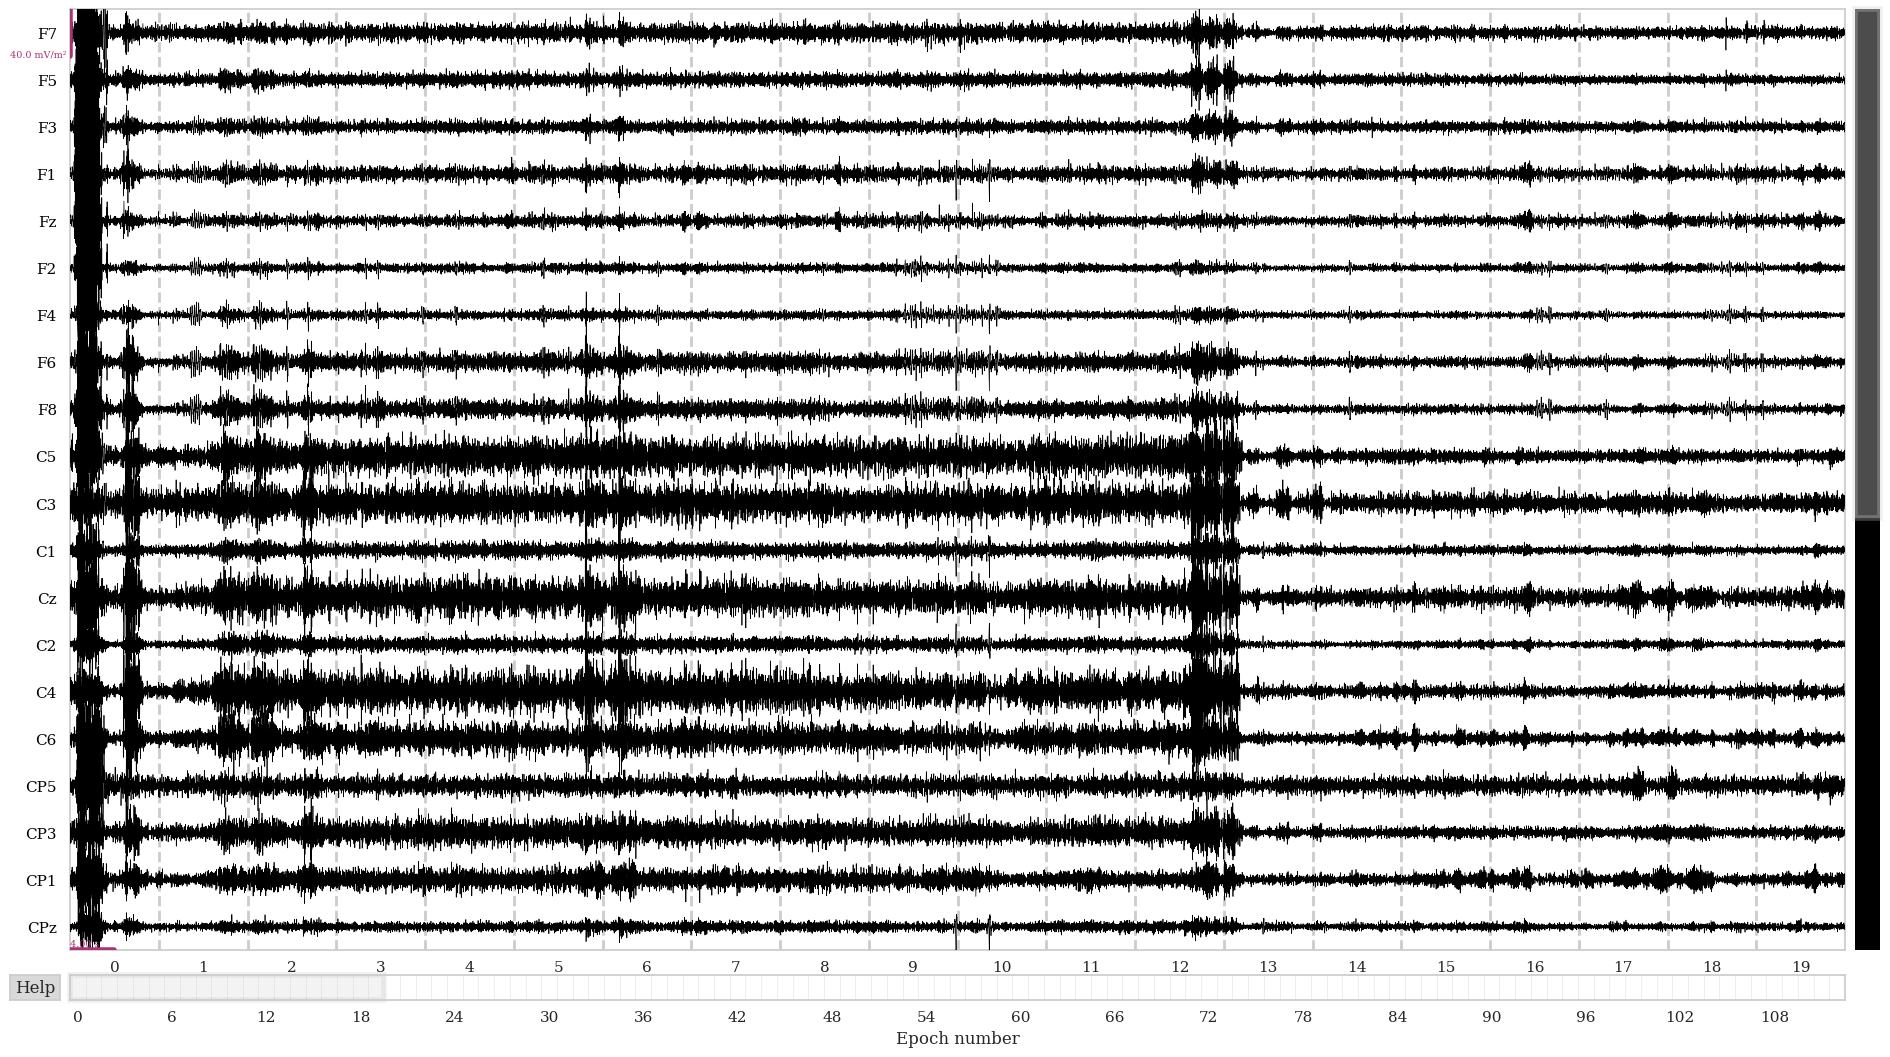

In [ ]:
# Assuming 'epochs' is your MNE Epochs object and it contains events named 'Left', 'Resting', 'Right'

centered_data_list = []
events_list = []

# Loop through each event ID
for idx, event_id in enumerate(desired_events):
    print (event_id)
    # Extract epochs for the current event
    event_epochs = epochs[event_id]
    event_data = event_epochs.get_data()
    
    # Calculate the mean across epochs for the current event
    mean_across_event_epochs = event_data.mean(axis=0)
    
    # Subtract the mean from each epoch of the current event
    centered_event_data = event_data - mean_across_event_epochs
    
    # Store the centered data
    centered_data_list.append(centered_event_data)
    
    # Prepare the events list and event_id_map for the combined EpochsArray
    events_list.append(event_epochs.events)

# Concatenate all centered data and events
centered_data = np.concatenate(centered_data_list, axis=0)
combined_events = np.concatenate(events_list, axis=0)

# Sort the combined events based on their original occurrence time to preserve the temporal sequence
sort_indices = np.argsort(combined_events[:, 0])
combined_events = combined_events[sort_indices]
centered_data = centered_data[sort_indices]

# Create a new EpochsArray with the centered data
centered_epochs = mne.EpochsArray(centered_data, epochs.info, events=combined_events, event_id=epochs.event_id, tmin=epochs.tmin)
centered_epochs.plot()
# Note: This code assumes event_ids are correctly listed and exist within the original epochs.
# You might need to adjust event_id_map or event IDs based on your specific dataset and requirements.

In [ ]:
data_to_predict=centered_epochs.copy().crop(tmin=1,tmax=3).get_data()[:,:]
thresholded_prediction=trained_clf.decision_function(data_to_predict)
prediction=trained_clf.predict(data_to_predict)

In [ ]:
prediction

array(['Rest', 'Rest', 'Rest', 'OpenPalm', 'OpenPalm', 'Rest', 'Rest',
       'OpenPalm', 'Rest', 'Rest', 'Rest', 'OpenPalm', 'Rest',
       'ClosePalm', 'OpenPalm', 'OpenPalm', 'Rest', 'ClosePalm', 'Rest',
       'OpenPalm', 'Rest', 'ClosePalm', 'Rest', 'OpenPalm', 'Rest',
       'ClosePalm', 'Rest', 'OpenPalm', 'Rest', 'Rest', 'Rest',
       'ClosePalm', 'Rest', 'ClosePalm', 'OpenPalm', 'ClosePalm', 'Rest',
       'OpenPalm', 'Rest', 'ActiveRest', 'Rest', 'ClosePalm', 'Rest',
       'ClosePalm', 'Rest', 'ClosePalm', 'Rest', 'ClosePalm', 'Rest',
       'ClosePalm', 'Rest', 'ClosePalm', 'Rest', 'OpenPalm', 'Rest',
       'ClosePalm', 'ActiveRest', 'OpenPalm', 'Rest', 'ClosePalm', 'Rest',
       'OpenPalm', 'Rest', 'OpenPalm', 'Rest', 'OpenPalm', 'OpenPalm',
       'OpenPalm', 'Rest', 'Rest', 'Rest', 'Rest', 'ActiveRest',
       'OpenPalm', 'ActiveRest', 'ActiveRest', 'Rest', 'OpenPalm', 'Rest',
       'Rest', 'Rest', 'OpenPalm', 'Rest', 'OpenPalm', 'Rest',
       'ClosePalm', 'Rest', '

In [ ]:
from collections import Counter

# Function to get the list of event names for each epoch
def get_epoch_events(epochs):
    events = epochs.events  # Get the array of events
    event_ids = epochs.event_id  # Get the mapping from event name to event code
    epoch_event_names = []

    for event in events:
        event_code = event[-1]  # Extract the event ID
        # Get the event name using the event code
        event_name = [key for key, val in event_ids.items() if val == event_code][0]
        epoch_event_names.append(event_name)

    return np.array(epoch_event_names)

# Function to compare actual event names with predicted event names and summarize mismatches
def compare_events(actual_events, predicted_events):
    comparison = actual_events == predicted_events  # Element-wise comparison
    accuracy = np.mean(comparison)  # Calculate accuracy
    mismatches = np.where(comparison == False)[0]  # Get indices where predictions don't match
    
    # Collect mismatched epochs and count occurrences of each mismatch case
    mismatch_details = []
    mismatch_counts = Counter()
    
    for idx in mismatches:
        actual = actual_events[idx]
        predicted = predicted_events[idx]
        mismatch_details.append(f"{idx + 1} - {actual} (actual), {predicted} (predicted)")
        mismatch_counts[f"{actual} -> {predicted}"] += 1  # Count each specific mismatch case

    return {
        'accuracy': accuracy,
        'mismatch_details': mismatch_details,
        'mismatch_counts': mismatch_counts
    }

# Example usage:
# Assume `epochs` is your mne.Epochs object, and `predictions` is the model output

actual_events = get_epoch_events(epochs)  # Actual events from the epochs
predicted_events = np.array(prediction)  # Replace with your model predictions

# Compare actual events to predicted events
result = compare_events(actual_events, predicted_events)

# Output the comparison result
print(f"Accuracy: {result['accuracy']:.2f}")
if result['mismatch_details']:
    print("Mismatched epochs:")
    for mismatch in result['mismatch_details']:
        print(mismatch)
    
    print("\nMismatch Summary:")
    for mismatch_case, count in result['mismatch_counts'].items():
        print(f"{mismatch_case}: {count} occurrence(s)")
else:
    print("No mismatches!")

Accuracy: 0.65
Mismatched epochs:
2 - ActiveRest (actual), Rest (predicted)
4 - ActiveRest (actual), OpenPalm (predicted)
5 - Rest (actual), OpenPalm (predicted)
6 - OpenPalm (actual), Rest (predicted)
8 - ClosePalm (actual), OpenPalm (predicted)
10 - ActiveRest (actual), Rest (predicted)
14 - ActiveRest (actual), ClosePalm (predicted)
15 - Rest (actual), OpenPalm (predicted)
20 - ClosePalm (actual), OpenPalm (predicted)
30 - ActiveRest (actual), Rest (predicted)
32 - ActiveRest (actual), ClosePalm (predicted)
34 - OpenPalm (actual), ClosePalm (predicted)
35 - Rest (actual), OpenPalm (predicted)
38 - ClosePalm (actual), OpenPalm (predicted)
44 - OpenPalm (actual), ClosePalm (predicted)
50 - ActiveRest (actual), ClosePalm (predicted)
56 - ActiveRest (actual), ClosePalm (predicted)
57 - Rest (actual), ActiveRest (predicted)
58 - ClosePalm (actual), OpenPalm (predicted)
60 - OpenPalm (actual), ClosePalm (predicted)
64 - ClosePalm (actual), OpenPalm (predicted)
66 - ActiveRest (actual), Op

In [ ]:
len(prediction)

113

In [ ]:
# Save the trained model 
Saved_Model = trained_clf
fname = 'Fudge_3rd_arm'+'_CSP_model_0211'
path_fname = current_path /'Models'/ fname

#create a pickle file
picklefile = open(path_fname, 'wb')
#pickle the dictionary and write it to file
pickle.dump(Saved_Model, picklefile)
#close the file
picklefile.close()



picks=params_dict['Electorde_Group']
fname = 'electrode_picks-0211'
path_fname = current_path /'Models'/ fname

#create a pickle file
picklefile = open(path_fname, 'wb')
#pickle the dictionary and write it to file
pickle.dump(picks, picklefile)
#close the file
picklefile.close()


fname = 'mean'
path_fname = current_path /'Models'/ fname

#create a pickle file
picklefile = open(path_fname, 'wb')
#pickle the dictionary and write it to file
pickle.dump(mean_across_epochs, picklefile)
#close the file
picklefile.close()

Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none


In [ ]:
recording_files[0:3]

['Fudge_MI3_1.xdf', 'Fudge_MI3_2.xdf', 'Fudge_MI3_3.xdf']

In [ ]:
OriginalRaw_Filtered.plot

<bound method BaseRaw.plot of <RawArray | 64 x 404519 (809.0 s), ~197.6 MB, data loaded>>

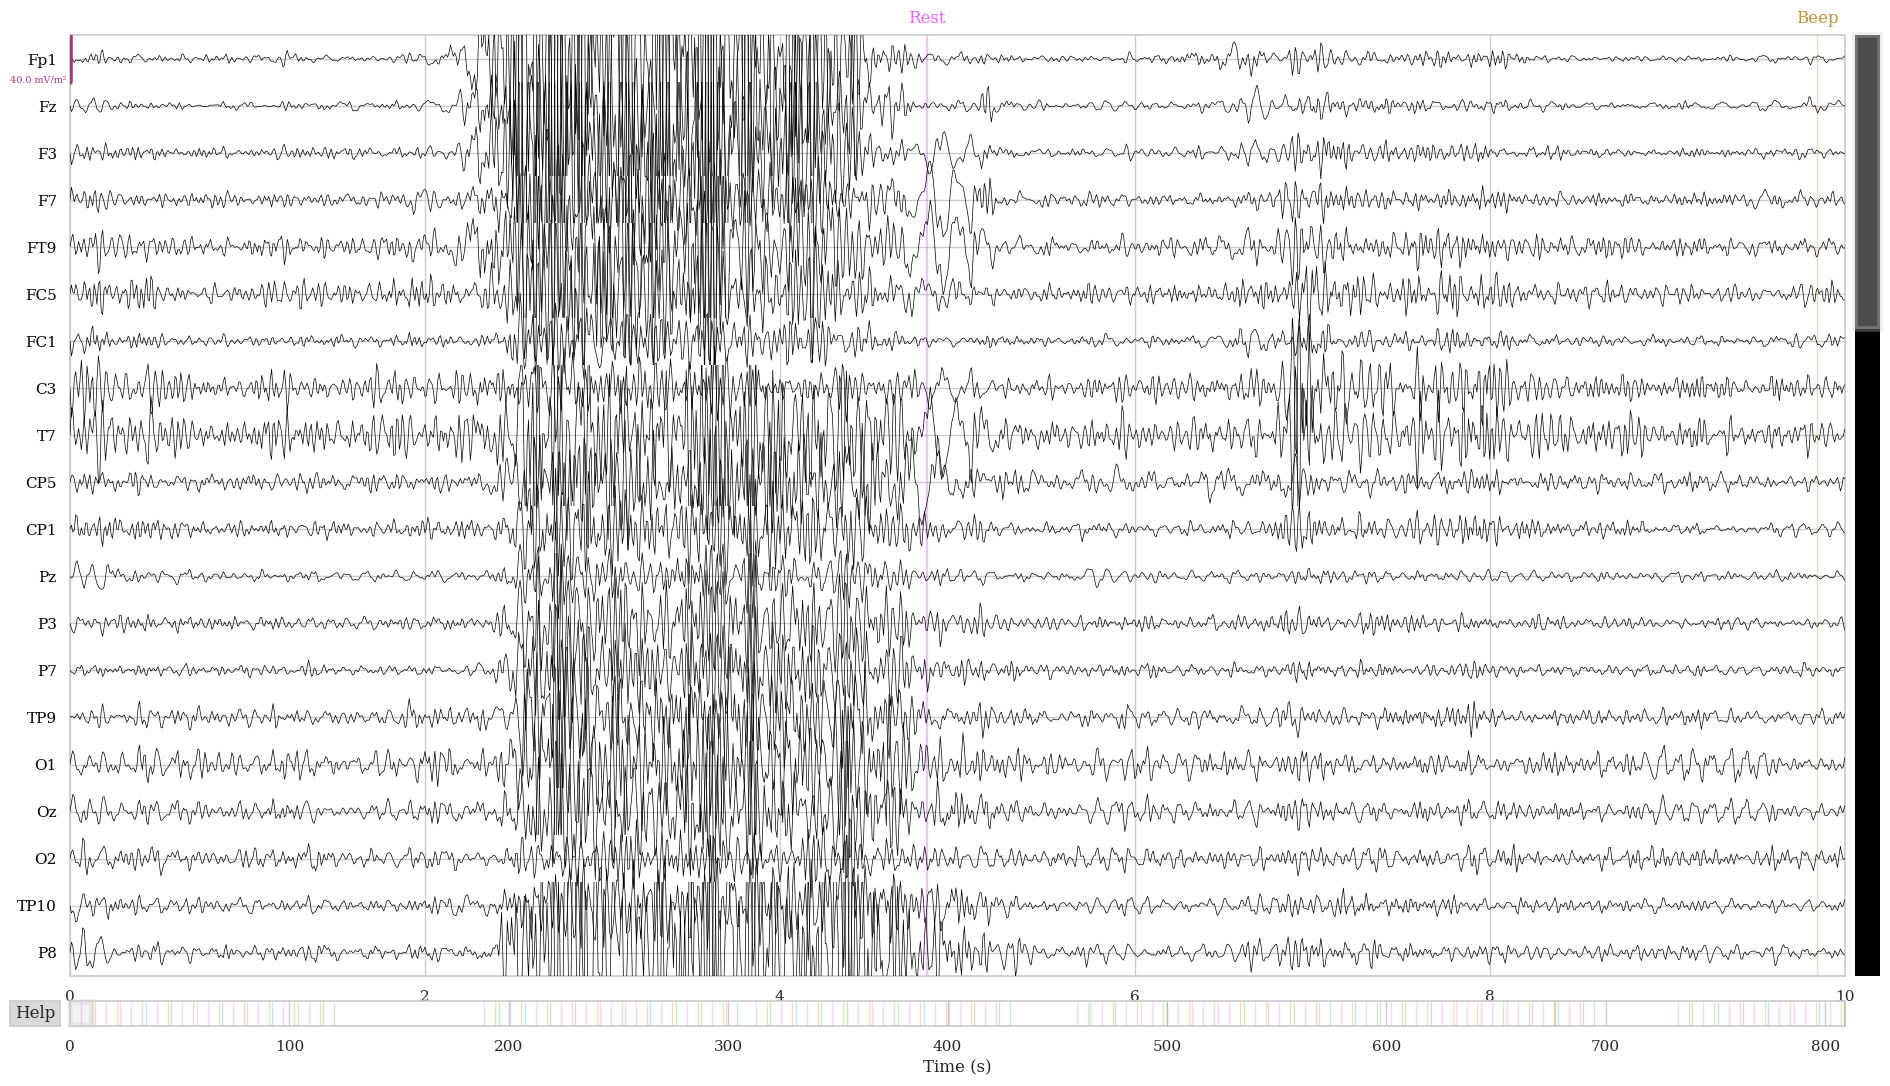

In [ ]:
recording_files.plot()

In [1]:
recording_files[]

SyntaxError: invalid syntax (3676581597.py, line 1)